In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb
from hyperopt import hp, tpe, Trials, STATUS_OK, Trials, anneal
from functools import partial
from hyperopt.fmin import fmin
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve,auc, fbeta_score
from sklearn.metrics import mean_squared_error
%reload_ext autoreload
%load_ext autoreload
%autoreload 1

from feas_select import  calc_feas,get_drop
import numpy as np
import  matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import random
import keras
from keras import regularizers
from keras.layers import Dense,Dropout,BatchNormalization,GaussianNoise
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import  mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import gc

gc.enable()

import numpy as np
import  matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import random
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import  mean_squared_error
import keras_tuner as kt  # pip install tf.keras_tuner 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))  # 全屏展示
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def read_train(file='./data/filter_feas_df32n_old.pkl',model='tree'):
    df = pd.read_pickle(file)
    df3 = pd.read_csv('./data/EXPERIAN_FEATURE_0327.csv',nrows=2) # 取旧模型特征列表
    print(df.shape)
    df.head()

    ##############################配置
    oot_dt ='20220200000000'
    nofeas = ['ID', 'report_timestamp','label','pan','label_y','order_id','label_pred']
    catefeas= list(pd.read_pickle('./data/catefeas.pkl').values)
    cbfeas = [col for col in df.columns if '_cb'in str(col)]
    vcount = [col for col in df.columns if 'vcount'in str(col)]
    old_feas = [col for col in df.columns if 'feature_'in str(col)]
    old_cols = list(df3.columns)
    sms_feas = [col for col in df3.columns if '_sms'in str(col)]
    nosms_feas = [col for col in df3.columns if '_sms' not in str(col) and col not in nofeas]
    drop_list=[]
    # try:
    #     upper1
    # except:
    #     print('first run')
    #     upper1,upper2,var_features,miss_features,sigle_rate = calc_feas(df,catefeas) ## 过滤法特征选择
    # drop_list = get_drop(upper1,upper2,var_features,miss_features,sigle_rate)

    drop_feas = nofeas+cbfeas+vcount+drop_list+catefeas                # 去除旧模型部分特征、类别特征等等
    final_feas = [col for col in df.columns if col not in drop_feas]
    


    ###########################
    # 强制类型转换
    def to_category_or_num(df, category_list, drop_list):
        if model == 'nn':  # 全数值型
            for ft in set(df.columns)-set(drop_list):
                df[ft] = pd.to_numeric(df[ft], errors='coerce').fillna(0).replace([np.inf], 99999).replace([-np.inf], -99999)
        else:
            for ft in set(df.columns)-set(drop_list):
                if ft in category_list:
                    df[ft] = df[ft].astype('category')
                else:
                    df[ft] = pd.to_numeric(df[ft], errors='coerce')

    to_category_or_num(df, catefeas, nofeas)
    df = df.reset_index(drop=True)
    ### 剔除特征 

    x = df[df['label'].notnull()&(df.report_timestamp<=oot_dt)][final_feas]
    y = df[df['label'].notnull()&(df.report_timestamp<=oot_dt)]['label']
    oot_x = df[df['label'].notnull()&(df.report_timestamp>oot_dt)][final_feas]
    oot_y = df[df['label'].notnull()&(df.report_timestamp>oot_dt)]['label']

    # ### 直接用旧模型的特征
    # x = df.loc[df['label'].notnull()&(df.report_timestamp<=oot_dt),old_fea]
    # y = df.loc[df['label'].notnull()&(df.report_timestamp<=oot_dt)]['label']
    # oot_x = df.loc[df['label'].notnull()&(df.report_timestamp>oot_dt),old_fea]
    # oot_y = df.loc[df['label'].notnull()&(df.report_timestamp>oot_dt)]['label']

    train_x, test_x, train_y, test_y = train_test_split(x, y,test_size=0.2,random_state=42)
    print(y.value_counts())
    print(oot_y.value_counts())
    display(train_x.head())
    print(train_x.shape)
    return train_x, test_x, train_y, test_y,oot_x,oot_y,df,final_feas

In [3]:
train_x, test_x, train_y, test_y,oot_x, oot_y,df,final_feas = read_train('./data/filter_feas_df_0403_n_old.pkl')

(9123, 1802)
1.0    5631
0.0    2040
Name: label, dtype: int64
1.0    1035
0.0     417
Name: label, dtype: int64


,BureauScore,MissingRate,Len_Name,Tel_nuniq,Email_nuniq,Len_of_addrs,City_nuniq,Current_State,CreditAccountActive,CreditAccountTotal,CreditAccountActivePor,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_All,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,NonCreditCAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_sum_30,Amount_Past_Due35_min_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_max_30,Highest_Credit_or_Original_Loan_Amount58_min_30,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_sum_30,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_std_90,Terms_Duration34_mean_360,Terms_Duration34_max_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_max_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_max_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_mean_30,Current_Balance35_min_30,Current_Balance35_std_30,Current_Balance35_sum_90,Current_Balance35_mean_90,Current_Balance35_max_90,Current_Balance35_std_90,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_max_9999,Current_Balance35_std_9999,Settlement_Amount37_max_360,Settlement_Amount37_min_360,Settlement_Amount37_std_360,Settlement_Amount37_sum_9999,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Settlement_Amount37_std_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_mean_360,Written_Off_Amt_Total41_min_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_sum_9999,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_mean_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_mean_360,Rate_of_Interest36_max_360,Rate_of_Interest36_min_360,Rate_of_Interest36_std_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_min_9999,Rate_of_Interest36_std_9999

(6136, 1761)


In [4]:
# bayes超参数优化 


# from scipy.misc import derivative

# def custom_asymmetric_train(y_true, y_pred):
#     residual = (y_true - y_pred).astype("float")
#     grad = np.where(residual<0, -2*10.0*residual, -2*residual)
#     hess = np.where(residual<0, 2*10.0, 2.0)
#     return grad, hess

# def f1_loss(y, pred):
#     beta = 2
#     p = 1. / (1 + np.exp(-pred))
#     grad = p * ((beta - 1) * y + 1) - beta * y
#     hess = ((beta - 1) * y + 1) * p * (1.0 - p)
 
#     return grad, hess

# def focal_loss_lgb(y_true, y_pred):
#     a,g = 0.25, 1.0
#     def fl(x,t):
#         p = 1/(1+np.exp(-x))
#         return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    
#     partial_fl = lambda x: fl(x, y_true)
#     grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
#     hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
#     return grad, hess
# #https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting_type-f79c1b40466d
# # https://blog.csdn.net/u013714645/article/details/105285038
# # https://towardsdatascience.com/lightgbm-with-the-focal-loss-for-imbalanced-datasets-9836a9ae00ca

# def lgb_f2_score(y_true, y_pred):
#     _,f2 = find_best_threshold(y_true, y_pred,bins_num=20)  #阈值精度20
#     return 'f2', f2, True

# clf = LGBMClassifier(num_leaves=lvs,#300 #610
#                      boosting_type= 'goss',
#                      max_depth=-1,
#                      n_estimators=1000,  #200
#                      learning_rate=0.01, # 0.01
#                      verbose=-1,
#                      reg_alpha=1,
#                      reg_lambda=1, 
#                      class_weight=None,
#                      subsample=0.7,
#                      colsample_bytree=0.7,
#                      n_jobs=-1,
#                      random_state=2) 

# clf.set_params(**{"objective": focal_loss_lgb})   #focal loss

# clf.fit(X_train, y_train,
#         eval_set=[(X_valid2, y_valid2)],
#         eval_metric=lgb_f2_score,              # f2 eval
#         early_stopping_rounds=100,verbose=-1)


# oof_prob = clf.predict_proba(X_valid2)#[:, 1]  # fea  # f-c losss no[:, 1] 



def model_metrics(model, x, y,tp='auc'):
    """ 评估 """
    # 动态阈值评估 
    yprob = model.predict_proba(x)[:,1]
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    score = auc(fpr, tpr) 
    if tp=='ks':
        return auc(fpr, tpr),max(tpr-fpr)
    return score


def bayes_fmin(train_x, test_x, train_y, test_y, eval_iters):
    """
    bayes 优化超参数
    """
    
    def lgb_factory(params):
        """
        定义调参目标函数
        """
        fit_params = {
            "boosting_type":params["boosting_type"],
            'max_depth':int(params['max_depth']),
            'n_estimators':int(params['n_estimators']),
            "learning_rate":params["learning_rate"],
            "num_leaves": int(params["num_leaves"]),
            #"class_weight":{0:1,  1:float(params['class_weight'])}, 
            "class_weight": params['class_weight'],
            "reg_alpha":params["reg_alpha"],
            "reg_lambda":params["reg_lambda"],
            'subsample_for_bin':int(params['subsample_for_bin']),            
            'subsample':params['subsample'],
            "feature_fraction":params["feature_fraction"],
            "min_child_samples":int(params["min_child_samples"]),            
            'min_child_weight': params['min_child_weight'],
            "min_split_gain":params["min_split_gain"]
            }
        fit_params.update(base_params)
        # 模型训练
        model=lgb.LGBMClassifier(**fit_params)
        model.fit(train_x, train_y,
                  eval_set=[(test_x, test_y)],
                  eval_metric='auc',   # 'f1'
                  early_stopping_rounds=50, #  30round
                  verbose=-1)
        print('***\n',fit_params)
        # 测试集最小化为目标
        metric = model_metrics(model, test_x, test_y)
        print(metric)
        return {"loss": -metric, "status":STATUS_OK}

    ########start 参数空间1
    base_params = {
            "n_jobs":-1, 
            "objective":'binary',
            "verbose":-1,
            "random_state":0        
            }
    space = {
        'max_depth': hp.quniform('max_depth', 2, 22, 1),
        'n_estimators': hp.quniform('n_estimators', 10, 2424, 10),
        'boosting_type': hp.choice('boosting_type', ['gbdt','dart','goss']),
        #'class_weight':hp.uniform('class_weight', 0.005, 300) ,   # None
        'class_weight':hp.choice('class_weight', [None,'balanced']),
        'num_leaves': hp.quniform('num_leaves', 4, 2424, 8),
        'learning_rate': hp.uniform('learning_rate', 1e-4, 1),
        'subsample_for_bin': hp.quniform('subsample_for_bin', 10000, 350000, 20000),
        'feature_fraction': hp.uniform('feature_fraction', 0.1, 1),
        'subsample': hp.uniform('subsample', 0.1, 1), 
        'min_child_samples': hp.qloguniform('min_child_samples', 0, 10, 1),  
        'reg_alpha': hp.uniform('reg_alpha', 0, 10),
        'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), 
        'min_split_gain': hp.uniform('min_split_gain', 0, 10)
            }
    # 2、优化
    best_params = fmin(lgb_factory, space, algo=partial(anneal.suggest,), max_evals=eval_iters, trials=Trials(),return_argmin=True,verbose=-1)
    
    # 3、优化后取最优参数,规范格式
    best_params.update(base_params)
    best_params["boosting_type"] = ['gbdt','dart','goss'][int(best_params["boosting_type"])]
    best_params['class_weight'] =  [None,'balanced'][int(best_params['class_weight'])]
    best_params["n_estimators"] = int(best_params["n_estimators"])
    #best_params['class_weight'] = {0:1,  1:float(params['class_weight'])}
    best_params["min_child_samples"] = int(best_params["min_child_samples"])
    best_params["subsample_for_bin"] = int(best_params["subsample_for_bin"])
    best_params["num_leaves"] = int(best_params["num_leaves"])
    best_params["max_depth"] = int(best_params["max_depth"])

    
    return best_params

In [5]:



# 贝叶斯调参 
best_params = bayes_fmin(train_x, test_x , train_y, test_y ,200)  


print('------------best_params------------',best_params)


# 验证
clf = LGBMClassifier(**best_params)
clf.fit(train_x, train_y,
        eval_set=[(test_x,test_y)],
        eval_metric='auc',
        early_stopping_rounds=50,verbose=-1)

print('------------train------------\n',model_metrics(clf, train_x,train_y))


print('------------test------------\n',model_metrics(clf, test_x,test_y))

print('------------oot------------\n',model_metrics(clf, oot_x,oot_y))



[LightGBM] [Warning] feature_fraction is set=0.19479896257873636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19479896257873636
  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                    

{'boosting_type': 'goss', 'max_depth': 3, 'n_estimators': 1980, 'learning_rate': 0.9852864338838605, 'num_leaves': 1232, 'class_weight': 'balanced', 'reg_alpha': 2.091696002987061, 'reg_lambda': 9.938406128379317, 'subsample_for_bin': 180000, 'subsample': 0.2945655009126482, 'feature_fraction': 0.19479896257873636, 'min_child_samples': 529, 'min_child_weight': 8.391731214846337e-06, 'min_split_gain': 9.854832903115904, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.5842249611370197                                     
[LightGBM] [Warning] feature_fraction is set=0.7687536864071366, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7687536864071366
  0%|          | 1/200 [00:00<02:08,  1.54trial/s, best loss: -0.5842249611370197]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                               

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 970, 'learning_rate': 0.33310161473802635, 'num_leaves': 1448, 'class_weight': 'balanced', 'reg_alpha': 5.5608563655107295, 'reg_lambda': 8.978240404433915, 'subsample_for_bin': 240000, 'subsample': 0.8228691282890405, 'feature_fraction': 0.7687536864071366, 'min_child_samples': 19, 'min_child_weight': 15.766079550370673, 'min_split_gain': 7.848181867192955, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.726866533422163                                                                 
[LightGBM] [Warning] feature_fraction is set=0.11630692195648884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11630692195648884
  1%|          | 2/200 [00:04<08:55,  2.71s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                              

{'boosting_type': 'goss', 'max_depth': 12, 'n_estimators': 610, 'learning_rate': 0.5033372430295594, 'num_leaves': 1520, 'class_weight': 'balanced', 'reg_alpha': 2.7618382264874564, 'reg_lambda': 2.857281409959361, 'subsample_for_bin': 220000, 'subsample': 0.15907526142453599, 'feature_fraction': 0.11630692195648884, 'min_child_samples': 20, 'min_child_weight': 0.00022771709123439133, 'min_split_gain': 6.4166098616085145, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.6456795469686876                                                               
[LightGBM] [Warning] feature_fraction is set=0.37370711890368447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37370711890368447
  2%|▏         | 3/200 [00:06<07:01,  2.14s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                              

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 1220, 'learning_rate': 0.3504823346695504, 'num_leaves': 656, 'class_weight': 'balanced', 'reg_alpha': 2.9062838699333833, 'reg_lambda': 4.225356036036146, 'subsample_for_bin': 260000, 'subsample': 0.6180087339548825, 'feature_fraction': 0.37370711890368447, 'min_child_samples': 2, 'min_child_weight': 0.25872602677819173, 'min_split_gain': 4.899381504624858, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7213124583610926                                                               
[LightGBM] [Warning] feature_fraction is set=0.6845587099836179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6845587099836179
  2%|▏         | 4/200 [00:11<11:02,  3.38s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                              

{'boosting_type': 'goss', 'max_depth': 3, 'n_estimators': 1270, 'learning_rate': 0.6286403915027452, 'num_leaves': 968, 'class_weight': None, 'reg_alpha': 4.339606616629066, 'reg_lambda': 2.8927862587873916, 'subsample_for_bin': 240000, 'subsample': 0.46043816260040965, 'feature_fraction': 0.6845587099836179, 'min_child_samples': 249, 'min_child_weight': 1.1175465735294623e-06, 'min_split_gain': 9.067997766154344, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.6672018654230513                                                               
[LightGBM] [Warning] feature_fraction is set=0.7296224770039649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7296224770039649
  2%|▎         | 5/200 [00:12<07:43,  2.38s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                              

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 860, 'learning_rate': 0.5809220216933484, 'num_leaves': 728, 'class_weight': 'balanced', 'reg_alpha': 8.774070585260539, 'reg_lambda': 8.021061288314236, 'subsample_for_bin': 160000, 'subsample': 0.7365083441864938, 'feature_fraction': 0.7296224770039649, 'min_child_samples': 750, 'min_child_weight': 0.00217822928611883, 'min_split_gain': 4.156041104315096, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.6659427048634243                                                               
[LightGBM] [Warning] feature_fraction is set=0.8333533526583996, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8333533526583996
  3%|▎         | 6/200 [00:15<08:21,  2.58s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                              

{'boosting_type': 'dart', 'max_depth': 14, 'n_estimators': 820, 'learning_rate': 0.6365290988895231, 'num_leaves': 1624, 'class_weight': 'balanced', 'reg_alpha': 6.68680537308898, 'reg_lambda': 9.750494100606875, 'subsample_for_bin': 300000, 'subsample': 0.8283858423493874, 'feature_fraction': 0.8333533526583996, 'min_child_samples': 2, 'min_child_weight': 0.01731944948115363, 'min_split_gain': 8.911382525991424, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7246724405951588                                                               
[LightGBM] [Warning] feature_fraction is set=0.9322759973826181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9322759973826181
  4%|▎         | 7/200 [00:18<09:18,  2.89s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                              

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 850, 'learning_rate': 0.08262355304428162, 'num_leaves': 2152, 'class_weight': 'balanced', 'reg_alpha': 7.594002302054639, 'reg_lambda': 9.88552697872026, 'subsample_for_bin': 280000, 'subsample': 0.9510255019021908, 'feature_fraction': 0.9322759973826181, 'min_child_samples': 46, 'min_child_weight': 2.5059427075484955, 'min_split_gain': 6.7371137031920805, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7260515212080836                                                               
[LightGBM] [Warning] feature_fraction is set=0.5647122063581109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5647122063581109
  4%|▍         | 8/200 [00:23<11:11,  3.50s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                              

{'boosting_type': 'dart', 'max_depth': 17, 'n_estimators': 1580, 'learning_rate': 0.06999806403376876, 'num_leaves': 808, 'class_weight': 'balanced', 'reg_alpha': 5.004730898145903, 'reg_lambda': 7.666669890305705, 'subsample_for_bin': 320000, 'subsample': 0.7927900503857157, 'feature_fraction': 0.5647122063581109, 'min_child_samples': 3, 'min_child_weight': 0.014945677763915822, 'min_split_gain': 8.051086740525589, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7256184765711748                                                               
[LightGBM] [Warning] feature_fraction is set=0.36878899137108884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.36878899137108884
  4%|▍         | 9/200 [00:31<15:30,  4.87s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                              

{'boosting_type': 'dart', 'max_depth': 14, 'n_estimators': 1320, 'learning_rate': 0.4081847768952718, 'num_leaves': 120, 'class_weight': 'balanced', 'reg_alpha': 5.170138275626156, 'reg_lambda': 2.050319422111263, 'subsample_for_bin': 340000, 'subsample': 0.5286888726530024, 'feature_fraction': 0.36878899137108884, 'min_child_samples': 90, 'min_child_weight': 0.08034370090012231, 'min_split_gain': 2.7735577026752214, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.722356206973129                                                                
[LightGBM] [Warning] feature_fraction is set=0.5532568538571038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5532568538571038
  5%|▌         | 10/200 [00:37<16:21,  5.16s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                               

{'boosting_type': 'dart', 'max_depth': 17, 'n_estimators': 1270, 'learning_rate': 0.3564745463148824, 'num_leaves': 2288, 'class_weight': 'balanced', 'reg_alpha': 5.8818221515722815, 'reg_lambda': 7.097581014458328, 'subsample_for_bin': 320000, 'subsample': 0.969067424860158, 'feature_fraction': 0.5532568538571038, 'min_child_samples': 10, 'min_child_weight': 1.1180893003689625, 'min_split_gain': 9.109293059923846, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7231601154785698                                                                
[LightGBM] [Warning] feature_fraction is set=0.9067496769267206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9067496769267206
  6%|▌         | 11/200 [00:43<17:42,  5.62s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                               

{'boosting_type': 'dart', 'max_depth': 17, 'n_estimators': 1100, 'learning_rate': 0.45402770910216705, 'num_leaves': 1848, 'class_weight': 'balanced', 'reg_alpha': 8.754040024648154, 'reg_lambda': 9.53304311978967, 'subsample_for_bin': 200000, 'subsample': 0.5890441699519846, 'feature_fraction': 0.9067496769267206, 'min_child_samples': 19, 'min_child_weight': 0.220732301512288, 'min_split_gain': 7.0395901393384035, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7241927603819676                                                                
[LightGBM] [Warning] feature_fraction is set=0.8306066740748748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306066740748748
  6%|▌         | 12/200 [00:48<16:54,  5.40s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                               

{'boosting_type': 'gbdt', 'max_depth': 21, 'n_estimators': 440, 'learning_rate': 0.4525452455541431, 'num_leaves': 1408, 'class_weight': 'balanced', 'reg_alpha': 6.880676910531465, 'reg_lambda': 7.0647512005505835, 'subsample_for_bin': 160000, 'subsample': 0.8044687960911437, 'feature_fraction': 0.8306066740748748, 'min_child_samples': 152, 'min_child_weight': 37.7133771342842, 'min_split_gain': 7.583095765062531, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7091550077725961                                                                
[LightGBM] [Warning] feature_fraction is set=0.9044607817635453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9044607817635453
  6%|▋         | 13/200 [00:50<12:58,  4.16s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                               

{'boosting_type': 'dart', 'max_depth': 14, 'n_estimators': 680, 'learning_rate': 0.07242116974978882, 'num_leaves': 1976, 'class_weight': 'balanced', 'reg_alpha': 8.894825784142945, 'reg_lambda': 8.476624074762857, 'subsample_for_bin': 300000, 'subsample': 0.8464205682538043, 'feature_fraction': 0.9044607817635453, 'min_child_samples': 23, 'min_child_weight': 0.6014193384034521, 'min_split_gain': 6.095636882063807, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7230313124583612                                                                
[LightGBM] [Warning] feature_fraction is set=0.8243032316168933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8243032316168933
  7%|▋         | 14/200 [00:54<12:58,  4.18s/trial, best loss: -0.726866533422163]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                               

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 580, 'learning_rate': 0.2855920231606569, 'num_leaves': 1240, 'class_weight': 'balanced', 'reg_alpha': 6.233104210420613, 'reg_lambda': 7.604236307663832, 'subsample_for_bin': 240000, 'subsample': 0.9805844565269456, 'feature_fraction': 0.8243032316168933, 'min_child_samples': 5, 'min_child_weight': 4.717118190303421, 'min_split_gain': 6.228816662745963, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7278236731068177                                                                
[LightGBM] [Warning] feature_fraction is set=0.6175474602819021, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175474602819021
  8%|▊         | 15/200 [00:57<11:57,  3.88s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 15, 'n_estimators': 600, 'learning_rate': 0.2350099357395245, 'num_leaves': 1336, 'class_weight': 'balanced', 'reg_alpha': 6.916884266616757, 'reg_lambda': 7.615227416065304, 'subsample_for_bin': 260000, 'subsample': 0.7430406056333367, 'feature_fraction': 0.6175474602819021, 'min_child_samples': 89, 'min_child_weight': 0.0891427502313874, 'min_split_gain': 6.935403611087886, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7244015101043749                                                                 
[LightGBM] [Warning] feature_fraction is set=0.975501823410721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.975501823410721
  8%|▊         | 16/200 [00:58<09:31,  3.11s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 15, 'n_estimators': 220, 'learning_rate': 0.4199790665835437, 'num_leaves': 912, 'class_weight': 'balanced', 'reg_alpha': 6.724775028551894, 'reg_lambda': 8.823089509036675, 'subsample_for_bin': 240000, 'subsample': 0.6925955266671727, 'feature_fraction': 0.975501823410721, 'min_child_samples': 7, 'min_child_weight': 5.96821147963354, 'min_split_gain': 4.882210875063688, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7273639795691762                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7605379199753781, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7605379199753781
  8%|▊         | 17/200 [01:00<08:17,  2.72s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 21, 'n_estimators': 620, 'learning_rate': 0.36804757026514373, 'num_leaves': 960, 'class_weight': 'balanced', 'reg_alpha': 6.398467679155395, 'reg_lambda': 9.013277785599431, 'subsample_for_bin': 280000, 'subsample': 0.8800672402167968, 'feature_fraction': 0.7605379199753781, 'min_child_samples': 6, 'min_child_weight': 16.321935350781054, 'min_split_gain': 6.306282447297181, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7263868532089718                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7061999908448822, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7061999908448822
  9%|▉         | 18/200 [01:03<08:10,  2.69s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 20, 'n_estimators': 810, 'learning_rate': 0.2537152504294451, 'num_leaves': 1344, 'class_weight': None, 'reg_alpha': 4.506830530955673, 'reg_lambda': 7.6076359230420865, 'subsample_for_bin': 240000, 'subsample': 0.750183996405033, 'feature_fraction': 0.7061999908448822, 'min_child_samples': 13, 'min_child_weight': 57.24279479095907, 'min_split_gain': 7.061374454756256, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7108560959360426                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7365188118745708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7365188118745708
 10%|▉         | 19/200 [01:04<06:50,  2.27s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 16, 'n_estimators': 730, 'learning_rate': 0.39464121523674967, 'num_leaves': 1136, 'class_weight': 'balanced', 'reg_alpha': 7.342977230133743, 'reg_lambda': 8.52593638048948, 'subsample_for_bin': 220000, 'subsample': 0.95926880732464, 'feature_fraction': 0.7365188118745708, 'min_child_samples': 2, 'min_child_weight': 0.1695544995709687, 'min_split_gain': 7.545947484601711, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7250610703975129                                                                 
[LightGBM] [Warning] feature_fraction is set=0.969404220383517, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.969404220383517
 10%|█         | 20/200 [01:07<07:23,  2.46s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 15, 'n_estimators': 260, 'learning_rate': 0.12489900347264353, 'num_leaves': 1024, 'class_weight': 'balanced', 'reg_alpha': 7.597240491875629, 'reg_lambda': 6.427308565381281, 'subsample_for_bin': 240000, 'subsample': 0.9788300342308518, 'feature_fraction': 0.969404220383517, 'min_child_samples': 1, 'min_child_weight': 0.30876087857274015, 'min_split_gain': 6.797281752421117, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.720759493670886                                                                  
[LightGBM] [Warning] feature_fraction is set=0.8234437349755014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234437349755014
 10%|█         | 21/200 [01:09<06:45,  2.26s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 17, 'n_estimators': 280, 'learning_rate': 0.4818783144628083, 'num_leaves': 880, 'class_weight': 'balanced', 'reg_alpha': 7.500146478497338, 'reg_lambda': 7.625356579005223, 'subsample_for_bin': 240000, 'subsample': 0.5606488243394896, 'feature_fraction': 0.8234437349755014, 'min_child_samples': 11, 'min_child_weight': 28.305636695370268, 'min_split_gain': 5.940746332737641, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7249011769931156                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8142090417524871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8142090417524871
 11%|█         | 22/200 [01:10<06:02,  2.04s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 16, 'n_estimators': 480, 'learning_rate': 0.24098562744604513, 'num_leaves': 1184, 'class_weight': 'balanced', 'reg_alpha': 6.793070835046112, 'reg_lambda': 9.008963280142025, 'subsample_for_bin': 260000, 'subsample': 0.9185083568235796, 'feature_fraction': 0.8142090417524871, 'min_child_samples': 12, 'min_child_weight': 53.8852947795671, 'min_split_gain': 6.974835643008724, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7149278258938485                                                                 
[LightGBM] [Warning] feature_fraction is set=0.9180246396659253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9180246396659253
 12%|█▏        | 23/200 [01:13<06:14,  2.12s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 14, 'n_estimators': 280, 'learning_rate': 0.38660198438140353, 'num_leaves': 688, 'class_weight': 'balanced', 'reg_alpha': 7.780069528733969, 'reg_lambda': 8.045805425769803, 'subsample_for_bin': 200000, 'subsample': 0.661058749865213, 'feature_fraction': 0.9180246396659253, 'min_child_samples': 3, 'min_child_weight': 3.9078079416904257, 'min_split_gain': 5.876370935069, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7205851654452587                                                                 
[LightGBM] [Warning] feature_fraction is set=0.9283397576519351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9283397576519351
 12%|█▏        | 24/200 [01:13<05:08,  1.75s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 17, 'n_estimators': 230, 'learning_rate': 0.34732378732386504, 'num_leaves': 1320, 'class_weight': 'balanced', 'reg_alpha': 5.964142976337241, 'reg_lambda': 7.9096066611875155, 'subsample_for_bin': 240000, 'subsample': 0.9341537217662778, 'feature_fraction': 0.9283397576519351, 'min_child_samples': 1, 'min_child_weight': 25.42779134522036, 'min_split_gain': 7.258289450197401, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7231978680879414                                                                 
[LightGBM] [Warning] feature_fraction is set=0.6997600063799053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6997600063799053
 12%|█▎        | 25/200 [01:15<05:05,  1.75s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 18, 'n_estimators': 500, 'learning_rate': 0.2659817908608452, 'num_leaves': 1392, 'class_weight': 'balanced', 'reg_alpha': 6.734445765336498, 'reg_lambda': 7.2918621387143725, 'subsample_for_bin': 240000, 'subsample': 0.8100744637541586, 'feature_fraction': 0.6997600063799053, 'min_child_samples': 5, 'min_child_weight': 0.619095347672697, 'min_split_gain': 6.199202191704935, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7203331112591607                                                                 
[LightGBM] [Warning] feature_fraction is set=0.9257741703075144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9257741703075144
 13%|█▎        | 26/200 [01:16<04:41,  1.62s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 420, 'learning_rate': 0.4691847204988753, 'num_leaves': 752, 'class_weight': 'balanced', 'reg_alpha': 6.960290214125804, 'reg_lambda': 9.538182496821713, 'subsample_for_bin': 200000, 'subsample': 0.7861104810581363, 'feature_fraction': 0.9257741703075144, 'min_child_samples': 2, 'min_child_weight': 1.5056654593108423, 'min_split_gain': 4.247413338969691, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7200621807683767                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8625592272875144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8625592272875144
 14%|█▎        | 27/200 [01:19<05:00,  1.74s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 21, 'n_estimators': 540, 'learning_rate': 0.2674173906983709, 'num_leaves': 1112, 'class_weight': None, 'reg_alpha': 6.5866358979315205, 'reg_lambda': 7.581992519789308, 'subsample_for_bin': 280000, 'subsample': 0.7908540793346995, 'feature_fraction': 0.8625592272875144, 'min_child_samples': 16, 'min_child_weight': 9.90988564943376, 'min_split_gain': 7.177938385498064, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7271729957805907                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7275823087200851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7275823087200851
 14%|█▍        | 28/200 [01:21<05:37,  1.96s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 280, 'learning_rate': 0.24373263966915334, 'num_leaves': 1088, 'class_weight': 'balanced', 'reg_alpha': 4.931668352193057, 'reg_lambda': 7.207565589503354, 'subsample_for_bin': 200000, 'subsample': 0.7722430781368412, 'feature_fraction': 0.7275823087200851, 'min_child_samples': 8, 'min_child_weight': 1.7962991105789583, 'min_split_gain': 7.356692234830383, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7270752831445703                                                                 
[LightGBM] [Warning] feature_fraction is set=0.9380701090795873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9380701090795873
 14%|█▍        | 29/200 [01:23<05:23,  1.89s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 16, 'n_estimators': 330, 'learning_rate': 0.4935073450012957, 'num_leaves': 872, 'class_weight': 'balanced', 'reg_alpha': 7.57755006351069, 'reg_lambda': 9.218635010378561, 'subsample_for_bin': 280000, 'subsample': 0.7933021485639078, 'feature_fraction': 0.9380701090795873, 'min_child_samples': 2, 'min_child_weight': 45.41383381916635, 'min_split_gain': 5.572475870328308, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7103442149677992                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8563705923012167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8563705923012167
 15%|█▌        | 30/200 [01:24<05:13,  1.84s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 400, 'learning_rate': 0.1902393264375724, 'num_leaves': 968, 'class_weight': 'balanced', 'reg_alpha': 5.2891808192589265, 'reg_lambda': 7.511894985503866, 'subsample_for_bin': 200000, 'subsample': 0.9038230033961921, 'feature_fraction': 0.8563705923012167, 'min_child_samples': 14, 'min_child_weight': 2.3389494393558588, 'min_split_gain': 6.3255582452589145, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7270619586942039                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8751448451426475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8751448451426475
 16%|█▌        | 31/200 [01:27<05:24,  1.92s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 19, 'n_estimators': 960, 'learning_rate': 0.2552980310360923, 'num_leaves': 1176, 'class_weight': 'balanced', 'reg_alpha': 6.233817730737725, 'reg_lambda': 8.180621122668171, 'subsample_for_bin': 280000, 'subsample': 0.8786824405564694, 'feature_fraction': 0.8751448451426475, 'min_child_samples': 15, 'min_child_weight': 3.470126901618046, 'min_split_gain': 6.665948964914292, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7234510326449034                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8717757437070474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8717757437070474
 16%|█▌        | 32/200 [01:28<04:46,  1.70s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 630, 'learning_rate': 0.21627444444782154, 'num_leaves': 1264, 'class_weight': None, 'reg_alpha': 5.605656522743246, 'reg_lambda': 8.591509275920737, 'subsample_for_bin': 300000, 'subsample': 0.878934540456602, 'feature_fraction': 0.8717757437070474, 'min_child_samples': 12, 'min_child_weight': 52.07326722122193, 'min_split_gain': 7.0757364933718465, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7150122140795026                                                                 
[LightGBM] [Warning] feature_fraction is set=0.741269331490626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.741269331490626
 16%|█▋        | 33/200 [01:31<05:43,  2.05s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 340, 'learning_rate': 0.33395581717952105, 'num_leaves': 1152, 'class_weight': 'balanced', 'reg_alpha': 6.766482313181243, 'reg_lambda': 7.49947344386946, 'subsample_for_bin': 280000, 'subsample': 0.8997513903521105, 'feature_fraction': 0.741269331490626, 'min_child_samples': 9, 'min_child_weight': 11.143793694906575, 'min_split_gain': 5.522620718667675, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7246835443037974                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8302849644835566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8302849644835566
 17%|█▋        | 34/200 [01:33<05:36,  2.03s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 550, 'learning_rate': 0.17135330316354921, 'num_leaves': 1136, 'class_weight': None, 'reg_alpha': 6.335420626064704, 'reg_lambda': 8.409995359802597, 'subsample_for_bin': 280000, 'subsample': 0.7496881028211577, 'feature_fraction': 0.8302849644835566, 'min_child_samples': 43, 'min_child_weight': 5.938543495889184, 'min_split_gain': 7.901662595061522, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7276460137685987                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8603250606884552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8603250606884552
 18%|█▊        | 35/200 [01:35<05:58,  2.17s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 16, 'n_estimators': 400, 'learning_rate': 0.21653471050255624, 'num_leaves': 1112, 'class_weight': 'balanced', 'reg_alpha': 6.964083529071258, 'reg_lambda': 8.697111419691371, 'subsample_for_bin': 200000, 'subsample': 0.9459577082444771, 'feature_fraction': 0.8603250606884552, 'min_child_samples': 8, 'min_child_weight': 38.449228735945034, 'min_split_gain': 5.914140258548441, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7147768154563624                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7417829595360906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7417829595360906
 18%|█▊        | 36/200 [01:37<05:57,  2.18s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 540, 'learning_rate': 0.13030159282514303, 'num_leaves': 952, 'class_weight': None, 'reg_alpha': 6.040944229596039, 'reg_lambda': 9.1039899965349, 'subsample_for_bin': 300000, 'subsample': 0.827615327703739, 'feature_fraction': 0.7417829595360906, 'min_child_samples': 36, 'min_child_weight': 38.59524735088549, 'min_split_gain': 6.871067808756568, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7236620031090384                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8269813352138748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8269813352138748
 18%|█▊        | 37/200 [01:40<06:07,  2.25s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 750, 'learning_rate': 0.08625293804899162, 'num_leaves': 1144, 'class_weight': None, 'reg_alpha': 6.509190607440286, 'reg_lambda': 8.562312935919172, 'subsample_for_bin': 260000, 'subsample': 0.7654154287269765, 'feature_fraction': 0.8269813352138748, 'min_child_samples': 95, 'min_child_weight': 46.4406787397528, 'min_split_gain': 6.9086754465646205, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7150299800133245                                                                 
[LightGBM] [Warning] feature_fraction is set=0.9163283793794095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9163283793794095
 19%|█▉        | 38/200 [01:44<07:55,  2.94s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'goss', 'max_depth': 18, 'n_estimators': 590, 'learning_rate': 0.3838603671705739, 'num_leaves': 1112, 'class_weight': 'balanced', 'reg_alpha': 6.425481411871239, 'reg_lambda': 7.918178402920619, 'subsample_for_bin': 260000, 'subsample': 0.8572366326118882, 'feature_fraction': 0.9163283793794095, 'min_child_samples': 11, 'min_child_weight': 1.7356736597153135, 'min_split_gain': 6.311049236833272, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7032900288696424                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7606156190426231, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7606156190426231
 20%|█▉        | 39/200 [01:46<06:35,  2.46s/trial, best loss: -0.7278236731068177]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 610, 'learning_rate': 0.2110531675055364, 'num_leaves': 1160, 'class_weight': 'balanced', 'reg_alpha': 5.419283066299756, 'reg_lambda': 8.071609615567715, 'subsample_for_bin': 260000, 'subsample': 0.9653051369258332, 'feature_fraction': 0.7606156190426231, 'min_child_samples': 10, 'min_child_weight': 0.7930591827188987, 'min_split_gain': 7.235592556795636, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7286475682878082                                                                 
[LightGBM] [Warning] feature_fraction is set=0.6400826256242799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6400826256242799
 20%|██        | 40/200 [01:49<06:53,  2.59s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 440, 'learning_rate': 0.3178862290532444, 'num_leaves': 1176, 'class_weight': 'balanced', 'reg_alpha': 5.36473733183888, 'reg_lambda': 7.241510879424052, 'subsample_for_bin': 180000, 'subsample': 0.7391711120965521, 'feature_fraction': 0.6400826256242799, 'min_child_samples': 18, 'min_child_weight': 0.2464651292753259, 'min_split_gain': 6.690891168242965, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7259560293137909                                                                 
[LightGBM] [Warning] feature_fraction is set=0.6831485006902976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6831485006902976
 20%|██        | 41/200 [01:51<06:36,  2.49s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 830, 'learning_rate': 0.14007816327739736, 'num_leaves': 1120, 'class_weight': 'balanced', 'reg_alpha': 6.245794756778935, 'reg_lambda': 8.258475803452509, 'subsample_for_bin': 300000, 'subsample': 0.9880898437791764, 'feature_fraction': 0.6831485006902976, 'min_child_samples': 16, 'min_child_weight': 1.4833427640597523, 'min_split_gain': 7.376263549908257, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7265622918054631                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7854936528218941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7854936528218941
 21%|██        | 42/200 [01:54<07:23,  2.81s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 810, 'learning_rate': 0.17355625399440355, 'num_leaves': 1272, 'class_weight': 'balanced', 'reg_alpha': 6.238178372141007, 'reg_lambda': 7.112115907931014, 'subsample_for_bin': 260000, 'subsample': 0.854357327512276, 'feature_fraction': 0.7854936528218941, 'min_child_samples': 16, 'min_child_weight': 3.7995810076634773, 'min_split_gain': 7.328324796276186, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7285409726848767                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8104209838307044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8104209838307044
 22%|██▏       | 43/200 [01:58<07:57,  3.04s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'goss', 'max_depth': 18, 'n_estimators': 630, 'learning_rate': 0.2965599830522571, 'num_leaves': 1128, 'class_weight': 'balanced', 'reg_alpha': 4.947226278775593, 'reg_lambda': 8.980489506638001, 'subsample_for_bin': 280000, 'subsample': 0.9543163947119743, 'feature_fraction': 0.8104209838307044, 'min_child_samples': 14, 'min_child_weight': 0.1586872574082465, 'min_split_gain': 7.24208871321998, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7258316677770376                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7732067562048703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7732067562048703
 22%|██▏       | 44/200 [01:59<06:34,  2.53s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 21, 'n_estimators': 590, 'learning_rate': 0.14901582826160498, 'num_leaves': 1432, 'class_weight': 'balanced', 'reg_alpha': 5.958471436508864, 'reg_lambda': 7.580339362294131, 'subsample_for_bin': 240000, 'subsample': 0.8324267336909091, 'feature_fraction': 0.7732067562048703, 'min_child_samples': 14, 'min_child_weight': 0.745431715354722, 'min_split_gain': 6.749688484029584, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7265156562291806                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7980302168059608, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7980302168059608
 22%|██▎       | 45/200 [02:02<06:55,  2.68s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 490, 'learning_rate': 0.14348053503503824, 'num_leaves': 936, 'class_weight': 'balanced', 'reg_alpha': 6.179839881179046, 'reg_lambda': 6.858752185599492, 'subsample_for_bin': 200000, 'subsample': 0.855824772470903, 'feature_fraction': 0.7980302168059608, 'min_child_samples': 28, 'min_child_weight': 15.59263969088632, 'min_split_gain': 5.711910192557471, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.725733955141017                                                                  
[LightGBM] [Warning] feature_fraction is set=0.8140975661283355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8140975661283355
 23%|██▎       | 46/200 [02:06<07:34,  2.95s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 710, 'learning_rate': 0.16049973600756834, 'num_leaves': 1128, 'class_weight': 'balanced', 'reg_alpha': 6.929592327111537, 'reg_lambda': 8.107878490735775, 'subsample_for_bin': 280000, 'subsample': 0.8178093483704443, 'feature_fraction': 0.8140975661283355, 'min_child_samples': 32, 'min_child_weight': 2.5323566584189483, 'min_split_gain': 7.74302835383663, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7255029980013323                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8241619496877077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8241619496877077
 24%|██▎       | 47/200 [02:09<07:45,  3.05s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 760, 'learning_rate': 0.1359025902684268, 'num_leaves': 1320, 'class_weight': 'balanced', 'reg_alpha': 7.068601147428798, 'reg_lambda': 7.584146167524368, 'subsample_for_bin': 260000, 'subsample': 0.7841104386646387, 'feature_fraction': 0.8241619496877077, 'min_child_samples': 10, 'min_child_weight': 2.8881390108021474, 'min_split_gain': 6.508524779986816, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7266711081501223                                                                 
[LightGBM] [Warning] feature_fraction is set=0.706787961340404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.706787961340404
 24%|██▍       | 48/200 [02:13<08:13,  3.25s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 440, 'learning_rate': 0.23350864156361772, 'num_leaves': 976, 'class_weight': 'balanced', 'reg_alpha': 5.758769277333918, 'reg_lambda': 7.4319165819197295, 'subsample_for_bin': 240000, 'subsample': 0.9473035738323162, 'feature_fraction': 0.706787961340404, 'min_child_samples': 5, 'min_child_weight': 2.5571095827046593, 'min_split_gain': 7.674673712077078, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7257406173662004                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7686028522584865, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7686028522584865
 24%|██▍       | 49/200 [02:15<07:13,  2.87s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 630, 'learning_rate': 0.2558755321311325, 'num_leaves': 1336, 'class_weight': 'balanced', 'reg_alpha': 6.965481903380698, 'reg_lambda': 6.460069472155789, 'subsample_for_bin': 280000, 'subsample': 0.9059154075503171, 'feature_fraction': 0.7686028522584865, 'min_child_samples': 17, 'min_child_weight': 2.2319431917916908, 'min_split_gain': 6.930530926251531, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7248678658671996                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8756041956317582, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8756041956317582
 25%|██▌       | 50/200 [02:18<07:16,  2.91s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 17, 'n_estimators': 670, 'learning_rate': 0.3479561378065163, 'num_leaves': 1200, 'class_weight': 'balanced', 'reg_alpha': 6.26445214529155, 'reg_lambda': 8.385630175297138, 'subsample_for_bin': 260000, 'subsample': 0.8795175326287356, 'feature_fraction': 0.8756041956317582, 'min_child_samples': 5, 'min_child_weight': 2.3007395091656972, 'min_split_gain': 5.775083542358791, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7279169442593827                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7283027990284552, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7283027990284552
 26%|██▌       | 51/200 [02:21<07:27,  3.00s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 580, 'learning_rate': 0.1919732898986048, 'num_leaves': 1352, 'class_weight': 'balanced', 'reg_alpha': 4.7468681157300185, 'reg_lambda': 7.429347752657085, 'subsample_for_bin': 260000, 'subsample': 0.9093241943825279, 'feature_fraction': 0.7283027990284552, 'min_child_samples': 10, 'min_child_weight': 2.438090557985777, 'min_split_gain': 7.346683530688147, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7256295802798134                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8113770903068667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8113770903068667
 26%|██▌       | 52/200 [02:24<07:11,  2.91s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 420, 'learning_rate': 0.24834038779668582, 'num_leaves': 984, 'class_weight': 'balanced', 'reg_alpha': 4.925753997304536, 'reg_lambda': 7.31555924794663, 'subsample_for_bin': 280000, 'subsample': 0.8681594518706383, 'feature_fraction': 0.8113770903068667, 'min_child_samples': 16, 'min_child_weight': 0.1513978349149917, 'min_split_gain': 7.3968628465, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7269487008660893                                                                 
[LightGBM] [Warning] feature_fraction is set=0.739052009755309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.739052009755309
 26%|██▋       | 53/200 [02:26<06:29,  2.65s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 510, 'learning_rate': 0.23391507159935546, 'num_leaves': 1104, 'class_weight': 'balanced', 'reg_alpha': 6.211275503836737, 'reg_lambda': 7.791177485427237, 'subsample_for_bin': 240000, 'subsample': 0.9310765761514517, 'feature_fraction': 0.739052009755309, 'min_child_samples': 12, 'min_child_weight': 0.7282341488023601, 'min_split_gain': 7.8826934786660035, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7255096602265156                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7746063743251342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7746063743251342
 27%|██▋       | 54/200 [02:28<06:11,  2.55s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 640, 'learning_rate': 0.14624600858094744, 'num_leaves': 1056, 'class_weight': 'balanced', 'reg_alpha': 5.33802168597045, 'reg_lambda': 8.764706557583759, 'subsample_for_bin': 240000, 'subsample': 0.9304256829047588, 'feature_fraction': 0.7746063743251342, 'min_child_samples': 6, 'min_child_weight': 0.27004983841480884, 'min_split_gain': 6.9100905390444956, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7254430379746835                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7976045899543309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7976045899543309
 28%|██▊       | 55/200 [02:31<06:28,  2.68s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 540, 'learning_rate': 0.15773016122660993, 'num_leaves': 1232, 'class_weight': 'balanced', 'reg_alpha': 5.147820934902368, 'reg_lambda': 8.555512729974263, 'subsample_for_bin': 280000, 'subsample': 0.8937012137176709, 'feature_fraction': 0.7976045899543309, 'min_child_samples': 6, 'min_child_weight': 0.2806095468185356, 'min_split_gain': 7.318901036143547, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7254696868754164                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7796440028279755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796440028279755
 28%|██▊       | 56/200 [02:34<06:28,  2.70s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 640, 'learning_rate': 0.23738874619993586, 'num_leaves': 1176, 'class_weight': 'balanced', 'reg_alpha': 5.695040094819515, 'reg_lambda': 8.440939852339092, 'subsample_for_bin': 260000, 'subsample': 0.9292062736608915, 'feature_fraction': 0.7796440028279755, 'min_child_samples': 6, 'min_child_weight': 1.0276130522510192, 'min_split_gain': 7.548084752055695, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7255407506107039                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8019145014544703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8019145014544703
 28%|██▊       | 57/200 [02:37<06:33,  2.75s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 750, 'learning_rate': 0.13224277657327008, 'num_leaves': 1208, 'class_weight': 'balanced', 'reg_alpha': 5.713297308387354, 'reg_lambda': 7.445245171702737, 'subsample_for_bin': 260000, 'subsample': 0.8095490321218931, 'feature_fraction': 0.8019145014544703, 'min_child_samples': 18, 'min_child_weight': 0.986506615672526, 'min_split_gain': 7.073029874101263, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.726351321341328                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7806154200912829, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7806154200912829
 29%|██▉       | 58/200 [02:40<07:00,  2.96s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 540, 'learning_rate': 0.19383369048676694, 'num_leaves': 1096, 'class_weight': 'balanced', 'reg_alpha': 5.2093885870338, 'reg_lambda': 8.306936274475772, 'subsample_for_bin': 280000, 'subsample': 0.8945156514908521, 'feature_fraction': 0.7806154200912829, 'min_child_samples': 14, 'min_child_weight': 1.2364042735303622, 'min_split_gain': 7.057319312545321, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7271396846546747                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8433156928286023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8433156928286023
 30%|██▉       | 59/200 [02:43<06:35,  2.81s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 680, 'learning_rate': 0.1412619914131851, 'num_leaves': 1376, 'class_weight': 'balanced', 'reg_alpha': 5.577723530229351, 'reg_lambda': 6.741141906762514, 'subsample_for_bin': 280000, 'subsample': 0.8031140778697049, 'feature_fraction': 0.8433156928286023, 'min_child_samples': 14, 'min_child_weight': 1.326039700088812, 'min_split_gain': 7.272084096237286, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7263291139240505                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8270647587611638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8270647587611638
 30%|███       | 60/200 [02:46<06:58,  2.99s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 650, 'learning_rate': 0.15836100281373694, 'num_leaves': 1240, 'class_weight': 'balanced', 'reg_alpha': 5.72320976311928, 'reg_lambda': 7.5237209988040465, 'subsample_for_bin': 240000, 'subsample': 0.8045975433179106, 'feature_fraction': 0.8270647587611638, 'min_child_samples': 26, 'min_child_weight': 6.401083712225111, 'min_split_gain': 7.385968012631011, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7262402842549412                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7674071276923584, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7674071276923584
 30%|███       | 61/200 [02:49<06:56,  3.00s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 480, 'learning_rate': 0.1673573719186447, 'num_leaves': 1312, 'class_weight': 'balanced', 'reg_alpha': 6.107061290236741, 'reg_lambda': 7.803709682751465, 'subsample_for_bin': 280000, 'subsample': 0.9561374399618019, 'feature_fraction': 0.7674071276923584, 'min_child_samples': 11, 'min_child_weight': 0.19204584192170274, 'min_split_gain': 7.241736505172792, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7253431045969353                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7078111070778367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7078111070778367
 31%|███       | 62/200 [02:52<06:36,  2.87s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 520, 'learning_rate': 0.21835529797787073, 'num_leaves': 1224, 'class_weight': 'balanced', 'reg_alpha': 5.5050387008078925, 'reg_lambda': 7.479874796748108, 'subsample_for_bin': 280000, 'subsample': 0.9169138511753777, 'feature_fraction': 0.7078111070778367, 'min_child_samples': 6, 'min_child_weight': 2.7013006276703004, 'min_split_gain': 7.82170994637341, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7276060404174994                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7258084299489714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7258084299489714
 32%|███▏      | 63/200 [02:54<06:17,  2.75s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 940, 'learning_rate': 0.21251763030158333, 'num_leaves': 1392, 'class_weight': 'balanced', 'reg_alpha': 6.624180201731999, 'reg_lambda': 7.678324613532938, 'subsample_for_bin': 280000, 'subsample': 0.9107449800597267, 'feature_fraction': 0.7258084299489714, 'min_child_samples': 31, 'min_child_weight': 1.012396413852484, 'min_split_gain': 6.79181797945715, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7265667332889185                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8996755716326386, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8996755716326386
 32%|███▏      | 64/200 [02:58<07:04,  3.12s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 710, 'learning_rate': 0.29904291732833793, 'num_leaves': 1136, 'class_weight': 'balanced', 'reg_alpha': 5.8057250555646815, 'reg_lambda': 8.191239790304634, 'subsample_for_bin': 260000, 'subsample': 0.8325833597701701, 'feature_fraction': 0.8996755716326386, 'min_child_samples': 3, 'min_child_weight': 4.690304443481687, 'min_split_gain': 5.652031176518177, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7267532755940483                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7414567403147627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7414567403147627
 32%|███▎      | 65/200 [03:01<07:10,  3.19s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 710, 'learning_rate': 0.2359256508386033, 'num_leaves': 1360, 'class_weight': 'balanced', 'reg_alpha': 6.741734129038498, 'reg_lambda': 6.643545655700113, 'subsample_for_bin': 240000, 'subsample': 0.8252948663671603, 'feature_fraction': 0.7414567403147627, 'min_child_samples': 14, 'min_child_weight': 2.787716672667599, 'min_split_gain': 6.807759235433578, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7264246058183433                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7414794432157915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7414794432157915
 33%|███▎      | 66/200 [03:05<07:10,  3.21s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 560, 'learning_rate': 0.17033316025389014, 'num_leaves': 1048, 'class_weight': 'balanced', 'reg_alpha': 5.8951829826607245, 'reg_lambda': 7.9566897023363055, 'subsample_for_bin': 280000, 'subsample': 0.9117732449324956, 'feature_fraction': 0.7414794432157915, 'min_child_samples': 17, 'min_child_weight': 2.0385073598836234, 'min_split_gain': 6.766821155861393, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.725616255829447                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7454203049921346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7454203049921346
 34%|███▎      | 67/200 [03:07<06:44,  3.04s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 470, 'learning_rate': 0.2181214230810546, 'num_leaves': 1256, 'class_weight': 'balanced', 'reg_alpha': 5.074390467717459, 'reg_lambda': 8.718736109112292, 'subsample_for_bin': 260000, 'subsample': 0.9655102205000471, 'feature_fraction': 0.7454203049921346, 'min_child_samples': 12, 'min_child_weight': 0.5240774079922398, 'min_split_gain': 6.657324635475994, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7270042194092827                                                                 
[LightGBM] [Warning] feature_fraction is set=0.89615709382577, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.89615709382577
 34%|███▍      | 68/200 [03:10<06:19,  2.88s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 690, 'learning_rate': 0.40939732166262865, 'num_leaves': 1184, 'class_weight': 'balanced', 'reg_alpha': 6.348452880877705, 'reg_lambda': 8.8318363658143, 'subsample_for_bin': 260000, 'subsample': 0.8769559747189583, 'feature_fraction': 0.89615709382577, 'min_child_samples': 4, 'min_child_weight': 1.6649368584084796, 'min_split_gain': 6.176781759625612, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.725371974239396                                                                  
[LightGBM] [Warning] feature_fraction is set=0.9034855897041989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9034855897041989
 34%|███▍      | 69/200 [03:13<06:28,  2.97s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 540, 'learning_rate': 0.4023699162493407, 'num_leaves': 1320, 'class_weight': 'balanced', 'reg_alpha': 5.663807237873261, 'reg_lambda': 8.132358983390507, 'subsample_for_bin': 260000, 'subsample': 0.8822664766416328, 'feature_fraction': 0.9034855897041989, 'min_child_samples': 5, 'min_child_weight': 2.408240760164462, 'min_split_gain': 6.159577660631712, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7254497001998668                                                                 
[LightGBM] [Warning] feature_fraction is set=0.8405368716656969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8405368716656969
 35%|███▌      | 70/200 [03:16<06:18,  2.91s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 690, 'learning_rate': 0.2105545607497536, 'num_leaves': 1408, 'class_weight': 'balanced', 'reg_alpha': 6.153774050499303, 'reg_lambda': 7.104269990831276, 'subsample_for_bin': 280000, 'subsample': 0.8267884388600114, 'feature_fraction': 0.8405368716656969, 'min_child_samples': 13, 'min_child_weight': 8.83653145369375, 'min_split_gain': 7.627517476828875, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7261914279369309                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7252278220547638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7252278220547638
 36%|███▌      | 71/200 [03:19<06:28,  3.01s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 19, 'n_estimators': 690, 'learning_rate': 0.24595202100275348, 'num_leaves': 1304, 'class_weight': 'balanced', 'reg_alpha': 5.130635206406422, 'reg_lambda': 8.454846163805975, 'subsample_for_bin': 280000, 'subsample': 0.9430147242535863, 'feature_fraction': 0.7252278220547638, 'min_child_samples': 6, 'min_child_weight': 0.46626996870894194, 'min_split_gain': 7.421926385111768, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7204874528092383                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7396170805226806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7396170805226806
 36%|███▌      | 72/200 [03:20<05:18,  2.49s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 670, 'learning_rate': 0.17083383964313942, 'num_leaves': 1040, 'class_weight': 'balanced', 'reg_alpha': 5.490607042728819, 'reg_lambda': 8.18178690046731, 'subsample_for_bin': 260000, 'subsample': 0.9390698902389509, 'feature_fraction': 0.7396170805226806, 'min_child_samples': 7, 'min_child_weight': 0.87371788229222, 'min_split_gain': 6.8690769645790475, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7279746835443038                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7689956136630864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7689956136630864
 36%|███▋      | 73/200 [03:23<05:37,  2.66s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 860, 'learning_rate': 0.1218685093773343, 'num_leaves': 1336, 'class_weight': None, 'reg_alpha': 6.6777762110647405, 'reg_lambda': 7.262062894776681, 'subsample_for_bin': 240000, 'subsample': 0.841913820026744, 'feature_fraction': 0.7689956136630864, 'min_child_samples': 25, 'min_child_weight': 8.340200635028616, 'min_split_gain': 7.683737115533866, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7272285143237842                                                                 
[LightGBM] [Warning] feature_fraction is set=0.9288612225937192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9288612225937192
 37%|███▋      | 74/200 [03:27<06:19,  3.01s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 550, 'learning_rate': 0.29574643816061075, 'num_leaves': 1224, 'class_weight': 'balanced', 'reg_alpha': 6.798517576655891, 'reg_lambda': 7.840624050540218, 'subsample_for_bin': 240000, 'subsample': 0.8886710579266317, 'feature_fraction': 0.9288612225937192, 'min_child_samples': 6, 'min_child_weight': 2.6273303886795043, 'min_split_gain': 5.342260330800345, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7278525427492782                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7733618563344682, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7733618563344682
 38%|███▊      | 75/200 [03:30<06:12,  2.98s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 480, 'learning_rate': 0.23979113078938513, 'num_leaves': 1128, 'class_weight': 'balanced', 'reg_alpha': 5.7543455445158465, 'reg_lambda': 7.830576811101213, 'subsample_for_bin': 280000, 'subsample': 0.9784650062347823, 'feature_fraction': 0.7733618563344682, 'min_child_samples': 12, 'min_child_weight': 1.319860741771053, 'min_split_gain': 6.684854906807839, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7253364423717522                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7397768448167973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7397768448167973
 38%|███▊      | 76/200 [03:32<05:46,  2.80s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 640, 'learning_rate': 0.2479395342459556, 'num_leaves': 1248, 'class_weight': 'balanced', 'reg_alpha': 5.9535779941626465, 'reg_lambda': 8.564708602562556, 'subsample_for_bin': 240000, 'subsample': 0.9489755564877954, 'feature_fraction': 0.7397768448167973, 'min_child_samples': 9, 'min_child_weight': 0.30150259552851755, 'min_split_gain': 6.778768333394048, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7255762824783478                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7464884038946659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7464884038946659
 38%|███▊      | 77/200 [03:35<05:47,  2.82s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 800, 'learning_rate': 0.15244869871986805, 'num_leaves': 936, 'class_weight': 'balanced', 'reg_alpha': 4.925080929529488, 'reg_lambda': 8.499259366757482, 'subsample_for_bin': 260000, 'subsample': 0.9106466772543196, 'feature_fraction': 0.7464884038946659, 'min_child_samples': 10, 'min_child_weight': 1.2830567441221021, 'min_split_gain': 6.542730552884344, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7256873195647346                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7912860457476532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7912860457476532
 39%|███▉      | 78/200 [03:39<06:09,  3.03s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 500, 'learning_rate': 0.19305719919973208, 'num_leaves': 1240, 'class_weight': 'balanced', 'reg_alpha': 5.775689228959545, 'reg_lambda': 7.82453059526447, 'subsample_for_bin': 260000, 'subsample': 0.9787577582934447, 'feature_fraction': 0.7912860457476532, 'min_child_samples': 14, 'min_child_weight': 2.53470547872465, 'min_split_gain': 7.482702986690767, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7271419053964023                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7472560651543217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7472560651543217
 40%|███▉      | 79/200 [03:41<05:46,  2.86s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 19, 'n_estimators': 590, 'learning_rate': 0.14101894769306372, 'num_leaves': 1072, 'class_weight': 'balanced', 'reg_alpha': 5.0226850675674495, 'reg_lambda': 8.108019034975971, 'subsample_for_bin': 280000, 'subsample': 0.9358662451550672, 'feature_fraction': 0.7472560651543217, 'min_child_samples': 6, 'min_child_weight': 0.5462407276519646, 'min_split_gain': 7.29906499242461, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7173051299133911                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7353503147309854, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7353503147309854
 40%|████      | 80/200 [03:43<04:42,  2.35s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 590, 'learning_rate': 0.24376476766027558, 'num_leaves': 1192, 'class_weight': 'balanced', 'reg_alpha': 4.951644979374806, 'reg_lambda': 7.714990517209141, 'subsample_for_bin': 280000, 'subsample': 0.9770326748418993, 'feature_fraction': 0.7353503147309854, 'min_child_samples': 15, 'min_child_weight': 2.0330077447438195, 'min_split_gain': 7.6236226404394705, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7265445258716411                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7241596234572487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7241596234572487
 40%|████      | 81/200 [03:45<04:53,  2.46s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 590, 'learning_rate': 0.19061070849263173, 'num_leaves': 1200, 'class_weight': 'balanced', 'reg_alpha': 5.42049858456041, 'reg_lambda': 8.374847793416432, 'subsample_for_bin': 240000, 'subsample': 0.9203962167145268, 'feature_fraction': 0.7241596234572487, 'min_child_samples': 8, 'min_child_weight': 0.7487842439574505, 'min_split_gain': 7.401561628265203, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7254208305574061                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7784943665533103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7784943665533103
 41%|████      | 82/200 [03:48<05:03,  2.57s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 690, 'learning_rate': 0.24166718546776933, 'num_leaves': 1064, 'class_weight': 'balanced', 'reg_alpha': 5.175856990691578, 'reg_lambda': 7.724645211157561, 'subsample_for_bin': 280000, 'subsample': 0.917565978872116, 'feature_fraction': 0.7784943665533103, 'min_child_samples': 7, 'min_child_weight': 0.3672860419726573, 'min_split_gain': 7.220412628433869, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7273084610259827                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7577654639866152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7577654639866152
 42%|████▏     | 83/200 [03:51<05:16,  2.71s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 18, 'n_estimators': 640, 'learning_rate': 0.22109271240845452, 'num_leaves': 1096, 'class_weight': 'balanced', 'reg_alpha': 5.953069295161579, 'reg_lambda': 7.869881148234571, 'subsample_for_bin': 260000, 'subsample': 0.9819680326138778, 'feature_fraction': 0.7577654639866152, 'min_child_samples': 9, 'min_child_weight': 0.5519410062017694, 'min_split_gain': 6.9362367352499525, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7257284032866977                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7531166280693471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7531166280693471
 42%|████▏     | 84/200 [03:52<04:19,  2.23s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 550, 'learning_rate': 0.16109519973003364, 'num_leaves': 1128, 'class_weight': 'balanced', 'reg_alpha': 5.764523108644719, 'reg_lambda': 8.242231853113644, 'subsample_for_bin': 240000, 'subsample': 0.9340292955403343, 'feature_fraction': 0.7531166280693471, 'min_child_samples': 6, 'min_child_weight': 1.0369378710794181, 'min_split_gain': 6.718756440782633, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.724805685098823                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7574813949465973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7574813949465973
 42%|████▎     | 85/200 [03:55<04:34,  2.39s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 690, 'learning_rate': 0.23389351659924595, 'num_leaves': 1048, 'class_weight': 'balanced', 'reg_alpha': 5.28470849678327, 'reg_lambda': 8.167001140176133, 'subsample_for_bin': 260000, 'subsample': 0.9737848698551772, 'feature_fraction': 0.7574813949465973, 'min_child_samples': 7, 'min_child_weight': 0.521008230158132, 'min_split_gain': 7.12174330579781, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.727845880524095                                                                  
[LightGBM] [Warning] feature_fraction is set=0.8003594941945619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8003594941945619
 43%|████▎     | 86/200 [03:59<05:31,  2.91s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'goss', 'max_depth': 18, 'n_estimators': 630, 'learning_rate': 0.1946368079677425, 'num_leaves': 1248, 'class_weight': 'balanced', 'reg_alpha': 5.218648870732543, 'reg_lambda': 8.430164741349275, 'subsample_for_bin': 260000, 'subsample': 0.9683574514294323, 'feature_fraction': 0.8003594941945619, 'min_child_samples': 10, 'min_child_weight': 0.4513531875205292, 'min_split_gain': 7.717011882114305, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7177992449478126                                                                 
[LightGBM] [Warning] feature_fraction is set=0.9154177022152146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9154177022152146
 44%|████▎     | 87/200 [04:00<04:38,  2.47s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 640, 'learning_rate': 0.27139672128965586, 'num_leaves': 1304, 'class_weight': 'balanced', 'reg_alpha': 6.71776909104064, 'reg_lambda': 8.087797877643684, 'subsample_for_bin': 240000, 'subsample': 0.9186300651744121, 'feature_fraction': 0.9154177022152146, 'min_child_samples': 5, 'min_child_weight': 3.5256477276023426, 'min_split_gain': 5.849624658838104, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7240683988452142                                                                 
[LightGBM] [Warning] feature_fraction is set=0.6974383403933583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6974383403933583
 44%|████▍     | 88/200 [04:05<05:35,  2.99s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 630, 'learning_rate': 0.1401910391473416, 'num_leaves': 1152, 'class_weight': 'balanced', 'reg_alpha': 4.998736124407025, 'reg_lambda': 7.672369440096129, 'subsample_for_bin': 260000, 'subsample': 0.9204503655080414, 'feature_fraction': 0.6974383403933583, 'min_child_samples': 5, 'min_child_weight': 0.6101573344964915, 'min_split_gain': 7.318218505745531, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7259737952476127                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7482823109642361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7482823109642361
 44%|████▍     | 89/200 [04:08<05:27,  2.95s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 18, 'n_estimators': 690, 'learning_rate': 0.2212733730125868, 'num_leaves': 1232, 'class_weight': 'balanced', 'reg_alpha': 5.362308385564533, 'reg_lambda': 7.962075520115995, 'subsample_for_bin': 280000, 'subsample': 0.9635101256436174, 'feature_fraction': 0.7482823109642361, 'min_child_samples': 6, 'min_child_weight': 1.2461178470147287, 'min_split_gain': 7.483797416694404, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7164812347324006                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7350144289510849, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7350144289510849
 45%|████▌     | 90/200 [04:09<04:28,  2.44s/trial, best loss: -0.7286475682878082]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 630, 'learning_rate': 0.2322764610405525, 'num_leaves': 1168, 'class_weight': 'balanced', 'reg_alpha': 5.265692435877826, 'reg_lambda': 8.020217604050547, 'subsample_for_bin': 280000, 'subsample': 0.913244373322127, 'feature_fraction': 0.7350144289510849, 'min_child_samples': 8, 'min_child_weight': 0.6031220122160778, 'min_split_gain': 7.288962249180972, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7290850544081724                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7525078439418719, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7525078439418719
 46%|████▌     | 91/200 [04:12<04:38,  2.55s/trial, best loss: -0.7290850544081724]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 670, 'learning_rate': 0.20779150569009996, 'num_leaves': 1200, 'class_weight': 'balanced', 'reg_alpha': 5.208211866694753, 'reg_lambda': 7.615854409642876, 'subsample_for_bin': 300000, 'subsample': 0.9218812615151245, 'feature_fraction': 0.7525078439418719, 'min_child_samples': 7, 'min_child_weight': 0.21804629273836587, 'min_split_gain': 6.889224463303763, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7285587386186987                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7386352894743135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7386352894743135
 46%|████▌     | 92/200 [04:15<04:52,  2.71s/trial, best loss: -0.7290850544081724]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 680, 'learning_rate': 0.19894496083531454, 'num_leaves': 1128, 'class_weight': 'balanced', 'reg_alpha': 5.696741607400934, 'reg_lambda': 7.141807181692338, 'subsample_for_bin': 300000, 'subsample': 0.9317383066292991, 'feature_fraction': 0.7386352894743135, 'min_child_samples': 5, 'min_child_weight': 0.16558207012166504, 'min_split_gain': 6.8969800581383165, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7255252054186098                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7328594802764481, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7328594802764481
 46%|████▋     | 93/200 [04:18<05:01,  2.82s/trial, best loss: -0.7290850544081724]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 640, 'learning_rate': 0.1663938262140273, 'num_leaves': 1168, 'class_weight': 'balanced', 'reg_alpha': 5.4819162825785295, 'reg_lambda': 8.20366376653083, 'subsample_for_bin': 260000, 'subsample': 0.9711558759614979, 'feature_fraction': 0.7328594802764481, 'min_child_samples': 9, 'min_child_weight': 0.9185369617705178, 'min_split_gain': 6.919537902080923, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7291627803686431                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7183045262083315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7183045262083315
 47%|████▋     | 94/200 [04:21<05:05,  2.88s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 590, 'learning_rate': 0.2555042073423523, 'num_leaves': 1048, 'class_weight': 'balanced', 'reg_alpha': 5.112951370489803, 'reg_lambda': 8.474657015593976, 'subsample_for_bin': 260000, 'subsample': 0.9648335619700351, 'feature_fraction': 0.7183045262083315, 'min_child_samples': 11, 'min_child_weight': 1.2106177994233456, 'min_split_gain': 7.519254577832372, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7261803242282923                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7141388088632041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7141388088632041
 48%|████▊     | 95/200 [04:23<04:52,  2.79s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 580, 'learning_rate': 0.27137270910325634, 'num_leaves': 1136, 'class_weight': 'balanced', 'reg_alpha': 5.097695198432422, 'reg_lambda': 7.838258943264368, 'subsample_for_bin': 280000, 'subsample': 0.8798187637780593, 'feature_fraction': 0.7141388088632041, 'min_child_samples': 8, 'min_child_weight': 1.1112565875849998, 'min_split_gain': 7.355838864115715, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7278325560737287                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7105957988519969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7105957988519969
 48%|████▊     | 96/200 [04:26<04:42,  2.72s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 650, 'learning_rate': 0.11980095451081946, 'num_leaves': 1104, 'class_weight': 'balanced', 'reg_alpha': 5.662245585626275, 'reg_lambda': 8.13037737299762, 'subsample_for_bin': 240000, 'subsample': 0.9279506543529171, 'feature_fraction': 0.7105957988519969, 'min_child_samples': 11, 'min_child_weight': 0.5248227465838607, 'min_split_gain': 6.743159140068266, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7271152564956695                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7682471157403241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7682471157403241
 48%|████▊     | 97/200 [04:29<04:48,  2.80s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 530, 'learning_rate': 0.1389835630163298, 'num_leaves': 1232, 'class_weight': 'balanced', 'reg_alpha': 5.779389659708754, 'reg_lambda': 8.283207530554165, 'subsample_for_bin': 260000, 'subsample': 0.9764056183342278, 'feature_fraction': 0.7682471157403241, 'min_child_samples': 12, 'min_child_weight': 0.8823560426187717, 'min_split_gain': 6.763999633408588, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7246968687541638                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7924731296997942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7924731296997942
 49%|████▉     | 98/200 [04:32<04:42,  2.77s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 560, 'learning_rate': 0.25660949530436616, 'num_leaves': 1128, 'class_weight': 'balanced', 'reg_alpha': 5.695563261077302, 'reg_lambda': 8.163242675049954, 'subsample_for_bin': 260000, 'subsample': 0.9317389326846627, 'feature_fraction': 0.7924731296997942, 'min_child_samples': 12, 'min_child_weight': 1.2507252744718491, 'min_split_gain': 7.221818950865663, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7257961359093937                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7746843983892588, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7746843983892588
 50%|████▉     | 99/200 [04:34<04:34,  2.72s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 580, 'learning_rate': 0.2752522676668334, 'num_leaves': 1248, 'class_weight': 'balanced', 'reg_alpha': 4.90610742996723, 'reg_lambda': 7.987896540749075, 'subsample_for_bin': 280000, 'subsample': 0.9355219020464649, 'feature_fraction': 0.7746843983892588, 'min_child_samples': 8, 'min_child_weight': 0.5883677673994387, 'min_split_gain': 7.149121067023621, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7269753497668222                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7249916830991512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7249916830991512
 50%|█████     | 100/200 [04:37<04:30,  2.70s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 590, 'learning_rate': 0.14945749369745154, 'num_leaves': 1128, 'class_weight': 'balanced', 'reg_alpha': 5.458792082387279, 'reg_lambda': 8.127678767522712, 'subsample_for_bin': 260000, 'subsample': 0.9668717861636336, 'feature_fraction': 0.7249916830991512, 'min_child_samples': 14, 'min_child_weight': 2.1813730345924816, 'min_split_gain': 7.054845113366181, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7259582500555185                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7472489146598563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7472489146598563
 50%|█████     | 101/200 [04:40<04:29,  2.72s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 660, 'learning_rate': 0.20298431038596895, 'num_leaves': 1264, 'class_weight': 'balanced', 'reg_alpha': 5.018018826934608, 'reg_lambda': 7.91375783512355, 'subsample_for_bin': 280000, 'subsample': 0.8845096008690378, 'feature_fraction': 0.7472489146598563, 'min_child_samples': 10, 'min_child_weight': 1.4031528587453193, 'min_split_gain': 7.231470042790604, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7268576504552521                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7964138419697011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7964138419697011
 51%|█████     | 102/200 [04:43<04:34,  2.80s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 650, 'learning_rate': 0.18566923024829468, 'num_leaves': 1080, 'class_weight': 'balanced', 'reg_alpha': 5.6971839498890855, 'reg_lambda': 7.9145157255381795, 'subsample_for_bin': 240000, 'subsample': 0.9848898000969837, 'feature_fraction': 0.7964138419697011, 'min_child_samples': 7, 'min_child_weight': 1.0177411602057944, 'min_split_gain': 6.903512823306842, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7282989118365534                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7601458884562898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7601458884562898
 52%|█████▏    | 103/200 [04:46<04:39,  2.88s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 730, 'learning_rate': 0.18877116324449134, 'num_leaves': 1088, 'class_weight': 'balanced', 'reg_alpha': 4.886110640282332, 'reg_lambda': 8.317260393263478, 'subsample_for_bin': 260000, 'subsample': 0.8754429345534204, 'feature_fraction': 0.7601458884562898, 'min_child_samples': 11, 'min_child_weight': 0.24965075938255474, 'min_split_gain': 7.315361311486521, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7263135687319565                                                                  
[LightGBM] [Warning] feature_fraction is set=0.6994483951727796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6994483951727796
 52%|█████▏    | 104/200 [04:50<05:06,  3.19s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 700, 'learning_rate': 0.21540005860187086, 'num_leaves': 1120, 'class_weight': 'balanced', 'reg_alpha': 5.013359478747755, 'reg_lambda': 8.134030458333456, 'subsample_for_bin': 280000, 'subsample': 0.9444789785429217, 'feature_fraction': 0.6994483951727796, 'min_child_samples': 8, 'min_child_weight': 0.5111941358935351, 'min_split_gain': 7.701909756360685, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7278347768154564                                                                  
[LightGBM] [Warning] feature_fraction is set=0.73298976956725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.73298976956725
 52%|█████▎    | 105/200 [04:53<04:59,  3.16s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 700, 'learning_rate': 0.20503756636247306, 'num_leaves': 1184, 'class_weight': 'balanced', 'reg_alpha': 5.381846665552622, 'reg_lambda': 8.107638865417492, 'subsample_for_bin': 260000, 'subsample': 0.9375451304413518, 'feature_fraction': 0.73298976956725, 'min_child_samples': 10, 'min_child_weight': 1.4063260937475865, 'min_split_gain': 6.584704432502653, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7291072618254496                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7470902169098622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7470902169098622
 53%|█████▎    | 106/200 [04:56<04:56,  3.15s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 610, 'learning_rate': 0.2418777887963574, 'num_leaves': 1136, 'class_weight': None, 'reg_alpha': 5.150005693121136, 'reg_lambda': 7.822208775893393, 'subsample_for_bin': 260000, 'subsample': 0.914515959479842, 'feature_fraction': 0.7470902169098622, 'min_child_samples': 8, 'min_child_weight': 1.6471914708420377, 'min_split_gain': 6.66637585613043, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7272884743504331                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7098516862474911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7098516862474911
 54%|█████▎    | 107/200 [04:59<04:40,  3.01s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 620, 'learning_rate': 0.12514739389481336, 'num_leaves': 1208, 'class_weight': 'balanced', 'reg_alpha': 5.5044165145838555, 'reg_lambda': 7.850085123616118, 'subsample_for_bin': 260000, 'subsample': 0.9930876940377108, 'feature_fraction': 0.7098516862474911, 'min_child_samples': 9, 'min_child_weight': 1.7461858812598297, 'min_split_gain': 6.56497887241218, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7268176771041528                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7515315779986589, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7515315779986589
 54%|█████▍    | 108/200 [05:02<04:41,  3.06s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                 

{'boosting_type': 'goss', 'max_depth': 18, 'n_estimators': 800, 'learning_rate': 0.23969144082521, 'num_leaves': 1128, 'class_weight': 'balanced', 'reg_alpha': 5.778155947371657, 'reg_lambda': 7.692314003663809, 'subsample_for_bin': 260000, 'subsample': 0.9512460738513768, 'feature_fraction': 0.7515315779986589, 'min_child_samples': 11, 'min_child_weight': 0.946622643520352, 'min_split_gain': 6.504064492517855, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7153320008882966                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7476237191067254, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7476237191067254
 55%|█████▍    | 109/200 [05:03<03:51,  2.54s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 610, 'learning_rate': 0.14703668563581632, 'num_leaves': 1136, 'class_weight': 'balanced', 'reg_alpha': 5.325615260328895, 'reg_lambda': 8.46226717954783, 'subsample_for_bin': 260000, 'subsample': 0.9539746932285829, 'feature_fraction': 0.7476237191067254, 'min_child_samples': 7, 'min_child_weight': 1.194622222824237, 'min_split_gain': 6.821761317830866, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7252231845436377                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7314242747051636, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7314242747051636
 55%|█████▌    | 110/200 [05:06<03:58,  2.65s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 730, 'learning_rate': 0.22629133228668816, 'num_leaves': 1208, 'class_weight': 'balanced', 'reg_alpha': 5.428188282182128, 'reg_lambda': 8.386696222949798, 'subsample_for_bin': 280000, 'subsample': 0.9271780961447935, 'feature_fraction': 0.7314242747051636, 'min_child_samples': 6, 'min_child_weight': 0.26093987724248346, 'min_split_gain': 7.147666050697342, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7263268931823228                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7005325990641571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7005325990641571
 56%|█████▌    | 111/200 [05:09<04:06,  2.77s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 540, 'learning_rate': 0.12851469807824467, 'num_leaves': 1144, 'class_weight': 'balanced', 'reg_alpha': 5.743394715743789, 'reg_lambda': 8.580520989276616, 'subsample_for_bin': 260000, 'subsample': 0.975437114829621, 'feature_fraction': 0.7005325990641571, 'min_child_samples': 8, 'min_child_weight': 0.5039014146532994, 'min_split_gain': 7.216576218832074, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7262158560959361                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7082609343802193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7082609343802193
 56%|█████▌    | 112/200 [05:12<03:58,  2.72s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 610, 'learning_rate': 0.2149298403149971, 'num_leaves': 1144, 'class_weight': 'balanced', 'reg_alpha': 5.379964579417736, 'reg_lambda': 8.09122243631365, 'subsample_for_bin': 280000, 'subsample': 0.9360225118642325, 'feature_fraction': 0.7082609343802193, 'min_child_samples': 10, 'min_child_weight': 1.468384304750846, 'min_split_gain': 6.209653680741756, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7255029980013324                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7493609601746793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7493609601746793
 56%|█████▋    | 113/200 [05:14<03:57,  2.73s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 780, 'learning_rate': 0.21734908405258319, 'num_leaves': 1160, 'class_weight': 'balanced', 'reg_alpha': 5.672132979195852, 'reg_lambda': 8.038113551013558, 'subsample_for_bin': 240000, 'subsample': 0.942953119622966, 'feature_fraction': 0.7493609601746793, 'min_child_samples': 10, 'min_child_weight': 1.6516334488105138, 'min_split_gain': 6.222357689214143, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.727532755940484                                                                   
[LightGBM] [Warning] feature_fraction is set=0.7002383129604929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7002383129604929
 57%|█████▋    | 114/200 [05:18<04:12,  2.93s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 580, 'learning_rate': 0.1717433188810102, 'num_leaves': 1192, 'class_weight': 'balanced', 'reg_alpha': 5.193445500372982, 'reg_lambda': 8.008843256828861, 'subsample_for_bin': 260000, 'subsample': 0.9957010436915174, 'feature_fraction': 0.7002383129604929, 'min_child_samples': 6, 'min_child_weight': 0.9154362485936274, 'min_split_gain': 7.1099267417684215, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7267599378192315                                                                  
[LightGBM] [Warning] feature_fraction is set=0.72494248107116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.72494248107116
 57%|█████▊    | 115/200 [05:20<04:01,  2.85s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 690, 'learning_rate': 0.13975114880428255, 'num_leaves': 1160, 'class_weight': 'balanced', 'reg_alpha': 5.78242740322676, 'reg_lambda': 8.582849757742542, 'subsample_for_bin': 260000, 'subsample': 0.9667245738569017, 'feature_fraction': 0.72494248107116, 'min_child_samples': 13, 'min_child_weight': 1.9252281097559498, 'min_split_gain': 7.222990625561478, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7250743948478792                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7523680861084346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7523680861084346
 58%|█████▊    | 116/200 [05:23<04:04,  2.91s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 550, 'learning_rate': 0.23239222123104192, 'num_leaves': 1240, 'class_weight': 'balanced', 'reg_alpha': 4.968659529735962, 'reg_lambda': 7.816009538683986, 'subsample_for_bin': 280000, 'subsample': 0.9247577349678531, 'feature_fraction': 0.7523680861084346, 'min_child_samples': 10, 'min_child_weight': 0.8235766609734219, 'min_split_gain': 7.19919844035282, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7267532755940485                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7071832138334349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7071832138334349
 58%|█████▊    | 117/200 [05:26<03:55,  2.84s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 580, 'learning_rate': 0.17532488100993343, 'num_leaves': 1152, 'class_weight': 'balanced', 'reg_alpha': 5.313623387152472, 'reg_lambda': 8.541916226802245, 'subsample_for_bin': 240000, 'subsample': 0.9582325307002821, 'feature_fraction': 0.7071832138334349, 'min_child_samples': 9, 'min_child_weight': 0.8630049295495698, 'min_split_gain': 6.8039153124512355, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7265933821896513                                                                  
[LightGBM] [Warning] feature_fraction is set=0.712252316455718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.712252316455718
 59%|█████▉    | 118/200 [05:29<03:47,  2.78s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 550, 'learning_rate': 0.2614800270123456, 'num_leaves': 1232, 'class_weight': None, 'reg_alpha': 5.482553390103346, 'reg_lambda': 8.056969465596627, 'subsample_for_bin': 260000, 'subsample': 0.9278588248333579, 'feature_fraction': 0.712252316455718, 'min_child_samples': 10, 'min_child_weight': 0.3803815358904362, 'min_split_gain': 6.927549492269176, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7286386853208973                                                                  
[LightGBM] [Warning] feature_fraction is set=0.729214889341992, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.729214889341992
 60%|█████▉    | 119/200 [05:31<03:40,  2.72s/trial, best loss: -0.7291627803686431]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 530, 'learning_rate': 0.2806287609863823, 'num_leaves': 1208, 'class_weight': None, 'reg_alpha': 5.733664814989965, 'reg_lambda': 8.394873100240178, 'subsample_for_bin': 260000, 'subsample': 0.9235403528062406, 'feature_fraction': 0.729214889341992, 'min_child_samples': 9, 'min_child_weight': 0.3758790274882594, 'min_split_gain': 6.808575359229156, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7306906506773262                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7061550141793932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7061550141793932
 60%|██████    | 120/200 [05:34<03:30,  2.63s/trial, best loss: -0.7306906506773262]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 480, 'learning_rate': 0.30761613879679695, 'num_leaves': 1264, 'class_weight': None, 'reg_alpha': 5.570680495890937, 'reg_lambda': 8.044025573675569, 'subsample_for_bin': 260000, 'subsample': 0.930359633977678, 'feature_fraction': 0.7061550141793932, 'min_child_samples': 6, 'min_child_weight': 0.2456434282895154, 'min_split_gain': 6.765730148330983, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7307483899622476                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7045962853444785, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7045962853444785
 60%|██████    | 121/200 [05:36<03:21,  2.55s/trial, best loss: -0.7307483899622476]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 520, 'learning_rate': 0.2816153543997593, 'num_leaves': 1280, 'class_weight': 'balanced', 'reg_alpha': 5.395408952871442, 'reg_lambda': 8.295712020406123, 'subsample_for_bin': 260000, 'subsample': 0.9288673521502507, 'feature_fraction': 0.7045962853444785, 'min_child_samples': 9, 'min_child_weight': 0.377930187458697, 'min_split_gain': 7.015845339678867, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7277259604707972                                                                  
[LightGBM] [Warning] feature_fraction is set=0.6877628181914704, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6877628181914704
 61%|██████    | 122/200 [05:39<03:17,  2.53s/trial, best loss: -0.7307483899622476]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 550, 'learning_rate': 0.3309561851060577, 'num_leaves': 1352, 'class_weight': None, 'reg_alpha': 5.292542377939566, 'reg_lambda': 7.808293812307037, 'subsample_for_bin': 260000, 'subsample': 0.94571715038813, 'feature_fraction': 0.6877628181914704, 'min_child_samples': 5, 'min_child_weight': 0.3531898312622484, 'min_split_gain': 6.710146979177786, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.729948922940262                                                                   
[LightGBM] [Warning] feature_fraction is set=0.7124865504560968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7124865504560968
 62%|██████▏   | 123/200 [05:41<03:14,  2.52s/trial, best loss: -0.7307483899622476]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 460, 'learning_rate': 0.2958678653064355, 'num_leaves': 1312, 'class_weight': 'balanced', 'reg_alpha': 5.890963111671017, 'reg_lambda': 8.396833299086989, 'subsample_for_bin': 260000, 'subsample': 0.9086595938667384, 'feature_fraction': 0.7124865504560968, 'min_child_samples': 5, 'min_child_weight': 0.3674544377070362, 'min_split_gain': 6.591928525608222, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7272351765489673                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7467307869230255, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7467307869230255
 62%|██████▏   | 124/200 [05:43<03:08,  2.48s/trial, best loss: -0.7307483899622476]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 460, 'learning_rate': 0.30239444952690175, 'num_leaves': 1256, 'class_weight': None, 'reg_alpha': 5.548096215685814, 'reg_lambda': 8.233720740078523, 'subsample_for_bin': 260000, 'subsample': 0.942543868004781, 'feature_fraction': 0.7467307869230255, 'min_child_samples': 11, 'min_child_weight': 0.34210051743123937, 'min_split_gain': 6.74456790433518, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7309837885853876                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7619879601279839, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619879601279839
 62%|██████▎   | 125/200 [05:46<03:00,  2.40s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 480, 'learning_rate': 0.3371732242646723, 'num_leaves': 1184, 'class_weight': None, 'reg_alpha': 5.55981216793428, 'reg_lambda': 8.234183402009261, 'subsample_for_bin': 260000, 'subsample': 0.965270954001852, 'feature_fraction': 0.7619879601279839, 'min_child_samples': 11, 'min_child_weight': 0.1740063176725822, 'min_split_gain': 6.838240136680522, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7271663335554075                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7634306613815433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7634306613815433
 63%|██████▎   | 126/200 [05:48<02:54,  2.36s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 420, 'learning_rate': 0.270748657719948, 'num_leaves': 1224, 'class_weight': None, 'reg_alpha': 5.892737067449316, 'reg_lambda': 8.267921537594958, 'subsample_for_bin': 260000, 'subsample': 0.9624375291664181, 'feature_fraction': 0.7634306613815433, 'min_child_samples': 9, 'min_child_weight': 0.6183812588508648, 'min_split_gain': 6.565200864124379, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7289829002886965                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7159987542951753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159987542951753
 64%|██████▎   | 127/200 [05:50<02:46,  2.29s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 400, 'learning_rate': 0.3011127646284073, 'num_leaves': 1224, 'class_weight': None, 'reg_alpha': 5.608345853371248, 'reg_lambda': 7.915857767697955, 'subsample_for_bin': 260000, 'subsample': 0.9054749841082609, 'feature_fraction': 0.7159987542951753, 'min_child_samples': 4, 'min_child_weight': 0.2150736528473802, 'min_split_gain': 6.645021548235159, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.729189429269376                                                                   
[LightGBM] [Warning] feature_fraction is set=0.7282963087107281, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7282963087107281
 64%|██████▍   | 128/200 [05:52<02:39,  2.21s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 550, 'learning_rate': 0.318986131981295, 'num_leaves': 1248, 'class_weight': None, 'reg_alpha': 5.6346426673041945, 'reg_lambda': 7.880124939200998, 'subsample_for_bin': 280000, 'subsample': 0.9477696137923977, 'feature_fraction': 0.7282963087107281, 'min_child_samples': 6, 'min_child_weight': 0.17917111040318626, 'min_split_gain': 6.560248198917617, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7267221852098602                                                                  
[LightGBM] [Warning] feature_fraction is set=0.6913713934169904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6913713934169904
 64%|██████▍   | 129/200 [05:55<02:43,  2.31s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 590, 'learning_rate': 0.302392977292168, 'num_leaves': 1400, 'class_weight': None, 'reg_alpha': 5.130551496973587, 'reg_lambda': 7.791555771889124, 'subsample_for_bin': 260000, 'subsample': 0.9666586684973917, 'feature_fraction': 0.6913713934169904, 'min_child_samples': 4, 'min_child_weight': 0.2836225028160129, 'min_split_gain': 6.384078037457992, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7286808794137242                                                                  
[LightGBM] [Warning] feature_fraction is set=0.751485166185605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.751485166185605
 65%|██████▌   | 130/200 [05:57<02:50,  2.43s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 610, 'learning_rate': 0.3116141264124126, 'num_leaves': 1184, 'class_weight': None, 'reg_alpha': 5.488802314059995, 'reg_lambda': 8.354516105064482, 'subsample_for_bin': 280000, 'subsample': 0.8940938577071018, 'feature_fraction': 0.751485166185605, 'min_child_samples': 7, 'min_child_weight': 0.5693389981333026, 'min_split_gain': 6.771641341216713, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7279280479680212                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7224016440192512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7224016440192512
 66%|██████▌   | 131/200 [06:00<02:52,  2.50s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                 

{'boosting_type': 'goss', 'max_depth': 18, 'n_estimators': 460, 'learning_rate': 0.2919458451900164, 'num_leaves': 1176, 'class_weight': None, 'reg_alpha': 5.540915711664162, 'reg_lambda': 8.455745290783259, 'subsample_for_bin': 260000, 'subsample': 0.9123726045866671, 'feature_fraction': 0.7224016440192512, 'min_child_samples': 10, 'min_child_weight': 0.37090077809495775, 'min_split_gain': 6.935329058764932, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7178481012658229                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7455264038321717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7455264038321717
 66%|██████▌   | 132/200 [06:01<02:26,  2.15s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 480, 'learning_rate': 0.30950986738885533, 'num_leaves': 1280, 'class_weight': None, 'reg_alpha': 5.849480968146571, 'reg_lambda': 8.271017592875152, 'subsample_for_bin': 240000, 'subsample': 0.9284412097659261, 'feature_fraction': 0.7455264038321717, 'min_child_samples': 13, 'min_child_weight': 0.2478516381084418, 'min_split_gain': 6.407956048865668, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.729948922940262                                                                   
[LightGBM] [Warning] feature_fraction is set=0.7358427416733789, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7358427416733789
 66%|██████▋   | 133/200 [06:04<02:28,  2.22s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 470, 'learning_rate': 0.26915202134627736, 'num_leaves': 1136, 'class_weight': None, 'reg_alpha': 5.825794879312088, 'reg_lambda': 8.217489516829907, 'subsample_for_bin': 260000, 'subsample': 0.9285360083494589, 'feature_fraction': 0.7358427416733789, 'min_child_samples': 8, 'min_child_weight': 0.6355716454016358, 'min_split_gain': 7.087409545215958, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7273861869864535                                                                  
[LightGBM] [Warning] feature_fraction is set=0.6836659226579825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6836659226579825
 67%|██████▋   | 134/200 [06:06<02:26,  2.21s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 430, 'learning_rate': 0.28752592306464503, 'num_leaves': 1280, 'class_weight': None, 'reg_alpha': 5.640158819942709, 'reg_lambda': 8.015347324036012, 'subsample_for_bin': 260000, 'subsample': 0.9420962226256592, 'feature_fraction': 0.6836659226579825, 'min_child_samples': 8, 'min_child_weight': 0.3212021071558496, 'min_split_gain': 6.813575799835806, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7262824783477682                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7198999536032633, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7198999536032633
 68%|██████▊   | 135/200 [06:08<02:23,  2.21s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 400, 'learning_rate': 0.33340386203422556, 'num_leaves': 1208, 'class_weight': None, 'reg_alpha': 5.662616536088086, 'reg_lambda': 7.96342877540954, 'subsample_for_bin': 260000, 'subsample': 0.9440101845728937, 'feature_fraction': 0.7198999536032633, 'min_child_samples': 8, 'min_child_weight': 0.19043713860809533, 'min_split_gain': 6.686426993813669, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7288718632023097                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7390379473335282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7390379473335282
 68%|██████▊   | 136/200 [06:10<02:17,  2.15s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 470, 'learning_rate': 0.2904521859520226, 'num_leaves': 1312, 'class_weight': None, 'reg_alpha': 5.217510916137062, 'reg_lambda': 8.299672567128457, 'subsample_for_bin': 260000, 'subsample': 0.9352501904346272, 'feature_fraction': 0.7390379473335282, 'min_child_samples': 8, 'min_child_weight': 0.33358351620742177, 'min_split_gain': 6.97883735793563, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7274616922051965                                                                  
[LightGBM] [Warning] feature_fraction is set=0.6902320244858138, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6902320244858138
 68%|██████▊   | 137/200 [06:12<02:18,  2.20s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 510, 'learning_rate': 0.2769821125323254, 'num_leaves': 1336, 'class_weight': None, 'reg_alpha': 5.636765000766916, 'reg_lambda': 7.983602443580175, 'subsample_for_bin': 260000, 'subsample': 0.9077314632082576, 'feature_fraction': 0.6902320244858138, 'min_child_samples': 7, 'min_child_weight': 0.27214040152784014, 'min_split_gain': 7.037931928912612, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7281234732400621                                                                  
[LightGBM] [Warning] feature_fraction is set=0.6827641830578483, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6827641830578483
 69%|██████▉   | 138/200 [06:15<02:21,  2.28s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 490, 'learning_rate': 0.31490669411175926, 'num_leaves': 1216, 'class_weight': None, 'reg_alpha': 5.420280690192547, 'reg_lambda': 8.000879823271857, 'subsample_for_bin': 260000, 'subsample': 0.931233720251398, 'feature_fraction': 0.6827641830578483, 'min_child_samples': 5, 'min_child_weight': 0.4423037863167524, 'min_split_gain': 6.560066487516286, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7285587386186987                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7046550169997661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7046550169997661
 70%|██████▉   | 139/200 [06:17<02:18,  2.28s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 540, 'learning_rate': 0.3316912067977853, 'num_leaves': 1312, 'class_weight': None, 'reg_alpha': 5.379690029982957, 'reg_lambda': 7.743979207135025, 'subsample_for_bin': 260000, 'subsample': 0.9053293779093441, 'feature_fraction': 0.7046550169997661, 'min_child_samples': 8, 'min_child_weight': 0.2554015159612835, 'min_split_gain': 7.022229838264858, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7287852542749278                                                                  
[LightGBM] [Warning] feature_fraction is set=0.6920028936259455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6920028936259455
 70%|███████   | 140/200 [06:20<02:19,  2.33s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 490, 'learning_rate': 0.3305503430257344, 'num_leaves': 1232, 'class_weight': None, 'reg_alpha': 5.47408250388033, 'reg_lambda': 7.735179171940747, 'subsample_for_bin': 260000, 'subsample': 0.9590655443982885, 'feature_fraction': 0.6920028936259455, 'min_child_samples': 6, 'min_child_weight': 0.27914447077310917, 'min_split_gain': 6.794626565817043, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7283877415056629                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7516997190353327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7516997190353327
 70%|███████   | 141/200 [06:22<02:17,  2.33s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 430, 'learning_rate': 0.27714099925804586, 'num_leaves': 1208, 'class_weight': None, 'reg_alpha': 5.698647635770746, 'reg_lambda': 8.111373110480177, 'subsample_for_bin': 240000, 'subsample': 0.9373531245902214, 'feature_fraction': 0.7516997190353327, 'min_child_samples': 18, 'min_child_weight': 0.373261524899217, 'min_split_gain': 6.407180790681345, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7299733510992671                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7745912256833087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7745912256833087
 71%|███████   | 142/200 [06:24<02:11,  2.27s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 520, 'learning_rate': 0.31819490395151995, 'num_leaves': 1184, 'class_weight': None, 'reg_alpha': 5.8554148270298825, 'reg_lambda': 8.270442501891235, 'subsample_for_bin': 260000, 'subsample': 0.9135611569636013, 'feature_fraction': 0.7745912256833087, 'min_child_samples': 15, 'min_child_weight': 0.33404533687477556, 'min_split_gain': 6.764254809294778, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7292582722629358                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7419615535046784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7419615535046784
 72%|███████▏  | 143/200 [06:27<02:12,  2.32s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 470, 'learning_rate': 0.3281537822330173, 'num_leaves': 1280, 'class_weight': None, 'reg_alpha': 5.223898202552853, 'reg_lambda': 8.14589890692101, 'subsample_for_bin': 260000, 'subsample': 0.9482972677321766, 'feature_fraction': 0.7419615535046784, 'min_child_samples': 11, 'min_child_weight': 0.27471720420048606, 'min_split_gain': 6.994837526866906, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7293715300910504                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7768394832212651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7768394832212651
 72%|███████▏  | 144/200 [06:29<02:08,  2.29s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 450, 'learning_rate': 0.28540134816816004, 'num_leaves': 1160, 'class_weight': None, 'reg_alpha': 5.965486116006875, 'reg_lambda': 7.883055716521824, 'subsample_for_bin': 240000, 'subsample': 0.9165135066554823, 'feature_fraction': 0.7768394832212651, 'min_child_samples': 14, 'min_child_weight': 0.5243697556232434, 'min_split_gain': 6.133789626612016, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7304286031534533                                                                  
[LightGBM] [Warning] feature_fraction is set=0.746988409221068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.746988409221068
 72%|███████▎  | 145/200 [06:31<02:04,  2.27s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 570, 'learning_rate': 0.2884528045044349, 'num_leaves': 1160, 'class_weight': None, 'reg_alpha': 5.413553887033176, 'reg_lambda': 8.214235962203475, 'subsample_for_bin': 260000, 'subsample': 0.911768792948581, 'feature_fraction': 0.746988409221068, 'min_child_samples': 9, 'min_child_weight': 0.7229446137088599, 'min_split_gain': 6.526251281181407, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7288962913613146                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7602100465316632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7602100465316632
 73%|███████▎  | 146/200 [06:34<02:07,  2.36s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 18, 'n_estimators': 460, 'learning_rate': 0.3103058084445184, 'num_leaves': 1184, 'class_weight': None, 'reg_alpha': 5.470244795791924, 'reg_lambda': 8.497314504412149, 'subsample_for_bin': 260000, 'subsample': 0.9294435730859559, 'feature_fraction': 0.7602100465316632, 'min_child_samples': 9, 'min_child_weight': 0.3406837713560024, 'min_split_gain': 6.619731099216623, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.728403286697757                                                                   
[LightGBM] [Warning] feature_fraction is set=0.7310720427474809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7310720427474809
 74%|███████▎  | 147/200 [06:36<02:03,  2.32s/trial, best loss: -0.7309837885853876]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 460, 'learning_rate': 0.31657736971981665, 'num_leaves': 1296, 'class_weight': None, 'reg_alpha': 5.605696640640842, 'reg_lambda': 8.43743379482778, 'subsample_for_bin': 260000, 'subsample': 0.9296224945806827, 'feature_fraction': 0.7310720427474809, 'min_child_samples': 11, 'min_child_weight': 0.2871823116999466, 'min_split_gain': 6.6844900342836615, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.731012658227848                                                                   
[LightGBM] [Warning] feature_fraction is set=0.7537594493397958, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7537594493397958
 74%|███████▍  | 148/200 [06:38<02:00,  2.31s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 19, 'n_estimators': 390, 'learning_rate': 0.29354726906946, 'num_leaves': 1312, 'class_weight': None, 'reg_alpha': 5.377238746057482, 'reg_lambda': 8.251093038422184, 'subsample_for_bin': 260000, 'subsample': 0.9158234391867476, 'feature_fraction': 0.7537594493397958, 'min_child_samples': 10, 'min_child_weight': 0.25291954994713733, 'min_split_gain': 7.034400104921492, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.716848767488341                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7654837170329897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7654837170329897
 74%|███████▍  | 149/200 [06:39<01:41,  1.99s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 510, 'learning_rate': 0.2825918215490704, 'num_leaves': 1232, 'class_weight': None, 'reg_alpha': 5.463331518618112, 'reg_lambda': 8.535500312476513, 'subsample_for_bin': 260000, 'subsample': 0.9659152054012902, 'feature_fraction': 0.7654837170329897, 'min_child_samples': 14, 'min_child_weight': 0.46130546674565304, 'min_split_gain': 6.592765914191207, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7301709971130357                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7424785610516004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7424785610516004
 75%|███████▌  | 150/200 [06:42<01:45,  2.11s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 450, 'learning_rate': 0.3064192775822312, 'num_leaves': 1232, 'class_weight': None, 'reg_alpha': 5.607657508853793, 'reg_lambda': 8.283026003733344, 'subsample_for_bin': 260000, 'subsample': 0.9286191276718597, 'feature_fraction': 0.7424785610516004, 'min_child_samples': 14, 'min_child_weight': 0.18979619440687806, 'min_split_gain': 6.771594597775147, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7283366644459248                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7195161412187248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7195161412187248
 76%|███████▌  | 151/200 [06:44<01:45,  2.15s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 460, 'learning_rate': 0.3149930579911388, 'num_leaves': 1248, 'class_weight': None, 'reg_alpha': 5.5887367897572675, 'reg_lambda': 8.480733783121321, 'subsample_for_bin': 260000, 'subsample': 0.9214170213860778, 'feature_fraction': 0.7195161412187248, 'min_child_samples': 11, 'min_child_weight': 0.39990020872639115, 'min_split_gain': 6.972329600781392, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7288629802353985                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7585268736134063, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7585268736134063
 76%|███████▌  | 152/200 [06:46<01:44,  2.17s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 520, 'learning_rate': 0.2885725719357477, 'num_leaves': 1296, 'class_weight': None, 'reg_alpha': 5.665916462839775, 'reg_lambda': 8.47045485655239, 'subsample_for_bin': 260000, 'subsample': 0.9438959037062638, 'feature_fraction': 0.7585268736134063, 'min_child_samples': 14, 'min_child_weight': 0.30437360845125727, 'min_split_gain': 6.7383018417145895, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7284077281812126                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7455377136214022, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7455377136214022
 76%|███████▋  | 153/200 [06:49<01:45,  2.25s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 450, 'learning_rate': 0.27488366027093797, 'num_leaves': 1304, 'class_weight': None, 'reg_alpha': 5.318127260854789, 'reg_lambda': 8.34578490086067, 'subsample_for_bin': 260000, 'subsample': 0.9529668088934528, 'feature_fraction': 0.7455377136214022, 'min_child_samples': 10, 'min_child_weight': 0.5181564134981702, 'min_split_gain': 6.997643995422038, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7277015323117921                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7262696422258744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7262696422258744
 77%|███████▋  | 154/200 [06:51<01:43,  2.25s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 410, 'learning_rate': 0.29360428373577657, 'num_leaves': 1368, 'class_weight': None, 'reg_alpha': 5.9055749638871315, 'reg_lambda': 8.557309218770147, 'subsample_for_bin': 260000, 'subsample': 0.9460685601245152, 'feature_fraction': 0.7262696422258744, 'min_child_samples': 9, 'min_child_weight': 0.4339304442549567, 'min_split_gain': 6.824420463605901, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7294181656673329                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7188892960811475, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7188892960811475
 78%|███████▊  | 155/200 [06:53<01:38,  2.20s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 590, 'learning_rate': 0.2848434159687928, 'num_leaves': 1248, 'class_weight': None, 'reg_alpha': 5.923301401011422, 'reg_lambda': 8.16713149613617, 'subsample_for_bin': 260000, 'subsample': 0.9330213732829946, 'feature_fraction': 0.7188892960811475, 'min_child_samples': 8, 'min_child_weight': 0.4464055719708398, 'min_split_gain': 6.777443138389238, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.730379746835443                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7328322943800861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7328322943800861
 78%|███████▊  | 156/200 [06:56<01:42,  2.33s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 530, 'learning_rate': 0.33067546547864896, 'num_leaves': 1296, 'class_weight': None, 'reg_alpha': 5.82973033148652, 'reg_lambda': 8.250248473122696, 'subsample_for_bin': 260000, 'subsample': 0.9266294340500264, 'feature_fraction': 0.7328322943800861, 'min_child_samples': 8, 'min_child_weight': 0.23175313497739744, 'min_split_gain': 6.957939180479702, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7267443926271375                                                                 
[LightGBM] [Warning] feature_fraction is set=0.6883368303969619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6883368303969619
 78%|███████▊  | 157/200 [06:58<01:41,  2.36s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 430, 'learning_rate': 0.32391331700761355, 'num_leaves': 1232, 'class_weight': None, 'reg_alpha': 5.719719381331973, 'reg_lambda': 7.825239516352988, 'subsample_for_bin': 260000, 'subsample': 0.9199324989989622, 'feature_fraction': 0.6883368303969619, 'min_child_samples': 7, 'min_child_weight': 0.14377498754869936, 'min_split_gain': 6.615264070332005, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.728632023095714                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7341093667639139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7341093667639139
 79%|███████▉  | 158/200 [07:00<01:35,  2.28s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 420, 'learning_rate': 0.31115178094409135, 'num_leaves': 1352, 'class_weight': None, 'reg_alpha': 5.821599859120548, 'reg_lambda': 8.505765609640125, 'subsample_for_bin': 260000, 'subsample': 0.9475231898049836, 'feature_fraction': 0.7341093667639139, 'min_child_samples': 9, 'min_child_weight': 0.19453349522031585, 'min_split_gain': 6.558885730691692, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7280257606040417                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7939710154029072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7939710154029072
 80%|███████▉  | 159/200 [07:02<01:32,  2.26s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 420, 'learning_rate': 0.3040032145110867, 'num_leaves': 1224, 'class_weight': None, 'reg_alpha': 6.021760541676935, 'reg_lambda': 7.6490055149674205, 'subsample_for_bin': 240000, 'subsample': 0.8933647926304835, 'feature_fraction': 0.7939710154029072, 'min_child_samples': 15, 'min_child_weight': 0.2914448709216873, 'min_split_gain': 6.209230463639228, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7288540972684877                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7379105314042863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7379105314042863
 80%|████████  | 160/200 [07:04<01:28,  2.21s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 390, 'learning_rate': 0.3295130640978866, 'num_leaves': 1360, 'class_weight': None, 'reg_alpha': 5.536931769031195, 'reg_lambda': 8.603193223954055, 'subsample_for_bin': 260000, 'subsample': 0.9176925099833986, 'feature_fraction': 0.7379105314042863, 'min_child_samples': 9, 'min_child_weight': 0.191180233398076, 'min_split_gain': 6.789641708215512, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7279569176104819                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7543012170926108, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7543012170926108
 80%|████████  | 161/200 [07:07<01:24,  2.18s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 520, 'learning_rate': 0.30316279878316915, 'num_leaves': 1184, 'class_weight': None, 'reg_alpha': 5.833741429311565, 'reg_lambda': 8.474484791036762, 'subsample_for_bin': 260000, 'subsample': 0.9434345023832658, 'feature_fraction': 0.7543012170926108, 'min_child_samples': 10, 'min_child_weight': 0.348529932144083, 'min_split_gain': 6.795367742731206, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7291849877859204                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7606239979727077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7606239979727077
 81%|████████  | 162/200 [07:09<01:25,  2.24s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 470, 'learning_rate': 0.3042810815384294, 'num_leaves': 1304, 'class_weight': None, 'reg_alpha': 5.391871061238625, 'reg_lambda': 8.063022480392652, 'subsample_for_bin': 260000, 'subsample': 0.9612819292917785, 'feature_fraction': 0.7606239979727077, 'min_child_samples': 9, 'min_child_weight': 0.4642903046790317, 'min_split_gain': 6.663226141447018, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7288874083944037                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7430311768383125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7430311768383125
 82%|████████▏ | 163/200 [07:11<01:24,  2.27s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 400, 'learning_rate': 0.32039648264022347, 'num_leaves': 1344, 'class_weight': None, 'reg_alpha': 5.599859930844228, 'reg_lambda': 8.56327757509897, 'subsample_for_bin': 260000, 'subsample': 0.908715429277648, 'feature_fraction': 0.7430311768383125, 'min_child_samples': 13, 'min_child_weight': 0.4002259696463867, 'min_split_gain': 6.4201407440118325, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7300954918942927                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7289225638543666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7289225638543666
 82%|████████▏ | 164/200 [07:13<01:20,  2.25s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 520, 'learning_rate': 0.30788801568916574, 'num_leaves': 1272, 'class_weight': None, 'reg_alpha': 5.5720339778749315, 'reg_lambda': 8.276766588859923, 'subsample_for_bin': 260000, 'subsample': 0.9180108754984849, 'feature_fraction': 0.7289225638543666, 'min_child_samples': 6, 'min_child_weight': 0.44430941116348527, 'min_split_gain': 6.839948652952754, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.728614257161892                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7069276148012091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7069276148012091
 82%|████████▎ | 165/200 [07:16<01:20,  2.30s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 400, 'learning_rate': 0.32963154079933144, 'num_leaves': 1336, 'class_weight': None, 'reg_alpha': 5.552843835386691, 'reg_lambda': 8.644730610146608, 'subsample_for_bin': 260000, 'subsample': 0.9292674717045141, 'feature_fraction': 0.7069276148012091, 'min_child_samples': 11, 'min_child_weight': 0.469952390257918, 'min_split_gain': 6.605831335231709, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7305351987563845                                                                 
[LightGBM] [Warning] feature_fraction is set=0.697343206866669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.697343206866669
 83%|████████▎ | 166/200 [07:18<01:16,  2.26s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 500, 'learning_rate': 0.2809166006009169, 'num_leaves': 1248, 'class_weight': None, 'reg_alpha': 5.464485666145354, 'reg_lambda': 8.173117300162433, 'subsample_for_bin': 260000, 'subsample': 0.927070714385722, 'feature_fraction': 0.697343206866669, 'min_child_samples': 5, 'min_child_weight': 0.344901817554179, 'min_split_gain': 7.027192637002446, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.727195203197868                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7523990786000218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7523990786000218
 84%|████████▎ | 167/200 [07:20<01:15,  2.28s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "



***                                                                                

{'boosting_type': 'gbdt', 'max_depth': 20, 'n_estimators': 520, 'learning_rate': 0.2797885255863282, 'num_leaves': 1312, 'class_weight': None, 'reg_alpha': 5.681890054776629, 'reg_lambda': 8.448616194135067, 'subsample_for_bin': 260000, 'subsample': 0.9282642172200211, 'feature_fraction': 0.7523990786000218, 'min_child_samples': 9, 'min_child_weight': 0.6149010382296045, 'min_split_gain': 6.768170605462192, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7181745502998                                                                    
[LightGBM] [Warning] feature_fraction is set=0.7306102976603988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7306102976603988
 84%|████████▍ | 168/200 [07:22<01:03,  1.97s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 450, 'learning_rate': 0.31325540188021284, 'num_leaves': 1256, 'class_weight': None, 'reg_alpha': 5.570283570965616, 'reg_lambda': 8.446787294419156, 'subsample_for_bin': 260000, 'subsample': 0.9413888584813391, 'feature_fraction': 0.7306102976603988, 'min_child_samples': 12, 'min_child_weight': 0.2645626435625974, 'min_split_gain': 6.6600992545396736, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7279702420608483                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7291147879753024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7291147879753024
 84%|████████▍ | 169/200 [07:24<01:03,  2.04s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 480, 'learning_rate': 0.29065365102741925, 'num_leaves': 1216, 'class_weight': None, 'reg_alpha': 5.7040145764727646, 'reg_lambda': 8.065121242164514, 'subsample_for_bin': 260000, 'subsample': 0.9154478814615966, 'feature_fraction': 0.7291147879753024, 'min_child_samples': 7, 'min_child_weight': 0.25097421188911817, 'min_split_gain': 6.588789477696177, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7308372196313568                                                                 
[LightGBM] [Warning] feature_fraction is set=0.691190389146993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.691190389146993
 85%|████████▌ | 170/200 [07:26<01:02,  2.10s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 440, 'learning_rate': 0.32614143435269005, 'num_leaves': 1216, 'class_weight': None, 'reg_alpha': 5.388905368208608, 'reg_lambda': 8.189832526173499, 'subsample_for_bin': 260000, 'subsample': 0.9295238150228015, 'feature_fraction': 0.691190389146993, 'min_child_samples': 5, 'min_child_weight': 0.36966470134080703, 'min_split_gain': 6.7062192807925864, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7284343770819454                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7164068671429631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7164068671429631
 86%|████████▌ | 171/200 [07:28<01:00,  2.09s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 480, 'learning_rate': 0.29640823372376707, 'num_leaves': 1264, 'class_weight': None, 'reg_alpha': 5.703968834917799, 'reg_lambda': 7.964920030408524, 'subsample_for_bin': 260000, 'subsample': 0.9420412072807187, 'feature_fraction': 0.7164068671429631, 'min_child_samples': 5, 'min_child_weight': 0.2542388836657173, 'min_split_gain': 6.527314479053451, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.728809682433933                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7272593688423342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7272593688423342
 86%|████████▌ | 172/200 [07:30<00:59,  2.14s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 450, 'learning_rate': 0.295460369420547, 'num_leaves': 1328, 'class_weight': None, 'reg_alpha': 5.671799842287619, 'reg_lambda': 8.340598258799634, 'subsample_for_bin': 260000, 'subsample': 0.9049443922433892, 'feature_fraction': 0.7272593688423342, 'min_child_samples': 9, 'min_child_weight': 0.37036470515373, 'min_split_gain': 6.6534307293411095, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7284565844992228                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7399223364934443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7399223364934443
 86%|████████▋ | 173/200 [07:33<00:58,  2.18s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 520, 'learning_rate': 0.32233778749727704, 'num_leaves': 1288, 'class_weight': None, 'reg_alpha': 5.3422213980368465, 'reg_lambda': 8.432807022420592, 'subsample_for_bin': 260000, 'subsample': 0.9089142755777717, 'feature_fraction': 0.7399223364934443, 'min_child_samples': 14, 'min_child_weight': 0.453066922330704, 'min_split_gain': 6.892611782403242, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7301598934043971                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7573160056226412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7573160056226412
 87%|████████▋ | 174/200 [07:35<00:58,  2.25s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 450, 'learning_rate': 0.3084984545661851, 'num_leaves': 1264, 'class_weight': None, 'reg_alpha': 5.724441358579538, 'reg_lambda': 8.443955430665293, 'subsample_for_bin': 260000, 'subsample': 0.9486198915421968, 'feature_fraction': 0.7573160056226412, 'min_child_samples': 13, 'min_child_weight': 0.4269303554031004, 'min_split_gain': 6.613533195530398, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7298711969797913                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7631799163329133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7631799163329133
 88%|████████▊ | 175/200 [07:37<00:56,  2.25s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 470, 'learning_rate': 0.31516301926302115, 'num_leaves': 1312, 'class_weight': None, 'reg_alpha': 5.6800854645419285, 'reg_lambda': 8.275740803309056, 'subsample_for_bin': 260000, 'subsample': 0.9464874507783736, 'feature_fraction': 0.7631799163329133, 'min_child_samples': 12, 'min_child_weight': 0.28478064933442904, 'min_split_gain': 6.898515082766844, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7284477015323119                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7150349841776396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7150349841776396
 88%|████████▊ | 176/200 [07:40<00:54,  2.27s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 21, 'n_estimators': 440, 'learning_rate': 0.3272142138140215, 'num_leaves': 1352, 'class_weight': None, 'reg_alpha': 5.668948505441305, 'reg_lambda': 8.28602103359767, 'subsample_for_bin': 260000, 'subsample': 0.9361677291803961, 'feature_fraction': 0.7150349841776396, 'min_child_samples': 12, 'min_child_weight': 0.3585562242782495, 'min_split_gain': 6.56248158529905, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7294003997335109                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7684312715091868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7684312715091868
 88%|████████▊ | 177/200 [07:42<00:51,  2.24s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 420, 'learning_rate': 0.317143057549001, 'num_leaves': 1296, 'class_weight': None, 'reg_alpha': 5.447998526642975, 'reg_lambda': 8.30674295163442, 'subsample_for_bin': 260000, 'subsample': 0.9486803791550391, 'feature_fraction': 0.7684312715091868, 'min_child_samples': 10, 'min_child_weight': 0.3986898688723576, 'min_split_gain': 6.773837195414533, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7277170775038864                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7452896753011155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7452896753011155
 89%|████████▉ | 178/200 [07:44<00:48,  2.22s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 500, 'learning_rate': 0.3080854103530922, 'num_leaves': 1248, 'class_weight': None, 'reg_alpha': 5.630922980697801, 'reg_lambda': 8.52459349567416, 'subsample_for_bin': 260000, 'subsample': 0.9259972815835796, 'feature_fraction': 0.7452896753011155, 'min_child_samples': 9, 'min_child_weight': 0.206070869333588, 'min_split_gain': 6.47105675825235, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7284898956251389                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7270893301663705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7270893301663705
 90%|████████▉ | 179/200 [07:46<00:47,  2.26s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 510, 'learning_rate': 0.3306021920770431, 'num_leaves': 1256, 'class_weight': None, 'reg_alpha': 5.691124299122134, 'reg_lambda': 8.290872722987919, 'subsample_for_bin': 260000, 'subsample': 0.9433866360046682, 'feature_fraction': 0.7270893301663705, 'min_child_samples': 10, 'min_child_weight': 0.1971283740888138, 'min_split_gain': 6.63234902773359, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7301732178547634                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7397440350397054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7397440350397054
 90%|█████████ | 180/200 [07:49<00:45,  2.29s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 510, 'learning_rate': 0.31572496435382275, 'num_leaves': 1320, 'class_weight': None, 'reg_alpha': 5.866749638549574, 'reg_lambda': 8.299996688796918, 'subsample_for_bin': 260000, 'subsample': 0.9122932431456293, 'feature_fraction': 0.7397440350397054, 'min_child_samples': 10, 'min_child_weight': 0.18730482965250872, 'min_split_gain': 6.645799057862341, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7290783921829891                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7579137185373144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7579137185373144
 90%|█████████ | 181/200 [07:51<00:44,  2.34s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 520, 'learning_rate': 0.3008206421220437, 'num_leaves': 1216, 'class_weight': None, 'reg_alpha': 5.2346864174077385, 'reg_lambda': 8.399170639395631, 'subsample_for_bin': 260000, 'subsample': 0.9511423648302543, 'feature_fraction': 0.7579137185373144, 'min_child_samples': 12, 'min_child_weight': 0.47420557469881386, 'min_split_gain': 6.614743804420527, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7292538307794804                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7232881126402503, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7232881126402503
 91%|█████████ | 182/200 [07:54<00:42,  2.35s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 480, 'learning_rate': 0.31961440508322947, 'num_leaves': 1232, 'class_weight': None, 'reg_alpha': 5.406616741963476, 'reg_lambda': 8.453624458417073, 'subsample_for_bin': 260000, 'subsample': 0.9256268528893552, 'feature_fraction': 0.7232881126402503, 'min_child_samples': 10, 'min_child_weight': 0.18049712113797667, 'min_split_gain': 6.702511267584276, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7290783921829891                                                                 
[LightGBM] [Warning] feature_fraction is set=0.6865701827515324, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6865701827515324
 92%|█████████▏| 183/200 [07:56<00:39,  2.34s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 490, 'learning_rate': 0.2829645661804281, 'num_leaves': 1256, 'class_weight': None, 'reg_alpha': 5.642068084315351, 'reg_lambda': 8.116425124516944, 'subsample_for_bin': 260000, 'subsample': 0.9322560875983341, 'feature_fraction': 0.6865701827515324, 'min_child_samples': 7, 'min_child_weight': 0.1618944509214944, 'min_split_gain': 6.747196945787265, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7290095491894293                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7158236298050374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7158236298050374
 92%|█████████▏| 184/200 [07:58<00:37,  2.35s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 460, 'learning_rate': 0.27268648857766253, 'num_leaves': 1232, 'class_weight': None, 'reg_alpha': 5.9125464228632065, 'reg_lambda': 7.896984647291513, 'subsample_for_bin': 260000, 'subsample': 0.9112053443815263, 'feature_fraction': 0.7158236298050374, 'min_child_samples': 8, 'min_child_weight': 0.3749214488283094, 'min_split_gain': 6.70908854661157, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.729644681323562                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7280378730588476, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7280378730588476
 92%|█████████▎| 185/200 [08:00<00:34,  2.29s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 500, 'learning_rate': 0.32156160555088925, 'num_leaves': 1288, 'class_weight': None, 'reg_alpha': 5.529442710198782, 'reg_lambda': 8.611408262663213, 'subsample_for_bin': 260000, 'subsample': 0.9100325772356685, 'feature_fraction': 0.7280378730588476, 'min_child_samples': 11, 'min_child_weight': 0.45221533556157756, 'min_split_gain': 6.633780896783396, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7301465689540306                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7102747529077609, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7102747529077609
 93%|█████████▎| 186/200 [08:03<00:32,  2.32s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 460, 'learning_rate': 0.30569692650617836, 'num_leaves': 1336, 'class_weight': None, 'reg_alpha': 5.560468306710485, 'reg_lambda': 8.60037574984261, 'subsample_for_bin': 260000, 'subsample': 0.9451358720028291, 'feature_fraction': 0.7102747529077609, 'min_child_samples': 10, 'min_child_weight': 0.2570265167749367, 'min_split_gain': 6.519438522346182, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7285476349100599                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7397027837683333, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7397027837683333
 94%|█████████▎| 187/200 [08:05<00:30,  2.31s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 450, 'learning_rate': 0.29770701773570474, 'num_leaves': 1320, 'class_weight': None, 'reg_alpha': 5.590846095452004, 'reg_lambda': 8.360923781290204, 'subsample_for_bin': 260000, 'subsample': 0.9173107735239031, 'feature_fraction': 0.7397027837683333, 'min_child_samples': 13, 'min_child_weight': 0.29239287774742456, 'min_split_gain': 6.632578546262346, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7288807461692206                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7129317285110819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7129317285110819
 94%|█████████▍| 188/200 [08:07<00:27,  2.30s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 490, 'learning_rate': 0.293752901054037, 'num_leaves': 1288, 'class_weight': None, 'reg_alpha': 5.573074450412442, 'reg_lambda': 8.37691874889134, 'subsample_for_bin': 260000, 'subsample': 0.9331510422019695, 'feature_fraction': 0.7129317285110819, 'min_child_samples': 12, 'min_child_weight': 0.23744098489971582, 'min_split_gain': 6.846892972758765, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7303308905174328                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7176946906800484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7176946906800484
 94%|█████████▍| 189/200 [08:10<00:25,  2.32s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 420, 'learning_rate': 0.29436315858178813, 'num_leaves': 1352, 'class_weight': None, 'reg_alpha': 5.7324056676045005, 'reg_lambda': 8.488811272784107, 'subsample_for_bin': 260000, 'subsample': 0.9184095238145576, 'feature_fraction': 0.7176946906800484, 'min_child_samples': 12, 'min_child_weight': 0.2762475214043298, 'min_split_gain': 6.436281526161383, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7286342438374418                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7344210483426205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7344210483426205
 95%|█████████▌| 190/200 [08:12<00:22,  2.28s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 510, 'learning_rate': 0.2922268352546014, 'num_leaves': 1272, 'class_weight': None, 'reg_alpha': 5.54799205278464, 'reg_lambda': 8.533764496862107, 'subsample_for_bin': 260000, 'subsample': 0.9344049826389444, 'feature_fraction': 0.7344210483426205, 'min_child_samples': 12, 'min_child_weight': 0.2139130949952255, 'min_split_gain': 6.52909434979574, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7299733510992672                                                                 
[LightGBM] [Warning] feature_fraction is set=0.7506258849672927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7506258849672927
 96%|█████████▌| 191/200 [08:14<00:20,  2.31s/trial, best loss: -0.731012658227848]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 440, 'learning_rate': 0.3042853067972903, 'num_leaves': 1312, 'class_weight': None, 'reg_alpha': 5.67758348331707, 'reg_lambda': 8.283289522274325, 'subsample_for_bin': 260000, 'subsample': 0.929039883905791, 'feature_fraction': 0.7506258849672927, 'min_child_samples': 14, 'min_child_weight': 0.3181454794653195, 'min_split_gain': 6.71254004380025, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7320630690650678                                                                 
[LightGBM] [Warning] feature_fraction is set=0.743516279621787, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.743516279621787
 96%|█████████▌| 192/200 [08:18<00:21,  2.68s/trial, best loss: -0.7320630690650678]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 400, 'learning_rate': 0.3035916787877265, 'num_leaves': 1296, 'class_weight': None, 'reg_alpha': 5.845299711186489, 'reg_lambda': 8.475152118526514, 'subsample_for_bin': 260000, 'subsample': 0.9092412376386365, 'feature_fraction': 0.743516279621787, 'min_child_samples': 9, 'min_child_weight': 0.18272328277458852, 'min_split_gain': 6.622458453135342, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7292560515212081                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7258129543916094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7258129543916094
 96%|█████████▋| 193/200 [08:20<00:17,  2.50s/trial, best loss: -0.7320630690650678]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 490, 'learning_rate': 0.2825887061387412, 'num_leaves': 1288, 'class_weight': None, 'reg_alpha': 5.663360171563715, 'reg_lambda': 8.115731589819802, 'subsample_for_bin': 260000, 'subsample': 0.9438144786134346, 'feature_fraction': 0.7258129543916094, 'min_child_samples': 9, 'min_child_weight': 0.544548846941617, 'min_split_gain': 6.960935448641569, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7298156784365979                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7197290460636753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7197290460636753
 97%|█████████▋| 194/200 [08:22<00:14,  2.47s/trial, best loss: -0.7320630690650678]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 19, 'n_estimators': 490, 'learning_rate': 0.30540876129124667, 'num_leaves': 1248, 'class_weight': None, 'reg_alpha': 5.563620606256739, 'reg_lambda': 8.060809776982508, 'subsample_for_bin': 260000, 'subsample': 0.9194878497787748, 'feature_fraction': 0.7197290460636753, 'min_child_samples': 8, 'min_child_weight': 0.17834942539957438, 'min_split_gain': 6.676239341276412, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7304730179880081                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7621769618952806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7621769618952806
 98%|█████████▊| 195/200 [08:25<00:12,  2.43s/trial, best loss: -0.7320630690650678]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 420, 'learning_rate': 0.3176001026698281, 'num_leaves': 1352, 'class_weight': None, 'reg_alpha': 5.773724906397115, 'reg_lambda': 8.21938965463668, 'subsample_for_bin': 260000, 'subsample': 0.9497809193024495, 'feature_fraction': 0.7621769618952806, 'min_child_samples': 15, 'min_child_weight': 0.42115608702741386, 'min_split_gain': 6.474763580536398, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7291205862758161                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7350804846291482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7350804846291482
 98%|█████████▊| 196/200 [08:27<00:09,  2.36s/trial, best loss: -0.7320630690650678]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 430, 'learning_rate': 0.3219861273057846, 'num_leaves': 1304, 'class_weight': None, 'reg_alpha': 5.918908642279138, 'reg_lambda': 8.300537776096007, 'subsample_for_bin': 260000, 'subsample': 0.9400096590427933, 'feature_fraction': 0.7350804846291482, 'min_child_samples': 13, 'min_child_weight': 0.2984425474757671, 'min_split_gain': 6.821314340358289, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7294070619586942                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7461966139782832, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7461966139782832
 98%|█████████▊| 197/200 [08:29<00:06,  2.32s/trial, best loss: -0.7320630690650678]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 380, 'learning_rate': 0.31263703942581844, 'num_leaves': 1264, 'class_weight': None, 'reg_alpha': 5.611041570580424, 'reg_lambda': 8.411347951879696, 'subsample_for_bin': 260000, 'subsample': 0.9501325171175585, 'feature_fraction': 0.7461966139782832, 'min_child_samples': 13, 'min_child_weight': 0.47301162902893545, 'min_split_gain': 6.913432118413563, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7295491894292694                                                                  
[LightGBM] [Warning] feature_fraction is set=0.743212983169008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.743212983169008
 99%|█████████▉| 198/200 [08:31<00:04,  2.21s/trial, best loss: -0.7320630690650678]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 440, 'learning_rate': 0.3134693053579426, 'num_leaves': 1256, 'class_weight': None, 'reg_alpha': 5.601169137932761, 'reg_lambda': 8.643119267236408, 'subsample_for_bin': 260000, 'subsample': 0.9262825431264942, 'feature_fraction': 0.743212983169008, 'min_child_samples': 12, 'min_child_weight': 0.2602964173705286, 'min_split_gain': 6.844409994638141, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.7288696424605818                                                                  
[LightGBM] [Warning] feature_fraction is set=0.7301289429842135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7301289429842135
100%|█████████▉| 199/200 [08:33<00:02,  2.21s/trial, best loss: -0.7320630690650678]

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')



***                                                                                 

{'boosting_type': 'dart', 'max_depth': 20, 'n_estimators': 430, 'learning_rate': 0.2849973256262681, 'num_leaves': 1336, 'class_weight': None, 'reg_alpha': 5.517980280300094, 'reg_lambda': 8.153958086857296, 'subsample_for_bin': 260000, 'subsample': 0.9406042573239749, 'feature_fraction': 0.7301289429842135, 'min_child_samples': 14, 'min_child_weight': 0.3635215343640749, 'min_split_gain': 6.703783826539753, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
0.728496557850322                                                                   
100%|██████████| 200/200 [08:35<00:00,  2.58s/trial, best loss: -0.7320630690650678]
------------best_params------------ {'boosting_type': 'dart', 'class_weight': None, 'feature_fraction': 0.7506258849672927, 'learning_rate': 0.3042853067972903, 'max_depth': 20, 'min_child_samples': 14, 'min_child_weight': 0.3181454794653195, 'min_split_gain': 

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


------------train------------
 0.7745695375891939
------------test------------
 0.7320630690650678
------------oot------------
 0.7226682422178199


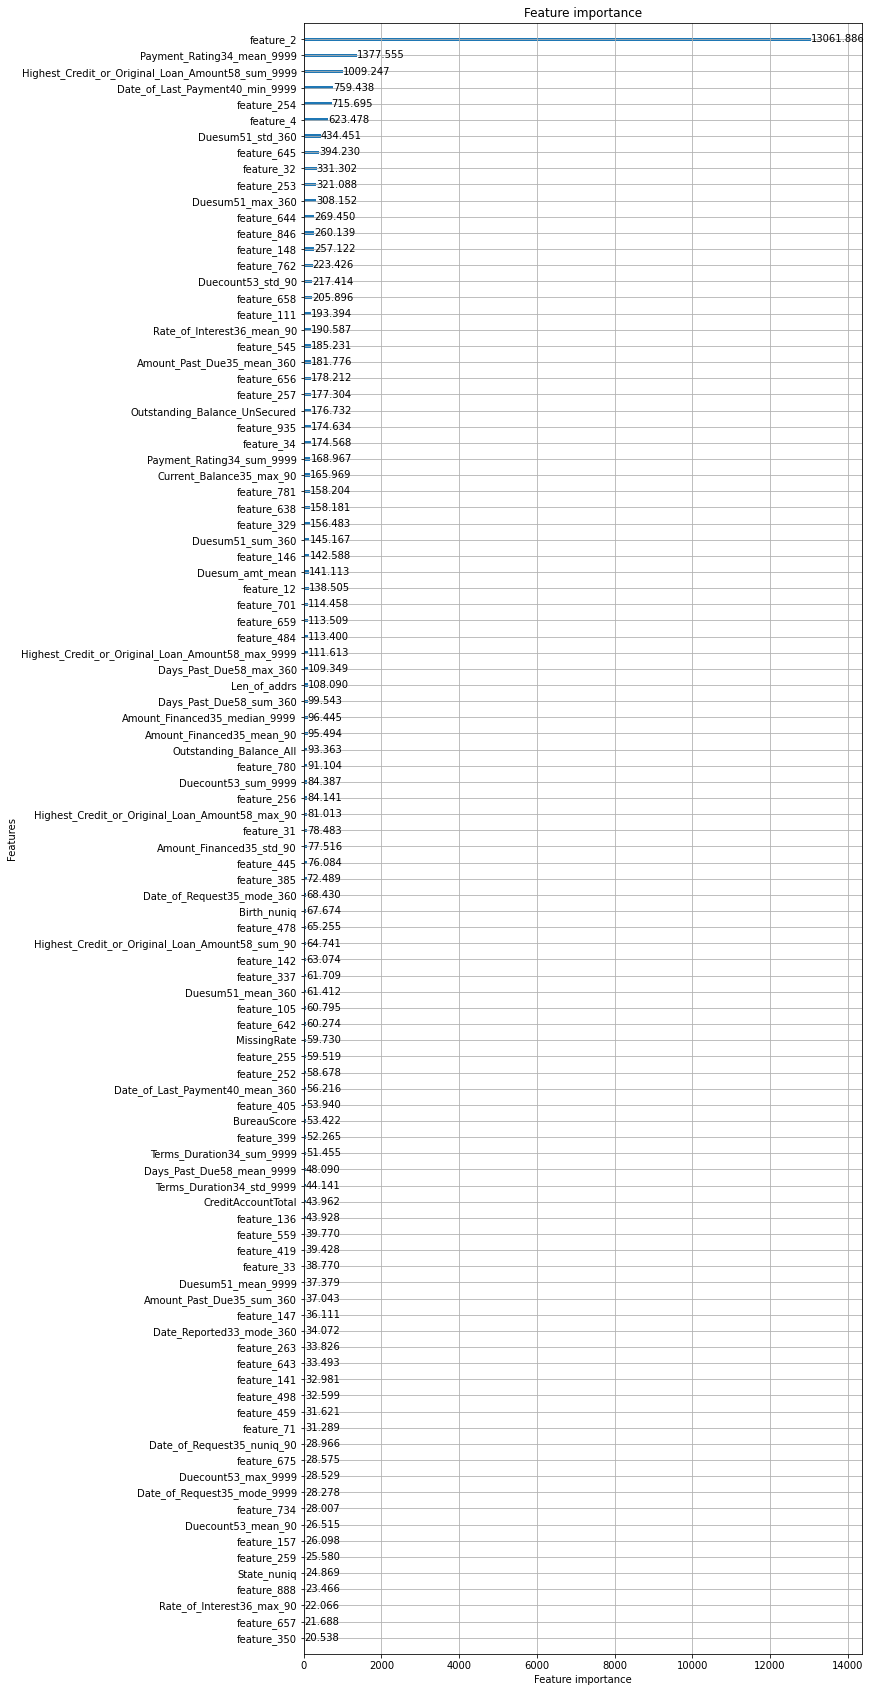

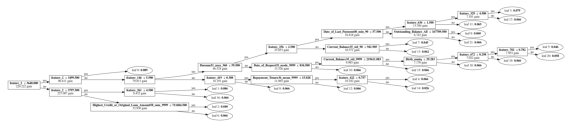

------------oot------------
 (0.7249412064551257, 0.3437111180620721)


,feature,gain,split
432,feature_2,13061.886389,717
91,Payment_Rating34_mean_9999,1377.554522,153
63,Highest_Credit_or_Original_Loan_Amount58_sum_9999,1009.247422,126
232,Date_of_Last_Payment40_min_9999,759.438452,81
684,feature_254,715.694582,76
434,feature_4,623.478019,73
335,Duesum51_std_360,434.451431,49
1075,feature_645,394.229520,38
462,feature_32,331.302319,38
683,feature_253,321.088460,34


In [17]:
import matplotlib.pyplot as plt
import graphviz
from lightgbm import plot_importance,plot_tree
def get_importance(model):
    plot_importance(model, max_num_features=100,figsize=(10,30),importance_type='gain')
    plt.show()
    feature_importance = pd.DataFrame({
        'feature': model.booster_.feature_name(),
        'gain': model.booster_.feature_importance('gain'),
        'split': model.booster_.feature_importance('split')

    }).sort_values('gain',ascending=False)
    
    return feature_importance


feature_importance = get_importance(clf)



ax = lgb.plot_tree(clf, tree_index=0, figsize=(10, 8), show_info=['split_gain'])
plt.show()

# graph = lgb.create_tree_digraph(clf, tree_index=0, name='Tree3')
# graph.render(view=True)
# clf.booster_.dump_model()
# feature_importance.to_pickle('./data/feature_importance.pkl')
print('------------oot------------\n',model_metrics(clf, oot_x,oot_y,tp='ks'))
feature_importance.head(200)

In [22]:
best_params={'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 1010, 'learning_rate': 0.2896725270248636, 'num_leaves': 1144, 'class_weight': None, 'reg_alpha': 4.215612812184543, 'reg_lambda': 0.44772383819316397, 'subsample_for_bin': 220000, 'subsample': 0.8562357844168368, 'feature_fraction': 0.4775606601751762, 'min_child_samples': 10, 'min_child_weight': 0.00011360202014521585, 'min_split_gain': 6.008916845569482, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}

clf = LGBMClassifier(**best_params)
clf.fit(train_x, train_y,
        eval_set=[(test_x,test_y)],
        eval_metric='auc',
        early_stopping_rounds=50,verbose=-1)

print('------------train------------\n',model_metrics(clf, train_x,train_y))


print('------------test------------\n',model_metrics(clf, test_x,test_y))

print('------------oot------------\n',model_metrics(clf, oot_x,oot_y))


import pickle

# pickle.dump(clf, open('./saved_models/SMS_ZX_NSMS.pkl', 'wb'))
# pickle.dump(clf, open('./saved_models/ZX_NSMS.pkl', 'wb'))
# pickle.dump(clf, open('./saved_models/SMS_NSMS.pkl', 'wb'))

 
# some time later...
 
# load the model from disk
# model = pickle.load(open('./saved_models/SMS_ZX_NSMS.pkl', 'rb'))

model.feature_name_

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2947031809327042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2947031809327042
------------train------------
 0.8057854987245683
------------test------------
 0.7137819231623364
------------oot------------
 0.7099665195379928


['BureauScore',
 'MissingRate',
 'Len_Name',
 'Tel_nuniq',
 'Email_nuniq',
 'Len_of_addrs',
 'City_nuniq',
 'Current_State',
 'CreditAccountActive',
 'CreditAccountTotal',
 'CreditAccountActivePor',
 'Outstanding_Balance_Secured',
 'Outstanding_Balance_UnSecured_Percentage',
 'Outstanding_Balance_All',
 'Outstanding_Balance_Secured_Percentage',
 'Outstanding_Balance_UnSecured',
 'Diff_dateBirth',
 'State_nuniq',
 'Birth_nuniq',
 'TotalCAPSLast90Days',
 'TotalCAPSLast7Days',
 'TotalCAPSLast30Days',
 'TotalCAPSLast180Days',
 'CAPSLast30Days',
 'CAPSLast7Days',
 'CAPSLast180Days',
 'NonCreditCAPSLast180Days',
 'Pin_nuniq',
 'Pan_nuniq',
 'Ident_nuniq',
 'Name_nuniq2',
 'Tel_nuniq2',
 'Email_nuniq2',
 'Pan_nuniq2',
 'Account_nuniq2',
 'Ident_nuniq2',
 'Gender_nuniq',
 'Amount_Past_Due35_sum_30',
 'Amount_Past_Due35_min_30',
 'Amount_Past_Due35_sum_90',
 'Amount_Past_Due35_mean_90',
 'Amount_Past_Due35_max_90',
 'Amount_Past_Due35_min_90',
 'Amount_Past_Due35_std_90',
 'Amount_Past_Due35_su

In [34]:
len(model.feature_name_)

1761

array([0])

In [ ]:
"""
0407######################################################################征信模型v2
#### 纯征信nocate
best_params= {'boosting_type': 'gbdt', 'max_depth': 11, 'n_estimators': 1730, 'learning_rate': 0.1291868482369266, 'num_leaves': 1584, 'class_weight': None, 'reg_alpha': 4.191420786845277, 'reg_lambda': 8.571864740877707, 'subsample_for_bin': 120000, 'subsample': 0.24917130389729128, 'feature_fraction': 0.2502338763355014, 'min_child_samples': 21, 'min_child_weight': 11.029313629457622, 'min_split_gain': 1.4021163489891033, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------oot------------
 0.5524426835343319
feature	gain	split
232	Date_of_Last_Payment40_min_9999	212.067219	13
279	Month50_mean_90	150.353552	14
398	Date_of_Request35_mode_9999	107.792249	25
394	Date_of_Request35_mode_90	94.797440	25
225	Date_of_Last_Payment40_max_360	91.386570	22

####纯非短信
{'boosting_type': 'dart', 'max_depth': 9, 'n_estimators': 180, 'learning_rate': 0.5743342145344562, 'num_leaves': 1688, 'class_weight': None, 'reg_alpha': 2.835217636179232, 'reg_lambda': 4.9760732788644075, 'subsample_for_bin': 220000, 'subsample': 0.2568609211119177, 'feature_fraction': 0.3896673716718368, 'min_child_samples': 35, 'min_child_weight': 2.459470973780215, 'min_split_gain': 4.0201798822125765, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 0.7827683736266859
------------test------------
 0.7191583388851877
------------oot------------
 0.7104102225466005
feature	gain	split
1	feature_2	1818.608220	94
644	feature_645	112.530722	3
761	feature_762	111.568910	18
253	feature_254	92.183211	13
780	feature_781	82.409350	15
 
####全旧短信模型
{'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 1010, 'learning_rate': 0.2896725270248636, 'num_leaves': 1144, 'class_weight': None, 'reg_alpha': 4.215612812184543, 'reg_lambda': 0.44772383819316397, 'subsample_for_bin': 220000, 'subsample': 0.8562357844168368, 'feature_fraction': 0.4775606601751762, 'min_child_samples': 10, 'min_child_weight': 0.00011360202014521585, 'min_split_gain': 6.008916845569482, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 0.7611966926084524
------------test------------
 0.7172573839662447
------------oot------------
 0.7184327899998841
feature	gain	split
1	feature_2	1017.962109	9
147	feature_148	63.685699	1
253	feature_254	40.906101	1
644	feature_645	33.428999	2
322	feature_323	26.262199	1

####纯短信模型
{'boosting_type': 'goss', 'max_depth': 21, 'n_estimators': 1490, 'learning_rate': 0.21930551278322413, 'num_leaves': 1800, 'class_weight': 'balanced', 'reg_alpha': 8.067758774301975, 'reg_lambda': 5.5502301875718985, 'subsample_for_bin': 120000, 'subsample': 0.45881373515492696, 'feature_fraction': 0.4266373931982871, 'min_child_samples': 380, 'min_child_weight': 0.07111103164297841, 'min_split_gain': 2.3939541961285906, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------oot------------
 0.5705453028881242
feature	gain	split
221	feature_1200_sms	67.078499	1
244	feature_1223_sms	63.761200	1
300	feature_1279_sms	56.925898	2
113	feature_1092_sms	55.080101	1
210	feature_1189_sms	42.302898	1
 
####征信+非短信
{'boosting_type': 'gbdt', 'max_depth': 8, 'n_estimators': 750, 'learning_rate': 0.1296823658012421, 'num_leaves': 688, 'class_weight': 'balanced', 'reg_alpha': 5.074138878618853, 'reg_lambda': 7.598729510431946, 'subsample_for_bin': 180000, 'subsample': 0.6760794529948264, 'feature_fraction': 0.2947031809327042, 'min_child_samples': 16, 'min_child_weight': 0.21358223805839294, 'min_split_gain': 3.873755769678977, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
best_params2={'boosting_type': 'dart', 'max_depth': 11, 'n_estimators': 1010, 'learning_rate': 0.2896725270248636, 'num_leaves': 1144, 'class_weight': None, 'reg_alpha': 4.215612812184543, 'reg_lambda': 0.44772383819316397, 'subsample_for_bin': 220000, 'subsample': 0.8562357844168368, 'feature_fraction': 0.4775606601751762, 'min_child_samples': 10, 'min_child_weight': 0.00011360202014521585, 'min_split_gain': 6.008916845569482, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 (0.7757365457020085, 0.40966377198842124)
------------test------------
 (0.727230735065512, 0.35149900066622247)
------------oot------------
 (0.7249412064551257, 0.3437111180620721)
feature	gain	split
432	feature_2	13061.886389	717
91	Payment_Rating34_mean_9999	1377.554522	153
63	Highest_Credit_or_Original_Loan_Amount58_sum_9999	1009.247422	126
232	Date_of_Last_Payment40_min_9999	759.438452	81
684	feature_254	715.694582	76
 
####征信+非短信+删feature2
------------oot------------
 (0.6444050556656125, 0.23184930316616276)
###仅feature2
------------oot------------
 0.6585664801492139

####征信+旧模型全量特征
{'boosting_type': 'dart', 'class_weight': None, 'feature_fraction': 0.5292621851563598, 'learning_rate': 0.23938665909933876, 'max_depth': 14, 'min_child_samples': 91, 'min_child_weight': 0.13614638467767243, 'min_split_gain': 3.983261344288425, 'n_estimators': 2110, 'num_leaves': 736, 'reg_alpha': 6.683254293882608, 'reg_lambda': 9.003622043307438, 'subsample': 0.8646544005048526, 'subsample_for_bin': 340000, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 0.7969966275001877
------------test------------
 0.7310259826782145
------------oot------------
 0.7241094081256734
    	feature	gain	split
432	feature_2	13278.014326	1026
91	Payment_Rating34_mean_9999	2055.987793	325
63	Highest_Credit_or_Original_Loan_Amount58_sum_9999	1120.851019	194
684	feature_254	1081.867901	151
434	feature_4	981.386679	162
1666	feature_1236_sms	924.502141	145
232	Date_of_Last_Payment40_min_9999	865.378960	122
--focal loss 0.7279370706333484
--稀疏增强：0.727281363315145
--lgb +cate 0.71 firstnm过拟合
--lgb+孤立森林 0.7241719667744064
--autoglun 0.7300130909764941 0.3458033573141487
--DNN ['bestval, layer_nums, k, norm', 0.6422467822843174, 2, 18, 0.01]
--lgb_DNN
--transformer(0.6019485860586893, 0.1655510374309248)
--tabnet 1 1 7 (0.6177689732272154, 0.18599381364473638)
0327######################################################################征信模型v1
------------train------------
 0.5955648848848103
------------test------------
 0.6020843981653152
------------oot------------
 0.5509538161177687   0.5572
 
 feature	gain	split
75	Payment_Rating34_mean_9999	49.402302	1
17	Outstanding_Balance_All	18.478901	1
288	Duesum51_max_360	17.084700	1
57	Highest_Credit_or_Original_Loan_Amount58_sum_9999	13.311400	1
201	Date_of_Last_Payment40_min_9999	13.146600	1

############原短信模型
------------train------------
 0.7120853595132949
------------test------------
 0.6249807618958398
------------oot------------
 0.5929736057969629
 
feature	gain	split
1091	feature_1092_sms	56.609210	4
637	feature_638	52.878950	3
1195	feature_1196_sms	52.133701	3
255	feature_256	50.603701	2
147	feature_148	39.322701	1

############## all feas 征信
------------train------------
 0.7853083217441518
------------test------------
 0.6151015121696859
------------oot------------
 0.5476976322696694
 
feature	gain	split
119	Highest_Credit_or_Original_Loan_Amount58_sum_9999	507.115121	115
121	Highest_Credit_or_Original_Loan_Amount58_max_9999	380.598070	94
1256	Duesum_days_mean	289.224108	77
689	Date_of_Last_Payment40_min_9999	287.205211	74
10	First_Name1	268.579750	54

#### no cate
------------train------------
 0.6136383342685391
------------test------------
 0.5851689136991731
------------oot------------
 0.5700932824995477  0.576

feature	gain	split
75	Payment_Rating34_mean_9999	58.121599	2  
286	Duesum51_sum_360	28.412300	1
57	Highest_Credit_or_Original_Loan_Amount58_sum_9999	26.575100	1
187	Date_Closed31_min_9999	14.249900	1
18	Outstanding_Balance_UnSecured	13.894300	1
201	Date_of_Last_Payment40_min_9999	13.299500	1
279	Duecount53_max_9999	8.855690	1
21	Birth_nuniq	7.208710	1
0	BureauScore	0.000000	0
{'boosting_type': 'gbdt', 'class_weight': 'balanced', 'feature_fraction': 0.8627221849600804, 'learning_rate': 0.34384893394376054, 'max_depth': 11, 'min_child_samples': 1198, 'min_child_weight': 0.003952236654749962, 'min_split_gain': 0.05949040934772148, 'n_estimators': 600, 'num_leaves': 688, 'reg_alpha': 3.5594821118603353, 'reg_lambda': 0.602149615246626, 'subsample': 0.8276897177180422, 'subsample_for_bin': 240000, 'n_jobs': -1, 'objective': 'binary', 'silent': True, 'verbose': -1, 'random_state': 0}
#### catst cat
------------train------------
 0.7142082720221239
------------test------------
 0.6097048242750667
------------oot------------
 0.5540017953382643
 	feature	gain	split
55	Highest_Credit_or_Original_Loan_Amount58_sum_9999	96.336401	4
73	Payment_Rating34_mean_9999	85.414260	6
374	First_Name1_cb	55.024140	7
72	Payment_Rating34_sum_9999	44.194199	1
268	Duecount53_std_90	43.439360	4
 ------------train------------
 0.6576732034576184
------------test------------
 0.596752167506254
------------oot------------
 0.5608230567852523
 55	Highest_Credit_or_Original_Loan_Amount58_sum_9999	390.087529	64
20	Outstanding_Balance_UnSecured	341.853791	59
73	Payment_Rating34_mean_9999	301.705399	53
276	Duecount53_max_9999	212.709760	39
72	Payment_Rating34_sum_9999	203.015642	3
 
###征信+全旧特征  
------------best_params------------ {'boosting_type': 'dart', 'class_weight': None, 'feature_fraction': 0.991392744378254, 'learning_rate': 0.4510972062848847, 'max_depth': 7, 'min_child_samples': 3, 'min_child_weight': 0.06580338317188161, 'min_split_gain': 3.521483184411901, 'n_estimators': 620, 'num_leaves': 536, 'reg_alpha': 3.7218762172324906, 'reg_lambda': 3.473122296406963, 'subsample': 0.47024140562740857, 'subsample_for_bin': 300000, 'n_jobs': -1, 'objective': 'binary', 'silent': True, 'verbose': -1, 'random_state': 0}
------------train------------
 0.8271731112970069
------------test------------
 0.612970887668147
------------oot------------2.2%提升
 0.6150194039886545

66	Payment_Rating34_mean_9999	874.495518	127
1552	feature_1196_sms	466.063108	78
49	Highest_Credit_or_Original_Loan_Amount58_max_9999	416.588179	71
364	feature_8	414.652489	60
178	Date_of_Last_Payment40_min_360	323.697860	54

####征信+非短信
{'boosting_type': 'dart', 'class_weight': 'balanced', 'feature_fraction': 0.17995978970954704, 'learning_rate': 0.07690886698935129, 'max_depth': 14, 'min_child_samples': 3, 'min_child_weight': 35.61164739586946, 'min_split_gain': 1.702474867184973, 'n_estimators': 120, 'num_leaves': 1904, 'reg_alpha': 6.286057155945472, 'reg_lambda': 5.4600895052199885, 'subsample': 0.2767001565456063, 'subsample_for_bin': 320000, 'n_jobs': -1, 'objective': 'binary', 'silent': True, 'verbose': -1, 'random_state': 0}
------------train------------
 0.7832807147506298
------------test------------
 0.6358589213031557
------------oot------------2.1%提升
 0.6114492066038413
 feature	gain	split
610	feature_254	275.991280	18
66	Payment_Rating34_mean_9999	246.923480	23
13	Outstanding_Balance_UnSecured	207.914050	16
502	feature_146	196.294701	14
358	feature_2	181.366581	17
{'boosting_type': 'dart', 'class_weight': 'balanced', 'feature_fraction': 0.6321724090841454, 'learning_rate': 0.35706456691656796, 'max_depth': 12, 'min_child_samples': 2, 'min_child_weight': 0.002290570255954292, 'min_split_gain': 1.23684757609968, 'n_estimators': 1700, 'num_leaves': 1640, 'reg_alpha': 8.94729123569297, 'reg_lambda': 7.85980599994622, 'subsample': 0.7809264483077517, 'subsample_for_bin': 20000, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}
------------train------------
 0.8414409134323174
------------test------------
 0.6170694712311154
------------oot------------
 0.6172994153204474][base]
 
####纯非短信
------------train------------
 0.7256212490982487
------------test------------
 0.6035682530527892
------------oot------------
 0.6027984749864326
 
 ------------train------------
 0.6423776717894365
------------test------------
 0.6160434794366807
------------oot------------
 0.5935999262750826
 
 	feature	gain	split
252	feature_253	67.532101	2
255	feature_256	57.024399	2
7	feature_8	38.250450	4
1	feature_2	31.335800	2
3	feature_4	28.566200	2

####纯短信
------------train------------
 0.6513204252509733
------------test------------
 0.5819320469286919
------------oot------------
 0.5721036517726407
	feature	gain	split
113	feature_1092_sms	30.375099	2
34	feature_1013_sms	22.397099	2
265	feature_1244_sms	19.532010	2
257	feature_1236_sms	17.757660	2
189	feature_1168_sms	11.141960	2

######### 征信+非短信优化验证
###ft50-filtert
 0.6107017178588373
--- ft60-nofilt
 ------------train------------
 0.7776614271344713
------------test------------
 0.6380635077328068
------------oot------------
 0.6180195985405197
2464	feature_2_+_Payment_Rating34_mean_9999	71.528502	2
2259	Duesum51_sum_360_+_feature_254	66.058098	1
2260	Duesum51_sum_360_+_feature_322	58.763901	1
3492	BureauScore_/_feature_254	56.664170	2
3420	Birth_nuniq_/_Email_nuniq2	37.157701	2
--ft60-filter
 0.6087835047323888
### focal loss+lgb


### qcut4+oh + lgb
------------oot------------
 0.6169734556165758
feature	gain	split
66	Payment_Rating34_mean_9999	1414.136241	181
501	feature_145	998.096571	120
65	Payment_Rating34_sum_9999	925.031363	123
358	feature_2	854.604890	108
16	Birth_nuniq	550.947980	76
### 征信+旧特征+qcut4+DNN
隐藏层vs神经元数vs norm 1 60 0.01
验证集最优结果： 1.0151114463806152 1.0118298530578613
------------train------------
 (0.6183410050043374, 0.1792503681475925)
------------test------------
 (0.6012399560179311, 0.16452676985536663)
------------oot------------
 (0.6188490038603186, 0.17209307088172954)
 --qcut50 15847cols
 ['bestval, layer_nums, k, norm', 0.6226751905413662, 1, 22, 0.01]
### 征信+旧特征+ DNN
oot参与搜索参数： 隐藏层vs神经元数vs norm 1 12 0.01
验证集最优结果： 0.6594440937042236 0.6678001284599304
------------train------------
 (0.6623875104578614, 0.2434398723137574)
------------test------------
 (0.6166708957117484, 0.19025966336801153)
------------oot------------
 (0.6311501428420273, 0.21031397940480784)
 --pytorch_tabular-dnn-transformer纯oot: 0.60
 --AutoGluon 21models--纯oot:0.6290817493284547 0.21659425013908756
{'roc_auc': 0.6290817493284547, 'accuracy': 0.6513274336283186, 'balanced_accuracy': 0.5299661070171786, 'mcc': 0.1139253842762341, 'f1': 0.7786516853932586, 'precision': 0.6581196581196581, 'recall': 0.953232462173315}
### 征信+旧特征+LGB+DNN
base LGB 0.617 
--DNN oot参与搜索参数：['bestval, layer_nums, k, norm', 0.6285083333048902, 1, 40, 0.4]
--tabnet  oot参与搜索参数0.59：nd,nd,ns1, 1, 7






"""
pass

#### 评分卡分数分布 

In [ ]:
res_df = pd.DataFrame()
res_df['score'] = clf.predict_proba(x)[:,1]*100
res_df['y'] = y


#分数区间计算
score_bin = np.arange(10,100,10)
good_total = sum(res_df.y == 0)
bad_total = sum(res_df.y == 1)
bin_rate = []
bad_rate = []
ks = []
good_num = []
bad_num = []
for i in range(len(score_bin)-1):
    #取出分数区间的样本
    if score_bin[i+1] == 61:
        index_1 = (res_df.score >= score_bin[i]) & (res_df.score <= score_bin[i+1]) 
    else:
        index_1 = (res_df.score >= score_bin[i]) & (res_df.score < score_bin[i+1]) 
    res_df_temp = res_df.loc[index_1,['y','score']]
    #计算该分数区间的指标
    good_num.append(sum(res_df_temp.y==0))
    bad_num.append(sum(res_df_temp.y==1))
    #区间样本率
    bin_rate.append(res_df_temp.shape[0]/res_df.shape[0]*100)
    #坏样本率
    bad_rate.append(res_df_temp.y.sum()/res_df_temp.shape[0]*100)
    #以该分数为注入分数的ks值
    ks.append(sum(bad_num[0:i+1])/bad_total - sum(good_num[0:i+1])/good_total )
res_df_result = pd.DataFrame({'好信用数量':good_num,'坏信用数量':bad_num,'区间样本率':bin_rate,
                            '坏信用率':bad_rate,'KS值(真正率-假正率)':ks},index=zip( (score_bin[1:] -10 ),(score_bin[1:]  )) )
print('评分卡10个区间分数统计结果如下：')
res_df_result

#### 暴力加工ft top50


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
start3
['Account_Type32_mode_360vcount', 'Amount_Financed35_mean_90', 'Amount_Past_Due35_max_360', 'Amount_Past_Due35_mean_9999', 'Birth_nuniq', 'BureauScore', 'CAPSLast180Days_nocrt_por', 'Current_Balance35_sum_9999', 'Date_of_Last_Payment40_max_360', 'Date_of_Last_Payment40_mean_360', 'Date_of_Request35_mode_90', 'Date_of_Request35_mode_9999', 'Duecount53_sum_9999', 'Duesum51_max_360', 'Duration_Of_Agreement41_sum_9999', 'Email_nuniq', 'Email_nuniq2', 'Highest_Credit_or_Original_Loan_Amount58_max_9999', 'Highest_Credit_or_Original_Loan_Amount58_std_90', 'Highest_Credit_or_Original_Loan_Amount58_sum_9999', 'Name_nuniq2', 'Outstanding_Balance_UnSecured', 'Payment_Rating34_mean_9999', 'Rate_of_Interest36_min_9999', 'Tel_nuniq2', 'feature_2', 'feature_254', 'feature_322', 'feature_329', 'feature_4', 'feature_407', 'feature_409', 'feature_410', 'feature_638', 'feature_643', 'feature_669', 'feature_700'

feature_10     0.990317
feature_527    0.989702
feature_528    0.989702
feature_532    0.989702
feature_531    0.989702
feature_533    0.989548
feature_529    0.989548
feature_530    0.989394
feature_534    0.989394
feature_538    0.988933
feature_524    0.988933
feature_526    0.987396
feature_540    0.987396
feature_521    0.986474
feature_535    0.986474
feature_522    0.986013
feature_536    0.986013
feature_537    0.985706
feature_523    0.985706
feature_539    0.983861
dtype: float64

single [('feature_7', 1.0), ('feature_13', 1.0), ('feature_14', 1.0), ('feature_17', 1.0), ('feature_264', 1.0), ('feature_265', 1.0), ('feature_266', 1.0), ('feature_267', 1.0), ('feature_268', 1.0), ('feature_269', 1.0), ('feature_270', 1.0), ('feature_271', 1.0), ('feature_327', 1.0), ('feature_328', 1.0), ('feature_338', 1.0), ('feature_339', 1.0), ('feature_341', 1.0), ('feature_342', 1.0), ('feature_361', 1.0), ('feature_362', 1.0)]
varance feature_552                                0.0
feature_1300_sms                           0.0
feature_327                                0.0
feature_547                                0.0
feature_548                                0.0
                                          ... 
CAPSLast180Days_nocrt_por - feature_804    NaN
CAPSLast180Days_nocrt_por - feature_846    NaN
CAPSLast180Days_nocrt_por - feature_874    NaN
CAPSLast180Days_nocrt_por - feature_888    NaN
CAPSLast180Days_nocrt_por - feature_9      NaN
Length: 7822, dtype: float64
mis

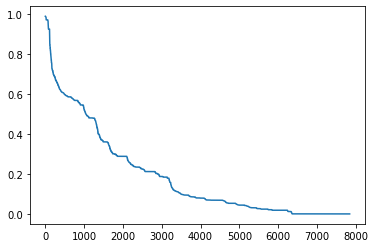

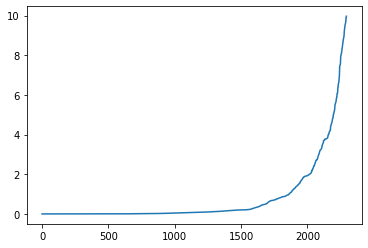

var_drop 409
single_drop 95
corr_drop1 3847


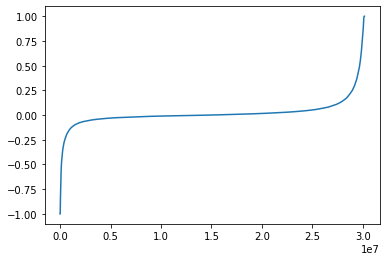

corr_drop2 0
4211 drop_list


,ID,report_timestamp,BureauScoreConfidLevel,MissingRate,Current_Finance_Purpose,Current_Amount_Financed,Current_Gender_Code,First_Name1,Len_Name,Name_nuniq,Tel_nuniq,IncomeTaxPAN_5,Len_of_addrs,City_nuniq,PinCode3,Current_State,Current_City,CreditAccountActive,CreditAccountActivePor,State_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast7Days,CAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_max_30,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Highest_Credit_or_Original_Loan_Amount58_sum_360,Terms_Duration34_std_30,Terms_Duration34_std_90,Terms_Duration34_sum_360,Terms_Duration34_max_360,Terms_Duration34_mean_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_mean_9999,Settlement_Amount37_mean_360,Settlement_Amount37_std_360,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_sum_9999,Written_Off_Amt_Principal45_mean_9999,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_max_30,Rate_of_Interest36_min_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_min_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_std_9999,Repayment_Tenure36_std_30,Repayment_Tenure36_std_90,Repayment_Tenure36_mean_360,Repayment_Tenure36_min_360,Repayment_Tenure36_std_360,Repayment_Tenure36_sum_9999,Repayment_Tenure36_mean_9999,Repayment_Tenure36_max_9999,Repayment_Tenure36_min_9999,Repayment_Tenure36_std_9999,Income26_count_30,Income26_min_9999,Income26_std_9999,Open_Date29_max_30,Open_Date29_mean_30,Open_Date29_mode_30,Open_Date29_nuniq_30,Open_Date29_maxcount_30,Open_Date29_mode_90,Open_Date29_nuniq_90,Open_Date29_max_360,Open_Date29_mode_360,Open_Date29_maxcount_360,Open_Date29_max_9999,Open_Date29_mean_9999,Open_Date29_mode_9999,Open_Date29_maxcount_9999,Portfolio_Type34_nuniq_30,Portfolio_Type34_nuniq_90,Portfolio_Type34_nuniq_360,Portfolio_Type34_mode_9999,Portfolio_Type34_nuniq_9999,Account_Type32_mode_30,Account_Type32_nuniq_30,Account_Type32_mode_90,Account_Type32_nuniq_90,Account_Type32_mode_360,Account_Type32_nuniq_360,Account_Type32_mode_9999,Account_Type32_nuniq_9999,Occupation_Code35_nuniq_30,Occupation_Code35_nuniq_90,Occupation_Code35_nuniq_360,CurrencyCode32_mode_360,CurrencyCode32_mode_9999,AccountHoldertypeCode41_mode_90,AccountHoldertypeCode41_nuniq_90,AccountHoldertypeCode41_nuniq_360,AccountHoldertypeCode41_nuniq_9999,Payment_History_Profile43_mode_30,Payment_History_Profile43_mode_90,Payment_History_Profile43_nuniq_90,Payment_History_Profile43_mode_360,Payment_History_Profile43_nuniq_360,Payment_History_Profile43_mode_9999,Payment_History_Profile43_nuniq_9999,Date_Closed31_mode_30,Date_Closed31_nuniq_30,Date_Closed31_maxcount_30,Date_Closed31_max_90,Date_Closed31_min_90,Date_Closed31_mean_90,Date_Closed31_mode_90,Date_Closed31_nuniq_90,Date_Closed31

./data/top30_tofeaturetools.pkl ok


In [3]:
%load_ext autoreload
%autoreload 1
%reload_ext autoreload
import feas_ft
import imp
imp.reload(feas_ft)


feas_ft.featuretools_topfeas(basedf_file='./data/filter_feas_df32n_old.pkl', importance_file='./data/feature_importance.pkl', catefeas=[],join_key='ID',final_file='./data/top30_tofeaturetools.pkl',topn=1)


### 原特征+ 等频4分箱onehot+  lgb特征--》3DNN or tabnet




,ID,report_timestamp,BureauScore,BureauScoreConfidLevel,MissingRate,Current_Finance_Purpose,Current_Amount_Financed,Current_Gender_Code,First_Name1,Len_Name,Name_nuniq,Tel_nuniq,Email_nuniq,IncomeTaxPAN_5,Len_of_addrs,City_nuniq,PinCode3,Current_State,Current_City,CreditAccountActive,CreditAccountActivePor,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast7Days,CAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_max_30,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_max_360,Amount_Past_Due35_min_360,Amount_Past_Due35_std_360,Amount_Past_Due35_mean_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Terms_Duration34_std_30,Terms_Duration34_std_90,Terms_Duration34_sum_360,Terms_Duration34_max_360,Terms_Duration34_mean_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_sum_9999,Current_Balance35_mean_9999,Settlement_Amount37_mean_360,Settlement_Amount37_std_360,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_sum_9999,Written_Off_Amt_Principal45_mean_9999,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_max_30,Rate_of_Interest36_min_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_min_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_min_9999,Rate_of_Interest36_std_9999,Repayment_Tenure36_std_30,Repayment_Tenure36_std_90,Repayment_Tenure36_mean_360,Repayment_Tenure36_min_360,Repayment_Tenure36_std_360,Repayment_Tenure36_sum_9999,Repayment_Tenure36_mean_9999,Repayment_Tenure36_max_9999,Repayment_Tenure36_min_9999,Repayment_Tenure36_std_9999,Income26_count_30,Income26_std_90,Income26_min_9999,Income26_std_9999,Open_Date29_max_30,Open_Date29_mean_30,Open_Date29_mode_30,Open_Date29_nuniq_30,Open_Date29_maxcount_30,Open_Date29_mode_90,Open_Date29_nuniq_90,Open_Date29_max_360,Open_Date29_mode_360,Open_Date29_maxcount_360,Open_Date29_max_9999,Open_Date29_mean_9999,Open_Date29_mode_9999,Open_Date29_maxcount_9999,Portfolio_Type34_nuniq_30,Portfolio_Type34_nuniq_90,Portfolio_Type34_nuniq_360,Portfolio_Type34_mode_9999,Portfolio_Type34_nuniq_9999,Account_Type32_mode_30,Account_Type32_nuniq_30,Account_Type32_mode_90,Account_Type32_nuniq_90,Account_Type32_mode_360,Account_Type32_nuniq_360,Account_Type32_mode_9999,Account_Type32_nuniq_9999,Occupation_Code35_nuniq_30,Occupation_Code35_nuniq_90,Occupation_Code35_nuniq_360,CurrencyCode32_mode_360,CurrencyCode32_mode_9999,AccountHold

##### 验证神经网络模型，取开头代码的逻辑 加工出trainx ootx，如下训练神经网络

In [3]:
#  './data/filter_feas_df32n_old_qcut_oh.pkl' ./data/filter_feas_df_0403_n_old.pkl
train_x, test_x, train_y, test_y,oot_x, oot_y,df,final_feas = read_train('./data/filter_feas_df32n_old_lgb_oh.pkl',model='nn')
train_x.describe(include='all')

(9123, 9071)
1.0    5631
0.0    2040
Name: label, dtype: int64
1.0    1035
0.0     417
Name: label, dtype: int64


,BureauScore,MissingRate,Len_Name,Tel_nuniq,Email_nuniq,Len_of_addrs,City_nuniq,Current_State,CreditAccountActive,CreditAccountTotal,CreditAccountActivePor,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_All,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,NonCreditCAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_sum_30,Amount_Past_Due35_min_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_max_30,Highest_Credit_or_Original_Loan_Amount58_min_30,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_sum_30,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_std_90,Terms_Duration34_mean_360,Terms_Duration34_max_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_max_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_max_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_mean_30,Current_Balance35_min_30,Current_Balance35_std_30,Current_Balance35_sum_90,Current_Balance35_mean_90,Current_Balance35_max_90,Current_Balance35_std_90,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_max_9999,Current_Balance35_std_9999,Settlement_Amount37_max_360,Settlement_Amount37_min_360,Settlement_Amount37_std_360,Settlement_Amount37_sum_9999,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Settlement_Amount37_std_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_mean_360,Written_Off_Amt_Total41_min_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_sum_9999,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_mean_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_mean_360,Rate_of_Interest36_max_360,Rate_of_Interest36_min_360,Rate_of_Interest36_std_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_min_9999,Rate_of_Interest36_std_9999

(6136, 9030)


,BureauScore,MissingRate,Len_Name,Tel_nuniq,Email_nuniq,Len_of_addrs,City_nuniq,Current_State,CreditAccountActive,CreditAccountTotal,CreditAccountActivePor,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_All,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,NonCreditCAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_sum_30,Amount_Past_Due35_min_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_max_30,Highest_Credit_or_Original_Loan_Amount58_min_30,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_sum_30,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_std_90,Terms_Duration34_mean_360,Terms_Duration34_max_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_max_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_max_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_mean_30,Current_Balance35_min_30,Current_Balance35_std_30,Current_Balance35_sum_90,Current_Balance35_mean_90,Current_Balance35_max_90,Current_Balance35_std_90,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_max_9999,Current_Balance35_std_9999,Settlement_Amount37_max_360,Settlement_Amount37_min_360,Settlement_Amount37_std_360,Settlement_Amount37_sum_9999,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Settlement_Amount37_std_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_mean_360,Written_Off_Amt_Total41_min_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_sum_9999,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_mean_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_mean_360,Rate_of_Interest36_max_360,Rate_of_Interest36_min_360,Rate_of_Interest36_std_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_min_9999,Rate_of_Interest36_std_9999

In [ ]:
def model_metrics2(nnmodel, x, y):
    yprob = nnmodel.predict(x)
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    return auc(fpr, tpr),max(tpr-fpr)

np.random.seed(42) # 固定随机种子，使每次运行结果固定
random.set_seed(42)

bestval = 0
# 创建模型结构：输入层的特征维数为13；1层k个神经元的relu隐藏层；线性的输出层；
for layer_nums in range(1,6):
    for k in list(range(1,20,1)) + list(range(20,100,2)) + list(range(100,1000,30)):  # 网格搜索超参数：神经元数,5,10,100
        for norm in [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8]:
            print("隐藏层vs神经元数vs norm",layer_nums,k,norm)
            model = Sequential()
            model.add(BatchNormalization())  # 输入层 批标准化  input_dim=train_x.shape
            for _ in range(layer_nums):
                model.add(Dense(k,  
                                kernel_initializer='random_uniform',   # 均匀初始化
                                activation='relu',                     # relu激活函数
                                kernel_regularizer=regularizers.l1_l2(l1=norm, l2=norm),  # L1及L2 正则项
                                use_bias=True))   # 隐藏层1
                model.add(Dropout(norm)) # dropout正则
            model.add(Dense(1,use_bias=True,activation='sigmoid'))  # 输出层



            # 编译模型：优化目标为回归预测损失mse，优化算法为adam
            model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy) 

            # 训练模型
            history = model.fit(train_x, 
                                train_y, 
                                epochs=1000,              # 训练迭代次数
                                batch_size=1000,           # 每epoch采样的batch大小
                                validation_data=(test_x,test_y),   # 从训练集再拆分验证集，作为早停的衡量指标
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10)],    #早停法
                                verbose=False,shuffle=True,use_multiprocessing=True,workers=16)  # 不输出过程  
            print("验证集最优结果：",min(history.history['loss']),min(history.history['val_loss']))
            print('------------train------------\n',model_metrics2(model, train_x,train_y))

            print('------------test------------\n',model_metrics2(model, test_x,test_y))

            print('------------oot------------\n',model_metrics2(model, oot_x,oot_y))
            if model_metrics2(model, test_x,test_y)[0] > bestval: # 仅以test调参
                bestval = model_metrics2(model, oot_x,oot_y)[0]
                best_paras = ['bestval, layer_nums, k, norm',bestval, layer_nums, k, norm]

# 模型评估：拟合效果
plt.plot(history.history['loss'],c='blue')    # 蓝色线训练集损失
plt.plot(history.history['val_loss'],c='red') # 红色线验证集损失
plt.show()
model.summary()   #模型概述信息
print(best_paras)
    

隐藏层vs神经元数vs norm 1 1 0.0001
验证集最优结果： 0.3444439172744751 0.5625657439231873
------------train------------
 (0.892433769937714, 0.6677266725277641)
------------test------------
 (0.681738840772818, 0.29280479680213195)
------------oot------------
 (0.6551755696891762, 0.250304104542453)
隐藏层vs神经元数vs norm 1 1 0.001
验证集最优结果： 0.38465946912765503 0.6545520424842834
------------train------------
 (0.940564817578419, 0.7900470985875838)
------------test------------
 (0.679535864978903, 0.2829447035309794)
------------oot------------
 (0.6468378920052363, 0.24128870816390363)
隐藏层vs神经元数vs norm 1 1 0.01
验证集最优结果： 0.5036781430244446 0.6126749515533447
------------train------------
 (0.8777170687203517, 0.6169702457938504)
------------test------------
 (0.7065989340439707, 0.33965134354874527)
------------oot------------
 (0.683374459852408, 0.2780175859312549)
隐藏层vs神经元数vs norm 1 1 0.02
验证集最优结果： 0.6428812146186829 0.6574302911758423
------------train------------
 (0.7642066300788, 0.45637658295314026

隐藏层vs神经元数vs norm 1 3 0.1
验证集最优结果： 0.9271166920661926 0.9253682494163513
------------train------------
 (0.7810999235891574, 0.42387009750673244)
------------test------------
 (0.7165189873417721, 0.32051965356429046)
------------oot------------
 (0.6968419467324691, 0.3126750773294408)
隐藏层vs神经元数vs norm 1 3 0.2
验证集最优结果： 1.2393089532852173 1.2318589687347412
------------train------------
 (0.7679714038005089, 0.39123258337004985)
------------test------------
 (0.7175816122584944, 0.33455474128358875)
------------oot------------
 (0.7111817792143098, 0.322316060195322)
隐藏层vs神经元数vs norm 1 3 0.3
验证集最优结果： 1.5477930307388306 1.5340559482574463
------------train------------
 (0.7611260345750603, 0.3796607737596097)
------------test------------
 (0.7162136353542082, 0.32063069065067734)
------------oot------------
 (0.7111389149549925, 0.3356410523754909)
隐藏层vs神经元数vs norm 1 3 0.4
验证集最优结果： 1.9191287755966187 1.9053211212158203
------------train------------
 (0.7619888205996592, 0.385210678026096

------------oot------------
 (0.6935518252065015, 0.30650957494873665)
隐藏层vs神经元数vs norm 1 5 0.6
验证集最优结果： 3.885399103164673 3.8670849800109863
------------train------------
 (0.7124661345656527, 0.3124101631158298)
------------test------------
 (0.6724061736620031, 0.2835665112147458)
------------oot------------
 (0.6809080272014272, 0.27062871441976855)
隐藏层vs神经元数vs norm 1 5 0.8
验证集最优结果： 5.002954959869385 4.979686260223389
------------train------------
 (0.6744370876166382, 0.2530427961630793)
------------test------------
 (0.670777259604708, 0.2864090606262492)
------------oot------------
 (0.6278884139065559, 0.20802835992075908)
隐藏层vs神经元数vs norm 1 6 0.0001
验证集最优结果： 0.3178759813308716 0.6784706115722656
------------train------------
 (0.9473938758976921, 0.745242595965318)
------------test------------
 (0.6812958027981346, 0.2789473684210526)
------------oot------------
 (0.6466641179809776, 0.23654120182115174)
隐藏层vs神经元数vs norm 1 6 0.001
验证集最优结果： 0.3596837520599365 0.8138555884361267

------------oot------------
 (0.6882494004796162, 0.30101136482118657)
隐藏层vs神经元数vs norm 1 8 0.02
验证集最优结果： 0.7625674605369568 0.7799626588821411
------------train------------
 (0.7948993562944869, 0.4448284613807148)
------------test------------
 (0.7195092160781701, 0.3230290917166334)
------------oot------------
 (0.6984673131060368, 0.3245612205887464)
隐藏层vs神经元数vs norm 1 8 0.05
验证集最优结果： 1.035230040550232 1.0465914011001587
------------train------------
 (0.7682994492869561, 0.3979982931076607)
------------test------------
 (0.7135287586053742, 0.3341105929380413)
------------oot------------
 (0.7090026529501037, 0.3283564452785598)
隐藏层vs神经元数vs norm 1 8 0.1
验证集最优结果： 1.4393041133880615 1.4370075464248657
------------train------------
 (0.7567844909677511, 0.3821987778325986)
------------test------------
 (0.7054497001998667, 0.31224739062846996)
------------oot------------
 (0.7128673872496205, 0.32737635978173985)
隐藏层vs神经元数vs norm 1 8 0.2
验证集最优结果： 2.317960739135742 2.308850049972534
-

------------test------------
 (0.6900455252054187, 0.2758605374194981)
------------oot------------
 (0.6791598605173832, 0.2892433878983769)
隐藏层vs神经元数vs norm 1 10 0.4
验证集最优结果： 4.727696895599365 4.7125139236450195
------------train------------
 (0.7458759464217188, 0.37432162535134433)
------------test------------
 (0.6968987341772153, 0.32571618920719525)
------------oot------------
 (0.6837648721602428, 0.27495916310429913)
隐藏层vs神经元数vs norm 1 10 0.5
验证集最优结果： 6.078531265258789 6.0397419929504395
------------train------------
 (0.7536019015403316, 0.38005291230891364)
------------test------------
 (0.7247834776815456, 0.35405285365312017)
------------oot------------
 (0.6920237722865186, 0.2926771626177319)
隐藏层vs神经元数vs norm 1 10 0.6
验证集最优结果： 7.287631511688232 7.269596576690674
------------train------------
 (0.7509826813370069, 0.3761404605902112)
------------test------------
 (0.7027514990006662, 0.3236508994003997)
------------oot------------
 (0.7107600875821084, 0.3178674451742953)


------------train------------
 (0.9834688627508309, 0.8734488903507792)
------------test------------
 (0.665836109260493, 0.27135243171219187)
------------oot------------
 (0.6385894183204162, 0.21357522677510166)
隐藏层vs神经元数vs norm 1 13 0.001
验证集最优结果： 0.411699503660202 0.9582934379577637
------------train------------
 (0.9805783806721853, 0.8511043024921847)
------------test------------
 (0.6688763046857651, 0.25650677326226956)
------------oot------------
 (0.6233413269384492, 0.21054460779202722)
隐藏层vs神经元数vs norm 1 13 0.01
验证集最优结果： 0.7342482209205627 0.7782310247421265
------------train------------
 (0.8178877173462088, 0.4772985349286888)
------------test------------
 (0.7157317343992894, 0.3361425716189207)
------------oot------------
 (0.6957819251844901, 0.3245612205887464)
隐藏层vs神经元数vs norm 1 13 0.02
验证集最优结果： 0.8962269425392151 0.9189834594726562
------------train------------
 (0.7652564162434968, 0.4119554204660587)
------------test------------
 (0.7083499888962914, 0.31501221407

隐藏层vs神经元数vs norm 1 15 0.1
验证集最优结果： 2.1793580055236816 2.179191827774048
------------train------------
 (0.758698958200088, 0.3851811694987408)
------------test------------
 (0.7058549855651788, 0.3477459471463469)
------------oot------------
 (0.6854620651305042, 0.2691968164598756)
隐藏层vs神经元数vs norm 1 15 0.2
验证集最优结果： 3.9270715713500977 3.915567398071289
------------train------------
 (0.7763917568334915, 0.4143446636603162)
------------test------------
 (0.7234443704197202, 0.33393293359982235)
------------oot------------
 (0.7077387365469943, 0.3126889792513815)
隐藏层vs神经元数vs norm 1 15 0.3
验证集最优结果： 5.574522495269775 5.555846214294434
------------train------------
 (0.7612057617430065, 0.3856757757324849)
------------test------------
 (0.6938751943149012, 0.27377304019542525)
------------oot------------
 (0.7004854087744298, 0.3130851840266917)
隐藏层vs神经元数vs norm 1 15 0.4
验证集最优结果： 7.192168712615967 7.172643661499023
------------train------------
 (0.7589999316430904, 0.3812489551883233)
--

------------oot------------
 (0.6788366408322617, 0.2763006985715776)
隐藏层vs神经元数vs norm 1 17 0.6
验证集最优结果： 11.699426651000977 11.655515670776367
------------train------------
 (0.7470752379463419, 0.3641479514246324)
------------test------------
 (0.7011503442149678, 0.3047301798800799)
------------oot------------
 (0.6990268654641505, 0.299058144788517)
隐藏层vs神经元数vs norm 1 17 0.8
验证集最优结果： 15.393647193908691 15.353339195251465
------------train------------
 (0.681830395001418, 0.26004877028626655)
------------test------------
 (0.6545380857206307, 0.2291916500111037)
------------oot------------
 (0.6658429777916797, 0.24078128801306783)
隐藏层vs神经元数vs norm 1 18 0.0001
验证集最优结果： 0.3414268493652344 1.2002652883529663
------------train------------
 (0.9842639686668169, 0.8868335793505281)
------------test------------
 (0.6802242949145014, 0.30940484121696654)
------------oot------------
 (0.6367242437933711, 0.22917318319257635)
隐藏层vs神经元数vs norm 1 18 0.001
验证集最优结果： 0.4058118462562561 0.942707300

------------test------------
 (0.7188141239173884, 0.3346990894958916)
------------oot------------
 (0.6972080306769078, 0.3295311576825496)
隐藏层vs神经元数vs norm 1 20 0.02
验证集最优结果： 1.0373940467834473 1.0614787340164185
------------train------------
 (0.7753715468762584, 0.41829257975593204)
------------test------------
 (0.7157606040417499, 0.3408172329558073)
------------oot------------
 (0.7047556157972173, 0.3275848886108504)
隐藏层vs神经元数vs norm 1 20 0.05
验证集最优结果： 1.6938363313674927 1.7078373432159424
------------train------------
 (0.7642987427066222, 0.3858915399187433)
------------test------------
 (0.7133422163002443, 0.3233177881412392)
------------oot------------
 (0.6945886768845793, 0.30201230320091754)
隐藏层vs神经元数vs norm 1 20 0.1
验证集最优结果： 2.703090190887451 2.702345132827759
------------train------------
 (0.769139697835387, 0.3980210336241548)
------------test------------
 (0.713175660670664, 0.3268487674883411)
------------oot------------
 (0.6937568785551269, 0.3130504292218399)
隐

验证集最优结果： 8.590391159057617 8.567315101623535
------------train------------
 (0.7559569662797395, 0.37362709207675737)
------------test------------
 (0.7054452587164113, 0.3039307128580946)
------------oot------------
 (0.6995933687832342, 0.2892294859764363)
隐藏层vs神经元数vs norm 1 24 0.4
验证集最优结果： 10.825628280639648 10.796889305114746
------------train------------
 (0.7682283851729125, 0.40155704857875163)
------------test------------
 (0.7216544525871641, 0.33773040195425275)
------------oot------------
 (0.7125430090710041, 0.3266673617627637)
隐藏层vs神经元数vs norm 1 24 0.5
验证集最优结果： 13.501300811767578 13.458745002746582
------------train------------
 (0.756354248517298, 0.3833446020714174)
------------test------------
 (0.706815456362425, 0.3179991117033089)
------------oot------------
 (0.6985009094173936, 0.3134466339971501)
隐藏层vs神经元数vs norm 1 24 0.6
验证集最优结果： 16.396831512451172 16.364173889160156
------------train------------
 (0.7483885027738693, 0.37292362502783344)
------------test-------

------------oot------------
 (0.6417451546009569, 0.22300768081187225)
隐藏层vs神经元数vs norm 1 30 0.0001
验证集最优结果： 0.4828854501247406 1.5520087480545044
------------train------------
 (0.98952271310605, 0.9117398593201262)
------------test------------
 (0.6381390184321564, 0.2203642016433489)
------------oot------------
 (0.6148472526326765, 0.187536926980155)
隐藏层vs神经元数vs norm 1 30 0.001
验证集最优结果： 0.40136945247650146 0.9840251207351685
------------train------------
 (0.988271984698881, 0.8921490397207789)
------------test------------
 (0.632964690206529, 0.22532755940484123)
------------oot------------
 (0.5946628204682631, 0.15927431967469496)
隐藏层vs神经元数vs norm 1 30 0.01
验证集最优结果： 0.9396105408668518 0.9713160991668701
------------train------------
 (0.7751660023864007, 0.4170127489020594)
------------test------------
 (0.7044614701310237, 0.3095936042638242)
------------oot------------
 (0.6875543043825809, 0.29573558544468775)
隐藏层vs神经元数vs norm 1 30 0.02
验证集最优结果： 1.2637174129486084 1.282682418

------------test------------
 (0.719888962913613, 0.3504330446369087)
------------oot------------
 (0.6997323880026414, 0.2961109373370869)
隐藏层vs神经元数vs norm 1 34 0.1
验证集最优结果： 4.3373260498046875 4.340127944946289
------------train------------
 (0.759323374882152, 0.38423730270402334)
------------test------------
 (0.7157117477237398, 0.31987563846324674)
------------oot------------
 (0.7100429801086667, 0.31364126090432)
隐藏层vs神经元数vs norm 1 34 0.2
验证集最优结果： 8.124716758728027 8.117386817932129
------------train------------
 (0.7608813709824241, 0.3817889070948381)
------------test------------
 (0.7049156118143459, 0.3089940039973351)
------------oot------------
 (0.6915916542128616, 0.3234907725993119)
隐藏层vs神经元数vs norm 1 34 0.3
验证集最优结果： 11.78317928314209 11.758410453796387
------------train------------
 (0.7486548240012616, 0.36909387840185603)
------------test------------
 (0.6937941372418388, 0.30200977126360207)
------------oot------------
 (0.673679027792259, 0.2522920793799742)
隐藏层vs神

验证集最优结果： 20.62864112854004 20.595569610595703
------------train------------
 (0.7434071790998411, 0.3721176902944694)
------------test------------
 (0.6952487230735066, 0.30699533644237176)
------------oot------------
 (0.6793544874245531, 0.30238765509331667)
隐藏层vs神经元数vs norm 1 38 0.6
验证集最优结果： 25.401641845703125 25.352752685546875
------------train------------
 (0.7054521065095405, 0.3037349267938106)
------------test------------
 (0.6653741949811236, 0.2508882966910948)
------------oot------------
 (0.6447862000254868, 0.23253744830222778)
隐藏层vs神经元数vs norm 1 38 0.8
验证集最优结果： 33.29423904418945 33.21355438232422
------------train------------
 (0.7053402989701119, 0.310345243002046)
------------test------------
 (0.664721296913169, 0.26998667554963357)
------------oot------------
 (0.663630255216117, 0.2518819726827234)
隐藏层vs神经元数vs norm 1 40 0.0001
验证集最优结果： 0.24897126853466034 1.638844609260559
------------train------------
 (0.9999768534028542, 0.9956668487261588)
------------test------

------------oot------------
 (0.6682167309630556, 0.2597435095401939)
隐藏层vs神经元数vs norm 1 44 0.01
验证集最优结果： 1.1222336292266846 1.1549625396728516
------------train------------
 (0.7662923956660366, 0.4114451124471164)
------------test------------
 (0.6890051077059738, 0.31714412613813014)
------------oot------------
 (0.6766806844379568, 0.29975324088555244)
隐藏层vs神经元数vs norm 1 44 0.02
验证集最优结果： 1.5756944417953491 1.6001496315002441
------------train------------
 (0.7640948225393712, 0.4017274670922392)
------------test------------
 (0.7022940262047523, 0.3164334887852543)
------------oot------------
 (0.6999756716366038, 0.31374552531887534)
隐藏层vs神经元数vs norm 1 44 0.05
验证集最优结果： 2.9826786518096924 2.997689723968506
------------train------------
 (0.7767124928682085, 0.4120785982637345)
------------test------------
 (0.7124139462580502, 0.3345769487008661)
------------oot------------
 (0.7085705348764466, 0.30473707990129634)
隐藏层vs神经元数vs norm 1 44 0.1
验证集最优结果： 5.512345314025879 5.52249288558

------------test------------
 (0.7149755718409948, 0.3301132578281145)
------------oot------------
 (0.7040651536741621, 0.30117818788447503)
隐藏层vs神经元数vs norm 1 48 0.3
验证集最优结果： 16.2515926361084 16.233543395996094
------------train------------
 (0.766518108828261, 0.3908355718529258)
------------test------------
 (0.7109005107705973, 0.34653564290473016)
------------oot------------
 (0.7074525886537146, 0.3332777256455705)
隐藏层vs神经元数vs norm 1 48 0.4
验证集最优结果： 20.870248794555664 20.857942581176758
------------train------------
 (0.763998310704489, 0.39879339902364674)
------------test------------
 (0.7029424827892516, 0.3195092160781701)
------------oot------------
 (0.6857331526083481, 0.3019775483960658)
隐藏层vs神经元数vs norm 1 48 0.5
验证集最优结果： 26.514083862304688 26.44116973876953
------------train------------
 (0.7407947269073777, 0.35061544906767267)
------------test------------
 (0.6984388185654008, 0.30445258716411283)
------------oot------------
 (0.6957587553145889, 0.3024780175859312)
隐

验证集最优结果： 45.4702262878418 45.3115348815918
------------train------------
 (0.738467275652284, 0.35938814474609465)
------------test------------
 (0.6737896957583833, 0.28371085942704866)
------------oot------------
 (0.6855976088694261, 0.26697250894936225)
隐藏层vs神经元数vs norm 1 54 0.0001
验证集最优结果： 0.3365843892097473 1.6701284646987915
------------train------------
 (0.9990986363134916, 0.9722374840867144)
------------test------------
 (0.6813668665334223, 0.28481012658227844)
------------oot------------
 (0.6547133307846477, 0.23818162861015535)
隐藏层vs神经元数vs norm 1 54 0.001
验证集最优结果： 0.5470921397209167 0.9542900919914246
------------train------------
 (0.9595457040389459, 0.7981813001213504)
------------test------------
 (0.6875816122584943, 0.31120364201643347)
------------oot------------
 (0.660510432233923, 0.2578737010391686)
隐藏层vs神经元数vs norm 1 54 0.01
验证集最优结果： 1.2340396642684937 1.2628365755081177
------------train------------
 (0.7533197431675238, 0.3920286368075563)
------------test-

------------oot------------
 (0.7017041439312318, 0.31186181489590936)
隐藏层vs神经元数vs norm 1 58 0.05
验证集最优结果： 3.7688217163085938 3.7778069972991943
------------train------------
 (0.777698862771135, 0.4293757389821859)
------------test------------
 (0.7083055740617366, 0.32962469464801236)
------------oot------------
 (0.6929598350305263, 0.3007472283043131)
隐藏层vs神经元数vs norm 1 58 0.1
验证集最优结果： 6.790970325469971 6.7895588874816895
------------train------------
 (0.7549402080080458, 0.39247302440070964)
------------test------------
 (0.7164756828780813, 0.34606928714190544)
------------oot------------
 (0.6975103974791181, 0.30559899906162025)
隐藏层vs神经元数vs norm 1 58 0.2
验证集最优结果： 12.872383117675781 12.856298446655273
------------train------------
 (0.7661594042526119, 0.39420414621881383)
------------test------------
 (0.7142760381967577, 0.34198312236286926)
------------oot------------
 (0.7010577045609889, 0.3097209189170403)
隐藏层vs神经元数vs norm 1 58 0.3
验证集最优结果： 19.248289108276367 19.220123291

------------test------------
 (0.7085698423273373, 0.3162558294470353)
------------oot------------
 (0.6891819877431389, 0.2772668821464568)
隐藏层vs神经元数vs norm 1 62 0.5
验证集最优结果： 34.16799545288086 34.14529800415039
------------train------------
 (0.7394952688220074, 0.3562816277607562)
------------test------------
 (0.682660448589829, 0.27291805463024654)
------------oot------------
 (0.6972613213776805, 0.28304313071282106)
隐藏层vs神经元数vs norm 1 62 0.6
验证集最优结果： 38.685211181640625 38.658599853515625
------------train------------
 (0.723355254920513, 0.3260253705655147)
------------test------------
 (0.6845391960914946, 0.3018210082167444)
------------oot------------
 (0.6575620662889977, 0.2376742084593195)
隐藏层vs神经元数vs norm 1 62 0.8
验证集最优结果： 51.2889404296875 51.16221618652344
------------train------------
 (0.6831483297564396, 0.2742246397557019)
------------test------------
 (0.6614923384410394, 0.23908505440817235)
------------oot------------
 (0.6308564742408971, 0.20291245264657837)
隐藏层v

------------train------------
 (0.9538475803345969, 0.7765579115001364)
------------test------------
 (0.6870530757272929, 0.290084388185654)
------------oot------------
 (0.6570094648918546, 0.2447016300003475)
隐藏层vs神经元数vs norm 1 68 0.01
验证集最优结果： 1.398922085762024 1.4277418851852417
------------train------------
 (0.7599209225610966, 0.3962790829886724)
------------test------------
 (0.6861803242282922, 0.3117255163224517)
------------oot------------
 (0.679706669447051, 0.3044103847356897)
隐藏层vs神经元数vs norm 1 68 0.02
验证集最优结果： 2.1393260955810547 2.170315742492676
------------train------------
 (0.7566037850777543, 0.38871136396399686)
------------test------------
 (0.6855585165445259, 0.30664001776593375)
------------oot------------
 (0.680529199828543, 0.2858999756716366)
隐藏层vs神经元数vs norm 1 68 0.05
验证集最优结果： 4.226197242736816 4.238789081573486
------------train------------
 (0.7842615321829068, 0.42408396664994974)
------------test------------
 (0.7212702642682656, 0.3558405507439485)


隐藏层vs神经元数vs norm 1 72 0.2
验证集最优结果： 15.698210716247559 15.697656631469727
------------train------------
 (0.7613064697446226, 0.38967783591499106)
------------test------------
 (0.7163757495003331, 0.3331001554519209)
------------oot------------
 (0.7153071745502149, 0.3159489799464776)
隐藏层vs神经元数vs norm 1 72 0.3
验证集最优结果： 24.221439361572266 24.17070960998535
------------train------------
 (0.7687741575687681, 0.3962258864233026)
------------test------------
 (0.7148656451254719, 0.3418054630246502)
------------oot------------
 (0.7146398822970609, 0.30616897786118935)
隐藏层vs神经元数vs norm 1 72 0.4
验证集最优结果： 31.6763973236084 31.56182861328125
------------train------------
 (0.752562741152687, 0.3792833894739835)
------------test------------
 (0.7033100155451921, 0.3269487008660893)
------------oot------------
 (0.6717258077595895, 0.2808535780071595)
隐藏层vs神经元数vs norm 1 72 0.5
验证集最优结果： 39.627593994140625 39.55103302001953
------------train------------
 (0.7475914341347336, 0.365214048495505)
--

------------oot------------
 (0.700019694389416, 0.3135856532165572)
隐藏层vs神经元数vs norm 1 76 0.8
验证集最优结果： 62.52644729614258 62.46369171142578
------------train------------
 (0.6506806250122671, 0.21137337153198663)
------------test------------
 (0.623310015545192, 0.1776371308016878)
------------oot------------
 (0.6263568855060879, 0.19224967851805508)
隐藏层vs神经元数vs norm 1 78 0.0001
验证集最优结果： 0.32889437675476074 1.4743146896362305
------------train------------
 (0.997504837435763, 0.9663633920999716)
------------test------------
 (0.6767355096602264, 0.2666444592493893)
------------oot------------
 (0.6386635619040999, 0.21821846870329825)
隐藏层vs神经元数vs norm 1 78 0.001
验证集最优结果： 0.5688557028770447 0.9392668604850769
------------train------------
 (0.9605607703079241, 0.7816083365650586)
------------test------------
 (0.6519475904952253, 0.2281479013990673)
------------oot------------
 (0.6243144614742988, 0.21557015257359324)
隐藏层vs神经元数vs norm 1 78 0.01
验证集最优结果： 1.5060349702835083 1.5328990221

####  autogluon

In [7]:
from autogluon.tabular import TabularDataset, TabularPredictor

# train = pd.concat([train_x,train_y],axis=1)
# val = pd.concat([test_x,test_y],axis=1)
# vpath='./data/automodel'
# model = TabularPredictor(label='label',eval_metric='roc_auc',path=vpath)
# predictor = model.fit( pd.concat([train,val]) )




train = pd.concat([train_x,train_y],axis=1)
val = pd.concat([test_x,test_y],axis=1)
vpath='./data/automodel'
model = TabularPredictor(label='label',eval_metric='roc_auc',path=vpath)
predictor2 = model.fit( pd.concat([train,val]),auto_stack=True, presets='best_quality')


y_pred = predictor2.predict_proba(oot_x)
print("Predictions:  \n", y_pred)
fpr,tpr,_ = roc_curve(oot_y, y_pred[1],pos_label=1)
print(auc(fpr, tpr),max(tpr-fpr))   # val-》oot0.6085821264860178

perf = predictor2.evaluate_predictions(y_true=oot_y, y_pred=y_pred, auxiliary_metrics=True)
print(perf)

predictor2.leaderboard(val, silent=True)

predictor2.fit_summary(show_plot=True)

predictor2.feature_importance(val)

Presets specified: ['best_quality']
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "./data/automodel/"
AutoGluon Version:  0.3.1
Train Data Rows:    7671
Train Data Columns: 1761
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, 0.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    115523.34 MB
	Train Data (Original)  Memory Usage: 108.07 

/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a f

Fitting model: LightGBMLarge_BAG_L1 ...
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument 

/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a f

Fitting model: LightGBMLarge_BAG_L2 ...
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument 

Predictions:  
              0         1
0     0.314340  0.685660
1789  0.086377  0.913623
3921  0.225109  0.774891
3922  0.075995  0.924005
3923  0.105877  0.894123
...        ...       ...
8714  0.366803  0.633197
8718  0.340966  0.659034
8721  0.456564  0.543436
8723  0.286990  0.713010
8724  0.581488  0.418512

[1452 rows x 2 columns]
0.7300130909764941 0.3458033573141487
{'roc_auc': 0.7300130909764941, 'accuracy': 0.7210743801652892, 'balanced_accuracy': 0.5380148055468669, 'mcc': 0.15257391971809992, 'f1': 0.8318804483188045, 'precision': 0.7292576419213974, 'recall': 0.9681159420289855}


/usr/local/lib/python3.6/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')
Computing feature importance via permutation shuffling for 1761 features using 1000 rows with 3 shuffle sets...


*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L2   0.733550      10.295661  347.655579                0.002392           2.456590            2       True         12
1           CatBoost_BAG_L1   0.729190       0.800230  106.959460                0.800230         106.959460            1       True          7
2       WeightedEnsemble_L3   0.728325      40.298569  743.484664                0.002392           2.033625            3       True         22
3           CatBoost_BAG_L2   0.727775      30.894764  548.392217                0.932192          72.991360            2       True         17
4         LightGBMXT_BAG_L1   0.723712       0.242499   39.105738                0.242499          39.105738            1       True          3
5           LightGBM_BAG_L1   0.723562       0.254709   40.058334         

	10234.36s	= Expected runtime (3411.45s per shuffle set)
	5970.57s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
feature_2,0.188764,0.028887,0.003858,3,0.354291,0.023238
Payment_Rating34_mean_9999,0.004409,0.000837,0.005901,3,0.009205,-0.000388
feature_4,0.004160,0.001392,0.017681,3,0.012138,-0.003818
feature_1236_sms,0.002922,0.000267,0.001385,3,0.004452,0.001393
Highest_Credit_or_Original_Loan_Amount58_sum_9999,0.002801,0.002191,0.078636,3,0.015356,-0.009755
...,...,...,...,...,...,...
feature_256,-0.000378,0.000087,0.991376,3,0.000121,-0.000877
feature_32,-0.000397,0.000182,0.968303,3,0.000645,-0.001438
feature_545,-0.000506,0.000160,0.984164,3,0.000410,-0.001423
feature_253,-0.000541,0.000271,0.962814,3,0.001011,-0.002092


#### pytorch  Transformer

In [10]:
#### Pytorch FC transformer网络实现
from pytorch_tabular.models import CategoryEmbeddingModelConfig,TabTransformerConfig
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig

data_config = DataConfig(
    target=['label'], #target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=list(train_x.columns),
    categorical_cols=[],
)
trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=1024,
    max_epochs=100
)
optimizer_config = OptimizerConfig()

# model_config = CategoryEmbeddingModelConfig(
#     task="classification",
#     layers="1024-512-512",  # Number of nodes in each layer
#     activation="LeakyReLU", # Activation between each layers
#     learning_rate = 1e-3
# )
model_config = TabTransformerConfig(
    task="classification"
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=pd.concat([train_x,train_y],axis=1), validation=pd.concat([test_x,test_y],axis=1))
result = tabular_model.evaluate(test_x)
pred_df = tabular_model.predict(test_x)
tabular_model.save_model("examples/basic")
loaded_model = TabularModel.load_from_checkpoint("examples/basic")


### oot
yprob = tabular_model.predict(oot_x)['1.0_probability']
fpr,tpr,_ = roc_curve(oot_y, yprob,pos_label=1)
auc(fpr, tpr),max(tpr-fpr)

Experiment Tracking is turned off
Global seed set to 42
Preparing the DataLoaders...
Preprocessing data: Stage: fit...
Preprocessing data: Stage: inference...
Preparing the Model: TabTransformerModel...
/usr/local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

Checkpoint directory saved_models exists and is not empty.

Preparing the Trainer...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name         | Type                   | Params
--------------------------------------------------------
0 | backbone     | TabTransformerBackbone | 507 K 
1 | dropout      | Dropout                | 0     
2 | output_layer | Linear                 | 66    
3 | loss         | CrossEntropyLoss       | 0     
--------------------------------------------------------
507 K     Trainable params
0         Non-trainable params
507 K     Total params
2.029     Total estimated model params size (MB)
/usr/local/lib/python3.6/site-package

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

Restored states from the checkpoint file at /home/projects/Euler/lr_find_temp_model.ckpt
Learning rate set to 0.006918309709189364


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------



  | Name         | Type                   | Params
--------------------------------------------------------
0 | backbone     | TabTransformerBackbone | 507 K 
1 | dropout      | Dropout                | 0     
2 | output_layer | Linear                 | 66    
3 | loss         | CrossEntropyLoss       | 0     
--------------------------------------------------------
507 K     Trainable params
0         Non-trainable params
507 K     Total params
2.029     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 3it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training the model completed...
Loading the best model...
Preprocessing data: Stage: inference...
/usr/local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Testing: 0it [00:00, ?it/s]

Preprocessing data: Stage: inference...


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.1179153099656105}
--------------------------------------------------------------------------------


Generating Predictions...:   0%|          | 0/2 [00:00<?, ?it/s]

Directory is not empty. Overwriting the contents.
Experiment Tracking is turned off
Preparing the Trainer...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Preprocessing data: Stage: inference...


Generating Predictions...:   0%|          | 0/2 [00:00<?, ?it/s]

KeyError: '1_probability'

#### tabnet

In [7]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import pandas as pd

"""
n_steps: 决策的步数，通常为{3 ~ 10}
n_d: 预测阶段的特征数，通常为{8 ~ 64}
n_a: Attentive阶段的特征数，通常为{8 ~ 64}
gamma: Attentive中注意力更新的比例，通常为{1.0 ~ 2.0}
momentum: BN层的动量，通常为{0.0 ~ 1.0}


"""
def model_metrics2(nnmodel, x, y):
    yprob = nnmodel.predict_proba(x)[:,1]
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    return auc(fpr, tpr),max(tpr-fpr)


bestval=0

for nd in list(range(1,20,3)) + list(range(20,100,10)):
    for ns in range(1,20,3):
        print(nd,nd,ns)
        clf = TabNetClassifier(n_d=nd,
                               n_a=nd,
                               n_steps=ns,
                               verbose=False)  

        clf.fit(
            train_x.values,
            train_y.values,
            num_workers=16,
            max_epochs=200,
            patience=3,
            batch_size=2024,
            eval_set=[(test_x.values,test_y.values)]
        )

        print('------------train------------\n',model_metrics2(clf, train_x.values,train_y.values))

        print('------------test------------\n',model_metrics2(clf, test_x.values,test_y.values))

        print('------------oot------------\n',model_metrics2(clf, oot_x.values,oot_y.values))
        if model_metrics2(clf, test_x.values,test_y.values)[0] > bestval:
            bestval =model_metrics2(clf, oot_x.values,oot_y.values)[0]
            bestparas = ['nd,na,ns',nd,nd,ns,bestval ]
print(bestparas)

8 8 12

Early stopping occured at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.53921
Best weights from best epoch are automatically used!
------------train------------
 (0.4809428380570665, 0.003109494910117361)
------------test------------
 (0.5392049744614701, 0.09709082833666449)
------------oot------------
 (0.4730754526813332, 0.0016404267890035816)
8 8 14

Early stopping occured at epoch 13 with best_epoch = 3 and best_val_0_auc = 0.54293
Best weights from best epoch are automatically used!
------------train------------
 (0.5108400522761158, 0.02644789748358589)
------------test------------
 (0.5429202753719743, 0.09945591827670441)
------------oot------------
 (0.5265665728286936, 0.05789455392207976)
8 8 16

Early stopping occured at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.52775
Best weights from best epoch are automatically used!
------------train------------
 (0.5155775245188113, 0.033688450863225916)
------------test------------
 (0.527627137463913, 0.0719

18 18 18

Early stopping occured at epoch 10 with best_epoch = 0 and best_val_0_auc = 0.51868
Best weights from best epoch are automatically used!
------------train------------
 (0.4973288691533692, 0.016561187217393303)
------------test------------
 (0.5186164779036199, 0.04870086608927382)
------------oot------------
 (0.4861861235649162, 0.03508150001737742)
20 20 12

Early stopping occured at epoch 15 with best_epoch = 5 and best_val_0_auc = 0.53022
Best weights from best epoch are automatically used!
------------train------------
 (0.517346547197739, 0.031172916586296506)
------------test------------
 (0.5302409504774594, 0.07199644681323564)
------------oot------------
 (0.5523303096653112, 0.10615507593924861)
20 20 14

Early stopping occured at epoch 19 with best_epoch = 9 and best_val_0_auc = 0.53068
Best weights from best epoch are automatically used!
------------train------------
 (0.4937649699940239, 0.011843342206195595)
------------test------------
 (0.530599600266489, 0.

------------test------------
 (0.5273073506551188, 0.07503886298023538)
------------oot------------
 (0.5027039238174678, 0.03798700170298541)
70 70 16

Early stopping occured at epoch 18 with best_epoch = 8 and best_val_0_auc = 0.53901
Best weights from best epoch are automatically used!
------------train------------
 (0.5105784686563265, 0.030716888014461874)
------------test------------
 (0.5404363757495003, 0.09397068620919391)
------------oot------------
 (0.5311391466536914, 0.08139575296284707)
70 70 18

Early stopping occured at epoch 14 with best_epoch = 4 and best_val_0_auc = 0.50745
Best weights from best epoch are automatically used!
------------train------------
 (0.49929274286499375, 0.010915041836459194)
------------test------------
 (0.5032511658894071, 0.044481456806573394)
------------oot------------
 (0.5100835273809937, 0.04283182149932219)
80 80 12

Early stopping occured at epoch 16 with best_epoch = 6 and best_val_0_auc = 0.55117
Best weights from best epoch are 

In [8]:
print(bestparas)

['nd,na,ns', 30, 30, 18, 0.5756762705777407]


#### qcut-onehot

In [ ]:
df = pd.read_pickle('./data/filter_feas_df32n_old.pkl')
df.head()

# qcut-onehot
df2 = df[final_feas].apply(lambda x: pd.qcut(x.replace([np.inf, -np.inf], np.nan).fillna(-9999),q=50,duplicates='drop'))
df2 = df2.applymap(lambda x: str(x).replace(']','qcut').replace('(','').replace(',','_'))
df2 = pd.get_dummies(df2,prefix_sep='_')
df2.head()

# 等频onehot 存储
pd.concat([df,df2],axis=1).to_pickle('./data/filter_feas_df32n_old_qcut_oh.pkl')

#### lgb_onehot



In [20]:
train_x, test_x, train_y, test_y,oot_x, oot_y,df,final_feas =  read_train(file='./data/filter_feas_df_0403_n_old.pkl')

(9123, 1802)
1.0    5631
0.0    2040
Name: label, dtype: int64
1.0    1035
0.0     417
Name: label, dtype: int64


,BureauScore,MissingRate,Len_Name,Tel_nuniq,Email_nuniq,Len_of_addrs,City_nuniq,Current_State,CreditAccountActive,CreditAccountTotal,CreditAccountActivePor,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_All,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,NonCreditCAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_sum_30,Amount_Past_Due35_min_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_max_30,Highest_Credit_or_Original_Loan_Amount58_min_30,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_sum_30,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_std_90,Terms_Duration34_mean_360,Terms_Duration34_max_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_max_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_max_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_mean_30,Current_Balance35_min_30,Current_Balance35_std_30,Current_Balance35_sum_90,Current_Balance35_mean_90,Current_Balance35_max_90,Current_Balance35_std_90,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_max_9999,Current_Balance35_std_9999,Settlement_Amount37_max_360,Settlement_Amount37_min_360,Settlement_Amount37_std_360,Settlement_Amount37_sum_9999,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Settlement_Amount37_std_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_mean_360,Written_Off_Amt_Total41_min_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_sum_9999,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_mean_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_mean_360,Rate_of_Interest36_max_360,Rate_of_Interest36_min_360,Rate_of_Interest36_std_360,Rate_of_Interest36_sum_9999,Rate_of_Interest36_mean_9999,Rate_of_Interest36_max_9999,Rate_of_Interest36_min_9999,Rate_of_Interest36_std_9999

(6136, 1761)


In [21]:
paras = {'boosting_type': 'dart', 'class_weight': None, 'feature_fraction': 0.5292621851563598, 'learning_rate': 0.23938665909933876, 'max_depth': 14, 'min_child_samples': 91, 'min_child_weight': 0.13614638467767243, 'min_split_gain': 3.983261344288425, 'n_estimators': 2110, 'num_leaves': 736, 'reg_alpha': 6.683254293882608, 'reg_lambda': 9.003622043307438, 'subsample': 0.8646544005048526, 'subsample_for_bin': 340000, 'n_jobs': -1, 'objective': 'binary', 'verbose': -1, 'random_state': 0}

clf = LGBMClassifier(**paras)
clf.fit(train_x, train_y,
        eval_set=[(test_x,test_y)],
        eval_metric='auc',
        early_stopping_rounds=50,verbose=-1)


print('------------train------------\n',model_metrics(clf, train_x,train_y))


print('------------test------------\n',model_metrics(clf, test_x,test_y))

print('------------oot------------\n',model_metrics(clf, oot_x,oot_y))

/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5292621851563598, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292621851563598


/usr/local/lib/python3.6/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


------------train------------
 0.7969966275001877
------------test------------
 0.7310259826782145
------------oot------------
 0.7241094081256734


In [23]:
import numpy as np

y_pred = clf.predict(df[final_feas],pred_leaf=True) 
train_matrix = np.zeros([len(y_pred), len(y_pred[0])*clf.get_params()['num_leaves']],dtype=np.int64)
print(train_matrix.shape) 


for i in range(len(y_pred)):
    temp = np.arange(len(y_pred[0]))*clf.get_params()['num_leaves'] + np.array(y_pred[i])
    train_matrix[i][temp] += 1

(9123, 999488)


In [24]:
# drop zero-features
df2 = pd.DataFrame(train_matrix)
droplist2 = []
for k in df2.columns:
    if not df2[k].any():
        droplist2.append(k)
print(len(droplist2))
df2 = df2.drop(droplist2,axis=1).add_suffix('_lgb')

#  存储lgb-onehot
pd.concat([df,df2],axis=1).to_pickle('./data/filter_feas_df32n_old_lgb_oh.pkl')
df2.head()




992219


AttributeError: 'NoneType' object has no attribute 'add_suffix'

In [26]:
df2 = df2.add_suffix('_lgb')

#  存储lgb-onehot
pd.concat([df,df2],axis=1).to_pickle('./data/filter_feas_df32n_old_lgb_oh.pkl')
df2.head()


,0_lgb,1_lgb,2_lgb,3_lgb,4_lgb,5_lgb,6_lgb,7_lgb,8_lgb,9_lgb,10_lgb,11_lgb,12_lgb,13_lgb,14_lgb,15_lgb,16_lgb,736_lgb,737_lgb,738_lgb,739_lgb,740_lgb,741_lgb,742_lgb,743_lgb,744_lgb,745_lgb,746_lgb,747_lgb,748_lgb,749_lgb,750_lgb,751_lgb,752_lgb,1472_lgb,1473_lgb,1474_lgb,1475_lgb,1476_lgb,1477_lgb,1478_lgb,1479_lgb,1480_lgb,1481_lgb,1482_lgb,1483_lgb,1484_lgb,1485_lgb,1486_lgb,1487_lgb,2208_lgb,2209_lgb,2210_lgb,2211_lgb,2212_lgb,2213_lgb,2214_lgb,2215_lgb,2216_lgb,2217_lgb,2218_lgb,2219_lgb,2220_lgb,2221_lgb,2222_lgb,2944_lgb,2945_lgb,2946_lgb,2947_lgb,2948_lgb,2949_lgb,2950_lgb,2951_lgb,2952_lgb,2953_lgb,2954_lgb,2955_lgb,2956_lgb,3680_lgb,3681_lgb,3682_lgb,3683_lgb,3684_lgb,3685_lgb,3686_lgb,3687_lgb,3688_lgb,3689_lgb,3690_lgb,3691_lgb,3692_lgb,3693_lgb,3694_lgb,3695_lgb,3696_lgb,3697_lgb,4416_lgb,4417_lgb,4418_lgb,4419_lgb,4420_lgb,4421_lgb,4422_lgb,4423_lgb,4424_lgb,4425_lgb,4426_lgb,4427_lgb,5152_lgb,5153_lgb,5154_lgb,5155_lgb,5156_lgb,5157_lgb,5158_lgb,5159_lgb,5160_lgb,5161_lgb,5162_lgb,5163_lgb,5164_lgb,5888_lgb,5889_lgb,5890_lgb,5891_lgb,5892_lgb,5893_lgb,5894_lgb,5895_lgb,5896_lgb,5897_lgb,5898_lgb,5899_lgb,6624_lgb,6625_lgb,6626_lgb,6627_lgb,6628_lgb,6629_lgb,6630_lgb,6631_lgb,6632_lgb,6633_lgb,6634_lgb,7360_lgb,7361_lgb,7362_lgb,7363_lgb,7364_lgb,7365_lgb,7366_lgb,7367_lgb,7368_lgb,7369_lgb,7370_lgb,8096_lgb,8097_lgb,8098_lgb,8099_lgb,8100_lgb,8101_lgb,8102_lgb,8103_lgb,8104_lgb,8105_lgb,8832_lgb,8833_lgb,8834_lgb,8835_lgb,8836_lgb,8837_lgb,8838_lgb,9568_lgb,9569_lgb,9570_lgb,9571_lgb,9572_lgb,10304_lgb,10305_lgb,10306_lgb,10307_lgb,10308_lgb,10309_lgb,10310_lgb,10311_lgb,11040_lgb,11041_lgb,11042_lgb,11043_lgb,11044_lgb,11776_lgb,11777_lgb,12512_lgb,12513_lgb,12514_lgb,12515_lgb,12516_lgb,12517_lgb,12518_lgb,13248_lgb,13249_lgb,13250_lgb,13251_lgb,13252_lgb,13253_lgb,13254_lgb,13255_lgb,13256_lgb,13257_lgb,13984_lgb,13985_lgb,13986_lgb,13987_lgb,13988_lgb,13989_lgb,13990_lgb,14720_lgb,14721_lgb,14722_lgb,14723_lgb,14724_lgb,14725_lgb,14726_lgb,14727_lgb,14728_lgb,14729_lgb,14730_lgb,14731_lgb,15456_lgb,15457_lgb,15458_lgb,15459_lgb,15460_lgb,15461_lgb,15462_lgb,15463_lgb,16192_lgb,16193_lgb,16194_lgb,16195_lgb,16196_lgb,16197_lgb,16198_lgb,16199_lgb,16200_lgb,16201_lgb,16928_lgb,16929_lgb,16930_lgb,16931_lgb,16932_lgb,16933_lgb,16934_lgb,16935_lgb,16936_lgb,17664_lgb,17665_lgb,17666_lgb,17667_lgb,17668_lgb,17669_lgb,17670_lgb,17671_lgb,17672_lgb,18400_lgb,18401_lgb,18402_lgb,18403_lgb,18404_lgb,18405_lgb,18406_lgb,18407_lgb,18408_lgb,19136_lgb,19137_lgb,19138_lgb,19872_lgb,19873_lgb,19874_lgb,19875_lgb,19876_lgb,19877_lgb,19878_lgb,19879_lgb,20608_lgb,20609_lgb,20610_lgb,20611_lgb,20612_lgb,20613_lgb,20614_lgb,20615_lgb,21344_lgb,21345_lgb,21346_lgb,21347_lgb,21348_lgb,21349_lgb,21350_lgb,21351_lgb,...,948707_lgb,949440_lgb,949441_lgb,949442_lgb,949443_lgb,949444_lgb,950176_lgb,950177_lgb,950178_lgb,950179_lgb,950180_lgb,950181_lgb,950182_lgb,950912_lgb,950913_lgb,950914_lgb,950915_lgb,950916_lgb,951648_lgb,951649_lgb,951650_lgb,951651_lgb,951652_lgb,952384_lgb,952385_lgb,952386_lgb,952387_lgb,953120_lgb,953121_lgb,953122_lgb,953123_lgb,953856_lgb,953857_lgb,953858_lgb,953859_lgb,954592_lgb,954593_lgb,954594_lgb,955328_lgb,955329_lgb,955330_lgb,955331_lgb,955332_lgb,956064_lgb,956065_lgb,956066_lgb,956067_lgb,956068_lgb,956069_lgb,956800_lgb,956801_lgb,957536_lgb,957537_lgb,957538_lgb,957539_lgb,958272_lgb,958273_lgb,958274_lgb,958275_lgb,959008_lgb,959009_lgb,959010_lgb,959744_lgb,959745_lgb,959746_lgb,959747_lgb,959748_lgb,959749_lgb,959750_lgb,960480_lgb,960481_lgb,960482_lgb,960483_lgb,960484_lgb,960485_lgb,961216_lgb,961217_lgb,961218_lgb,961219_lgb,961220_lgb,961952_lgb,961953_lgb,961954_lgb,961955_lgb,961956_lgb,961957_lgb,962688_lgb,962689_lgb,962690_lgb,963424_lgb,963425_lgb,963426_lgb,963427_lgb,964160_lgb,964161_lgb,964162_lgb,964163_lgb,964896_lgb,964897_lgb,964898_lgb,965632_lgb,965633_lgb,965634_lgb,966368_lgb,966369_lgb,966370_lgb,966371_lgb,966372_lgb,967104_lgb,967105_lgb,967106_lgb,967107_lgb,9

### 训练集异常检测编码



In [18]:
from pyod.models import iforest


it = iforest.IForest()

it.fit(train_x)
ift = it.predict_proba(df[final_feas])

In [19]:
df['ift_socre'] = ift[:,1]
df.head()

,ID,report_timestamp,BureauScore,BureauScoreConfidLevel,MissingRate,Current_Enquiry_Reason,Current_Gender_Code,First_Name1,Len_Name,Tel_nuniq,Email_nuniq,IncomeTaxPAN_5,Len_of_addrs,City_nuniq,PinCode3,Current_State,Current_City,CreditAccountActive,CreditAccountTotal,CreditAccountActivePor,Outstanding_Balance_Secured,Outstanding_Balance_UnSecured_Percentage,Outstanding_Balance_All,Outstanding_Balance_Secured_Percentage,Outstanding_Balance_UnSecured,Diff_dateBirth,State_nuniq,Birth_nuniq,TotalCAPSLast90Days,TotalCAPSLast7Days,TotalCAPSLast30Days,TotalCAPSLast180Days,CAPSLast30Days,CAPSLast7Days,CAPSLast180Days,NonCreditCAPSLast180Days,Pin_nuniq,Pan_nuniq,Ident_nuniq,Name_nuniq2,Tel_nuniq2,Email_nuniq2,Pan_nuniq2,Account_nuniq2,Ident_nuniq2,Gender_nuniq,Amount_Past_Due35_sum_30,Amount_Past_Due35_min_30,Amount_Past_Due35_sum_90,Amount_Past_Due35_mean_90,Amount_Past_Due35_max_90,Amount_Past_Due35_min_90,Amount_Past_Due35_std_90,Amount_Past_Due35_sum_360,Amount_Past_Due35_mean_360,Amount_Past_Due35_max_360,Amount_Past_Due35_std_360,Amount_Past_Due35_sum_9999,Amount_Past_Due35_max_9999,Amount_Past_Due35_min_9999,Amount_Past_Due35_std_9999,Highest_Credit_or_Original_Loan_Amount58_max_30,Highest_Credit_or_Original_Loan_Amount58_min_30,Highest_Credit_or_Original_Loan_Amount58_std_30,Highest_Credit_or_Original_Loan_Amount58_sum_90,Highest_Credit_or_Original_Loan_Amount58_mean_90,Highest_Credit_or_Original_Loan_Amount58_max_90,Highest_Credit_or_Original_Loan_Amount58_min_90,Highest_Credit_or_Original_Loan_Amount58_std_90,Highest_Credit_or_Original_Loan_Amount58_sum_360,Highest_Credit_or_Original_Loan_Amount58_max_360,Highest_Credit_or_Original_Loan_Amount58_std_360,Highest_Credit_or_Original_Loan_Amount58_sum_9999,Highest_Credit_or_Original_Loan_Amount58_mean_9999,Highest_Credit_or_Original_Loan_Amount58_max_9999,Highest_Credit_or_Original_Loan_Amount58_std_9999,Terms_Duration34_sum_30,Terms_Duration34_std_30,Terms_Duration34_sum_90,Terms_Duration34_std_90,Terms_Duration34_mean_360,Terms_Duration34_max_360,Terms_Duration34_min_360,Terms_Duration34_std_360,Terms_Duration34_sum_9999,Terms_Duration34_mean_9999,Terms_Duration34_max_9999,Terms_Duration34_min_9999,Terms_Duration34_std_9999,Payment_Rating34_sum_90,Payment_Rating34_mean_90,Payment_Rating34_max_90,Payment_Rating34_min_90,Payment_Rating34_std_90,Payment_Rating34_sum_360,Payment_Rating34_mean_360,Payment_Rating34_max_360,Payment_Rating34_min_360,Payment_Rating34_std_360,Payment_Rating34_sum_9999,Payment_Rating34_mean_9999,Payment_Rating34_max_9999,Payment_Rating34_min_9999,Payment_Rating34_std_9999,Current_Balance35_mean_30,Current_Balance35_min_30,Current_Balance35_std_30,Current_Balance35_sum_90,Current_Balance35_mean_90,Current_Balance35_max_90,Current_Balance35_std_90,Current_Balance35_sum_360,Current_Balance35_max_360,Current_Balance35_std_360,Current_Balance35_max_9999,Current_Balance35_std_9999,Settlement_Amount37_max_360,Settlement_Amount37_min_360,Settlement_Amount37_std_360,Settlement_Amount37_sum_9999,Settlement_Amount37_mean_9999,Settlement_Amount37_max_9999,Settlement_Amount37_min_9999,Settlement_Amount37_std_9999,Value_of_Collateral39_std_90,Value_of_Collateral39_std_360,Written_Off_Amt_Total41_sum_360,Written_Off_Amt_Total41_mean_360,Written_Off_Amt_Total41_min_360,Written_Off_Amt_Total41_std_360,Written_Off_Amt_Total41_sum_9999,Written_Off_Amt_Total41_mean_9999,Written_Off_Amt_Total41_max_9999,Written_Off_Amt_Total41_min_9999,Written_Off_Amt_Total41_std_9999,Written_Off_Amt_Principal45_sum_360,Written_Off_Amt_Principal45_mean_360,Written_Off_Amt_Principal45_min_360,Written_Off_Amt_Principal45_std_360,Written_Off_Amt_Principal45_max_9999,Written_Off_Amt_Principal45_min_9999,Rate_of_Interest36_sum_30,Rate_of_Interest36_std_30,Rate_of_Interest36_sum_90,Rate_of_Interest36_mean_90,Rate_of_Interest36_max_90,Rate_of_Interest36_std_90,Rate_of_Interest36_sum_360,Rate_of_Interest36_mean_360,Rate_of_Interest36_max_360,Rate_of_Interest36_min_360,Rate_of_Interest36_std_360,Rate_

In [20]:
df.to_pickle('./data/filter_feas_df_0403_n_old_itf.pkl')